In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def find_out_files(root_dir):
    root_dir = Path(root_dir)
    return sorted(root_dir.rglob("*.out"))


def parse_conformal_out_file(file_path, model_name):
    text = Path(file_path).read_text(errors="ignore")

    # run id matches one of the patterns "test_run = 20" or "test_run 20"
    run_match = re.search(r"\btest_run\b\s*(?:=)?\s*(\d+)", text)
    if not run_match:
        return [], []
    run_id = int(run_match.group(1))

    # find results
    block_starts = [m.start() for m in re.finditer(r"Target coverage:\s*([0-9.]+)", text)]
    if not block_starts:
        return [], []

    overall_rows = []
    class_rows = []

    for i, st in enumerate(block_starts):
        en = block_starts[i + 1] if (i + 1) < len(block_starts) else len(text)
        block = text[st:en]

        m_t = re.search(r"Target coverage:\s*([0-9.]+)", block)
        m_a = re.search(r"Alpha:\s*([0-9.]+)", block)
        m_c = re.search(r"Coverage:\s*([0-9.]+)", block)
        m_s = re.search(r"Average Prediction Set Size.*?:\s*([0-9.]+)", block)

        if not (m_t and m_a and m_c and m_s):
            continue

        target = float(m_t.group(1))
        alpha = float(m_a.group(1))
        cov = float(m_c.group(1))
        avg_size = float(m_s.group(1))

        overall_rows.append({
            "model": model_name,
            "run": run_id,
            "target_coverage": round(target, 2),
            "alpha": alpha,
            "empirical_coverage": cov,
            "avg_set_size": avg_size,
            "file": str(file_path)
        })

        m_fsc = re.search(r"FSC Metric.*?:\s*([0-9.]+)", block)
        fsc_val = float(m_fsc.group(1)) if m_fsc else np.nan

        # Per class coverage lines
        # e.g. Class crops_fair_skin_orticaria
        for cm in re.finditer(r"Class\s+(.+?):\s*Coverage\s*=\s*([0-9.]+)", block):
            class_name = cm.group(1).strip()
            class_cov = float(cm.group(2))
            class_rows.append({
                "model": model_name,
                "run": run_id,
                "target_coverage": round(target, 2),
                "class_name": class_name,
                "class_coverage": class_cov,
                "fsc": fsc_val,
                "file": str(file_path)
            })

    return overall_rows, class_rows


def load_all_results(resnet_root, vit_root):
    overall_all = []
    class_all = []

    for fp in find_out_files(resnet_root):
        o, c = parse_conformal_out_file(fp, "ResNet50")
        overall_all.extend(o)
        class_all.extend(c)

    for fp in find_out_files(vit_root):
        o, c = parse_conformal_out_file(fp, "ViT")
        overall_all.extend(o)
        class_all.extend(c)

    overall_df = pd.DataFrame(overall_all).sort_values(["model", "run", "target_coverage"])
    class_df = pd.DataFrame(class_all).sort_values(["model", "run", "target_coverage", "class_name"])

    return overall_df, class_df


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\alita\Downloads\scripts\newenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
RESNET_ROOT = r"D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Resnet_Experiments"
VIT_ROOT    = r"D:\VSCode_Projects\Thesis_Project\Conformal_Prediction_Research_Paper_Results\Results_vision_transformer"

overall_df, class_df = load_all_results(RESNET_ROOT, VIT_ROOT)

print("Overall rows:", overall_df.shape)
print("Classwise rows:", class_df.shape)

print("Models:", overall_df["model"].unique())
print("Targets:", sorted(overall_df["target_coverage"].unique()))
print("Runs per model:", overall_df.groupby("model")["run"].nunique().to_dict())

display(overall_df.head())
display(class_df.head())


Overall rows: (280, 7)
Classwise rows: (5040, 7)
Models: ['ResNet50' 'ViT']
Targets: [np.float64(0.65), np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.85), np.float64(0.9), np.float64(0.95)]
Runs per model: {'ResNet50': 20, 'ViT': 20}


model  run  target_coverage  alpha  empirical_coverage  avg_set_size  \
98   ResNet50    1             0.65   0.35               0.651         0.651   
99   ResNet50    1             0.70   0.30               0.699         0.700   
100  ResNet50    1             0.75   0.25               0.749         0.750   
101  ResNet50    1             0.80   0.20               0.800         0.801   
102  ResNet50    1             0.85   0.15               0.849         0.852   

                                                  file  
98   D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
99   D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
100  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
101  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
102  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...

model  run  target_coverage  \
2646  ResNet50    1             0.65   
2655  ResNet50    1             0.65   
2664  ResNet50    1             0.65   
2647  ResNet50    1             0.65   
2656  ResNet50    1             0.65   

                                    class_name  class_coverage    fsc  \
2646  crops_fair_skin_esantema-maculo-papuloso           0.655  0.623   
2655  crops_fair_skin_esantema-maculo-papuloso           0.655  0.623   
2664  crops_fair_skin_esantema-maculo-papuloso           0.655  0.623   
2647    crops_fair_skin_esantema-morbilliforme           0.749  0.623   
2656    crops_fair_skin_esantema-morbilliforme           0.749  0.623   

                                                   file  
2646  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
2655  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
2664  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
2647  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...  
2656  D:\VSCode_Projects\Thesis_Project\Conformal_Pr...

In [4]:
class_df.groupby("class_name").count()

model  run  \
class_name                                                       
crops_fair_skin_esantema-maculo-papuloso              560  560   
crops_fair_skin_esantema-morbilliforme                560  560   
crops_fair_skin_esantema-polimorfo-like               560  560   
crops_fair_skin_esantema-virale                       560  560   
crops_fair_skin_esantema_iatrogeno_farmaco_indotta    560  560   
crops_fair_skin_orticaria                             560  560   
crops_fair_skin_pediculosi                            560  560   
crops_fair_skin_scabbia                               560  560   
crops_fair_skin_varicella                             560  560   

                                                    target_coverage  \
class_name                                                            
crops_fair_skin_esantema-maculo-papuloso                        560   
crops_fair_skin_esantema-morbilliforme                          560   
crops_fair_skin_esantema-polimorfo-like                         560   
crops_fair_skin_esantema-virale                                 560   
crops_fair_skin_esantema_iatrogeno_farmaco_indotta              560   
crops_fair_skin_orticaria                                       560   
crops_fair_skin_pediculosi                                      560   
crops_fair_skin_scabbia                                         560   
crops_fair_skin_varicella                                       560   

                                                    class_coverage  fsc  file  
class_name                                                                     
crops_fair_skin_esantema-maculo-papuloso                       560  560   560  
crops_fair_skin_esantema-morbilliforme                         560  560   560  
crops_fair_skin_esantema-polimorfo-like                        560  560   560  
crops_fair_skin_esantema-virale                                560  560   560  
crops_fair_skin_esantema_iatrogeno_farmaco_indotta             560  560   560  
crops_fair_skin_orticaria                                      560  560   560  
crops_fair_skin_pediculosi                                     560  560   560  
crops_fair_skin_scabbia                                        560  560   560  
crops_fair_skin_varicella                                      560  560   560

In [5]:
class_name_map = {
    "crops_fair_skin_esantema-maculo-papuloso": "Maculopapular exanthema",
    "crops_fair_skin_esantema-morbilliforme": "Morbilliform exanthema",
    "crops_fair_skin_esantema-polimorfo-like": "Polymorphous exanthema",
    "crops_fair_skin_esantema-virale": "Viral exanthema",
    "crops_fair_skin_esantema_iatrogeno_farmaco_indotta": "Iatrogenic drug induced exanthema",
    "crops_fair_skin_orticaria": "Urticaria",
    "crops_fair_skin_pediculosi": "Pediculosis",
    "crops_fair_skin_scabbia": "Scabies",
    "crops_fair_skin_varicella": "Chickenpox",
}

class_df["class_name"] = class_df["class_name"].replace(class_name_map)

class_df["class_name"].value_counts()



class_name
Maculopapular exanthema              560
Morbilliform exanthema               560
Polymorphous exanthema               560
Viral exanthema                      560
Iatrogenic drug induced exanthema    560
Urticaria                            560
Pediculosis                          560
Scabies                              560
Chickenpox                           560
Name: count, dtype: int64

Smaller gap = better fairness.

# Worst-class gap vs nominal (nominal − FSC)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_worst_class_gap_vs_nominal_no_dedupe(
    class_df: pd.DataFrame,
    model_order=("ResNet50", "ViT"),
    out_path=None,
    title="Worst-class gap vs nominal coverage",
    band="sem",
    dpi=300
):
    required = {"model", "run", "target_coverage", "fsc"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["fsc"] = d["fsc"].astype(float)


    fsc_df = (
        d.groupby(["model", "run", "target_coverage"], as_index=False)
         .agg(fsc=("fsc", "mean"))
    )

    fsc_df["gap"] = fsc_df["target_coverage"] - fsc_df["fsc"]

    agg = (
        fsc_df.groupby(["model", "target_coverage"])["gap"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "mean_gap", "std": "sd", "count": "n"})
    )

    if band == "sem":
        agg["err"] = agg["sd"] / np.sqrt(agg["n"])
        band_label = "±1 SEM"
    elif band == "std":
        agg["err"] = agg["sd"]
        band_label = "±1 SD"
    else:
        agg["err"] = 0.0
        band_label = None

    colors = {"ResNet50": "#4C72B0", "ViT": "#DD8452"}
    labels = {"ResNet50": "ResNet-50 (CNN)", "ViT": "Vision Transformer (ViT)"}

    plt.figure(figsize=(8.4, 5.2), dpi=dpi)

    for m in model_order:
        dm = agg[agg["model"] == m].sort_values("target_coverage")
        x = dm["target_coverage"].values
        y = dm["mean_gap"].values
        e = dm["err"].values

        plt.plot(x, y, marker="o", linewidth=2.5, markersize=6,
                 color=colors.get(m, "gray"), label=labels.get(m, m))

        if band in ("sem", "std"):
            plt.fill_between(x, y - e, y + e, color=colors.get(m, "gray"), alpha=0.18, linewidth=0)

    plt.axhline(0, linestyle="--", linewidth=1.4, color="black", alpha=0.7)
    plt.xlabel("Nominal (target) coverage")
    plt.ylabel("Worst-class gap (nominal - FSC)")
    plt.title(title)
    plt.grid(True, linewidth=0.6, alpha=0.35)

    if band_label:
        plt.legend(title=f"Model ({band_label})", frameon=True)
    else:
        plt.legend(title="Model", frameon=True)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()


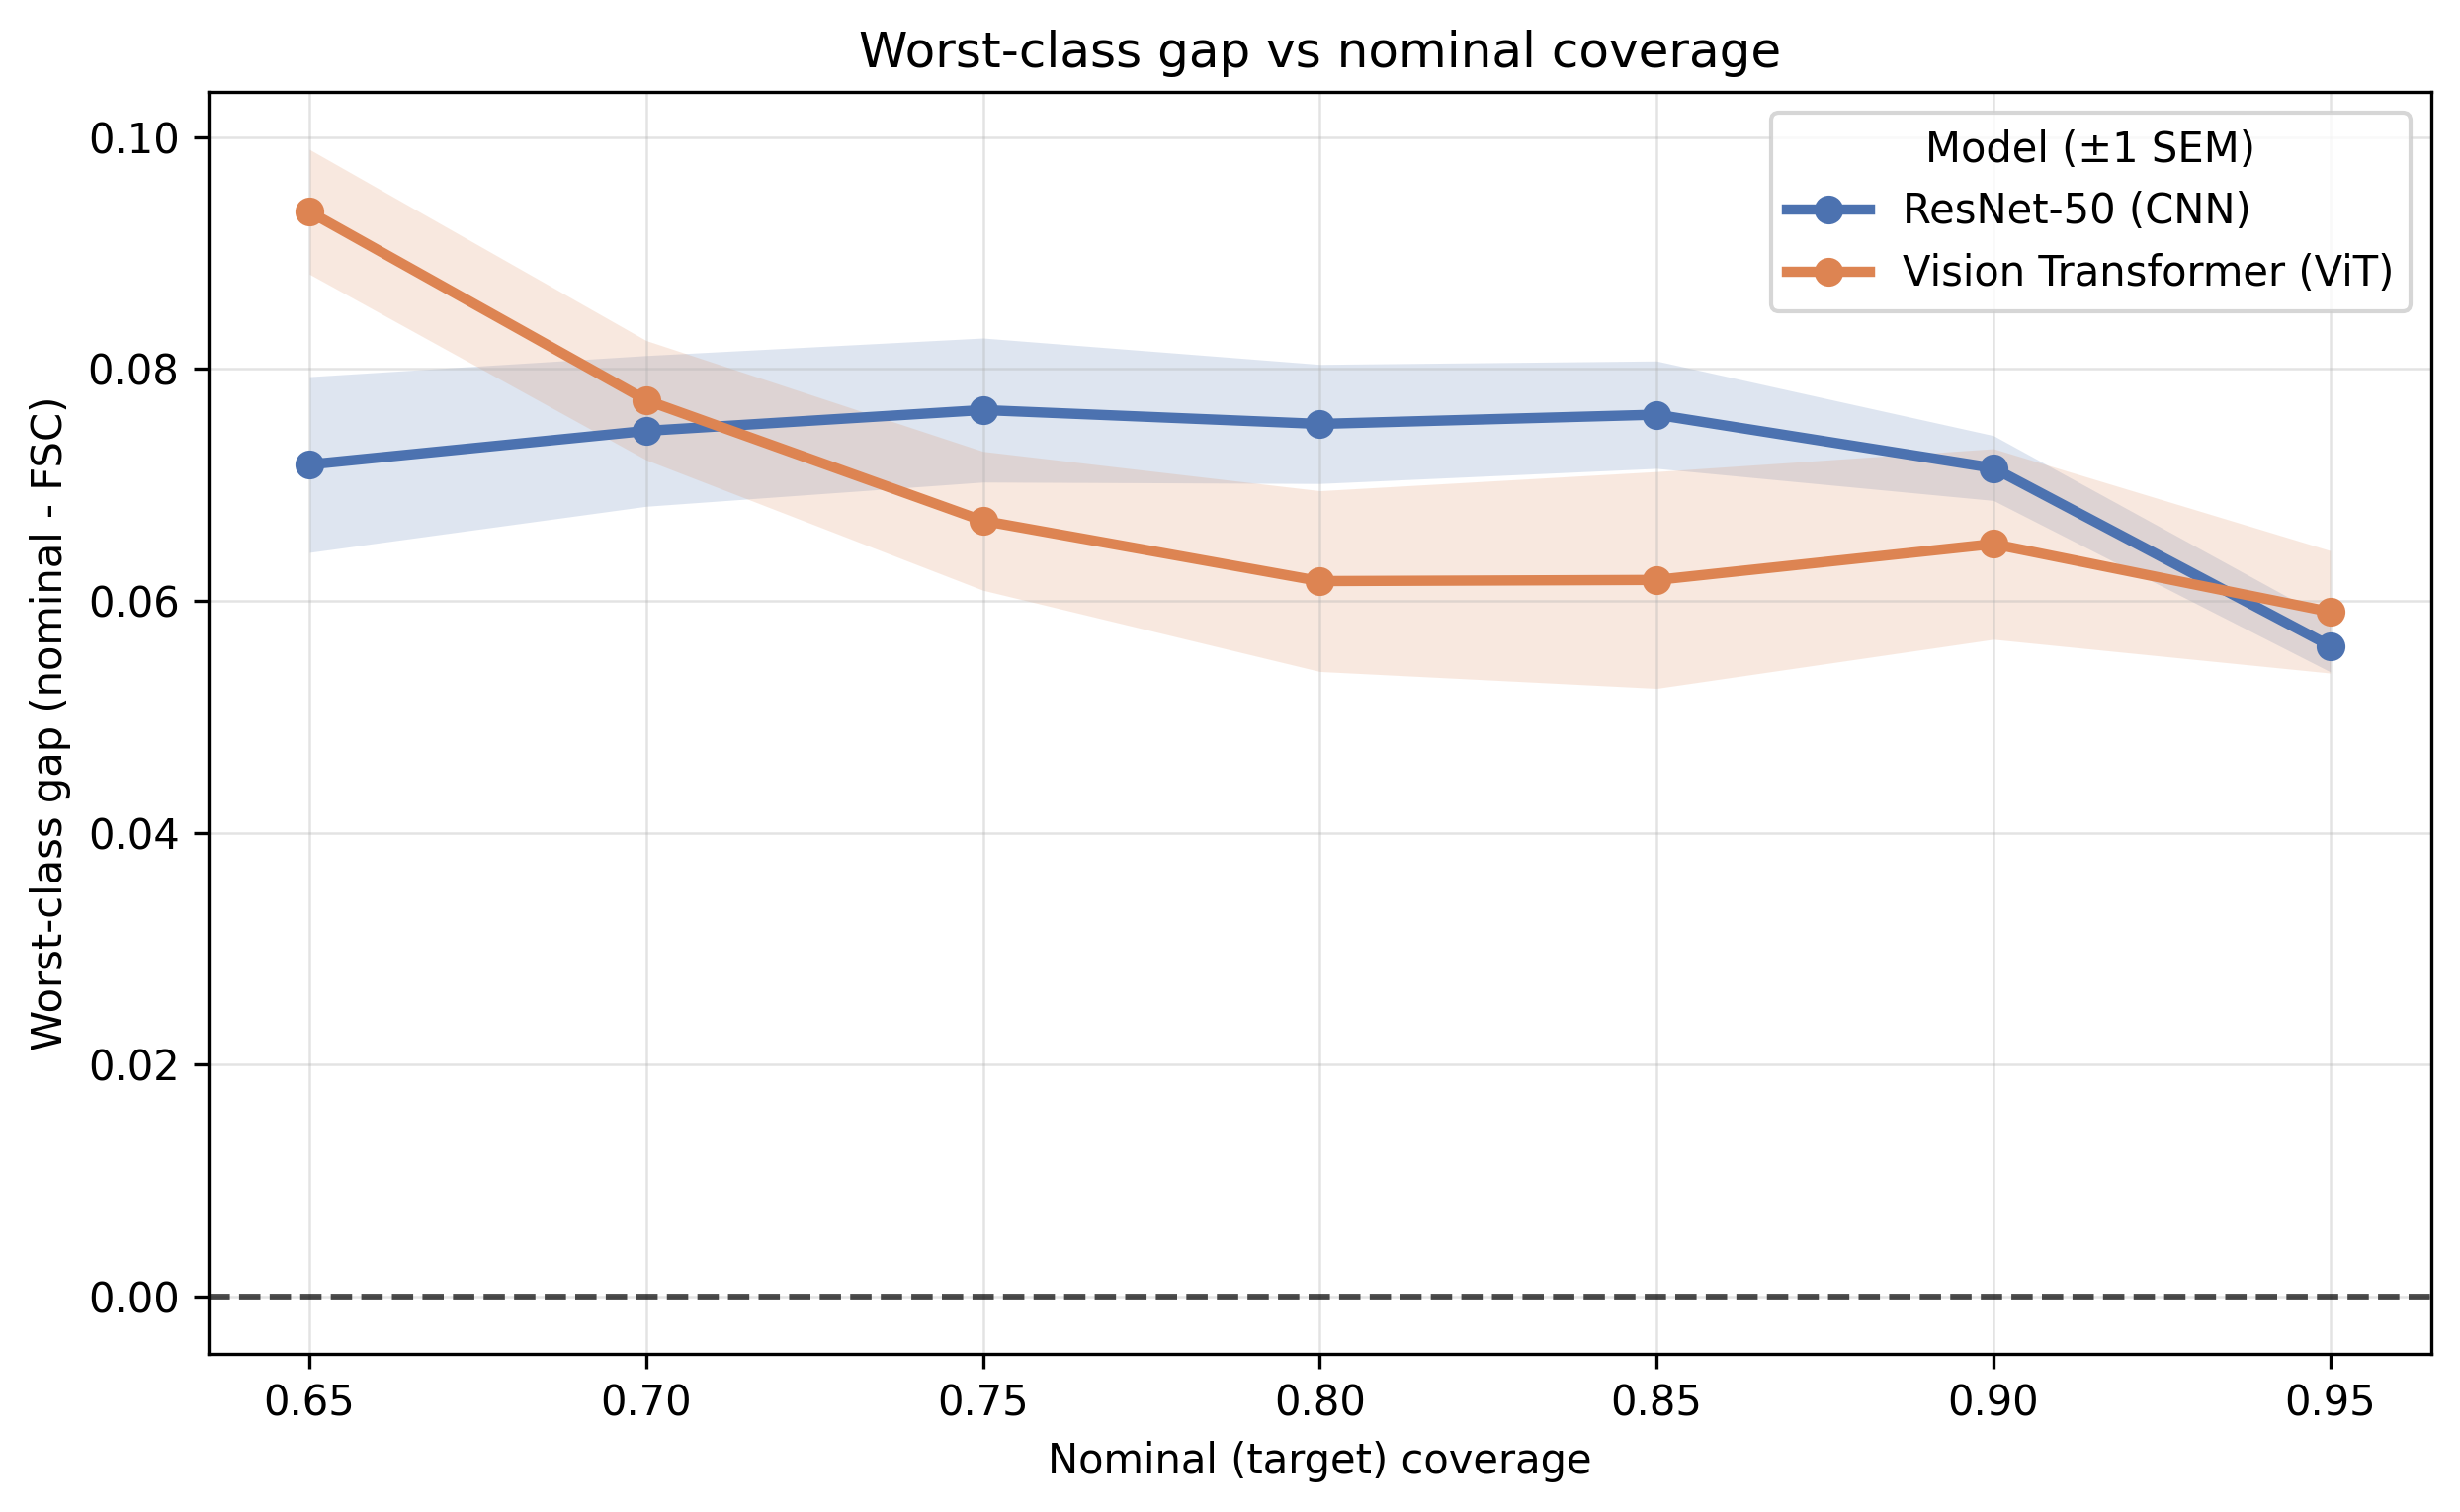

In [7]:
plot_worst_class_gap_vs_nominal_no_dedupe(class_df, out_path="paper_plots/worst_gap.png", band="sem")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import Optional, Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def plot_classwise_coverage_heatmap(
    class_df,
    model: str,
    target: float = 0.90,
    cmap: str = "viridis",


    figsize: Tuple[float, float] = (14, 6),
    dpi: int = 300,


    class_fontsize: int = 8,       
    run_fontsize: int = 10,       
    xlabel_fontsize: int = 11,
    ylabel_fontsize: int = 11,
    title_fontsize: int = 13,
    cbar_label_fontsize: int = 11,
    cbar_tick_fontsize: int = 9,


    xlabel: str = "Experimental Runs",#"test_run",
    ylabel: str = "Disease Classes",
    title: Optional[str] = None,


    grid: bool = True,
    grid_linewidth: float = 0.5,
    grid_color: str = "white",
    grid_alpha: float = 0.8,


    tight_layout: bool = True,
    layout_pad: float = 0.5,


    out_path: Optional[str] = None,
):
    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[(d["model"] == model) &
          (d["target_coverage"] == round(float(target), 2))].copy()

    if d.empty:
        raise ValueError(f"No data for model={model}, target={target}")

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)

    mat = d.pivot_table(
        index="class_name",
        columns="run",
        values="class_coverage",
        aggfunc="mean"
    )


    mat = mat.loc[mat.mean(axis=1).sort_values().index]


    mat = mat.reindex(sorted(mat.columns), axis=1)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    im = ax.imshow(mat.values, aspect="auto", cmap=cmap)


    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns, fontsize=run_fontsize, rotation=45, ha="right")

    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index, fontsize=class_fontsize)


    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)

    if title is None:
        title = f"{model}: class-wise coverage heatmap @ target={target:.2f}"
    ax.set_title(title, fontsize=title_fontsize)

  
    if grid:
        ax.set_xticks(np.arange(-0.5, mat.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, mat.shape[0], 1), minor=True)
        ax.grid(
            which="minor",
            color=grid_color,
            linewidth=grid_linewidth,
            alpha=grid_alpha
        )
        ax.tick_params(which="minor", bottom=False, left=False)


    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Class-wise coverage", fontsize=cbar_label_fontsize)
    cbar.ax.tick_params(labelsize=cbar_tick_fontsize)

    if tight_layout:
        plt.tight_layout(pad=layout_pad)

    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()


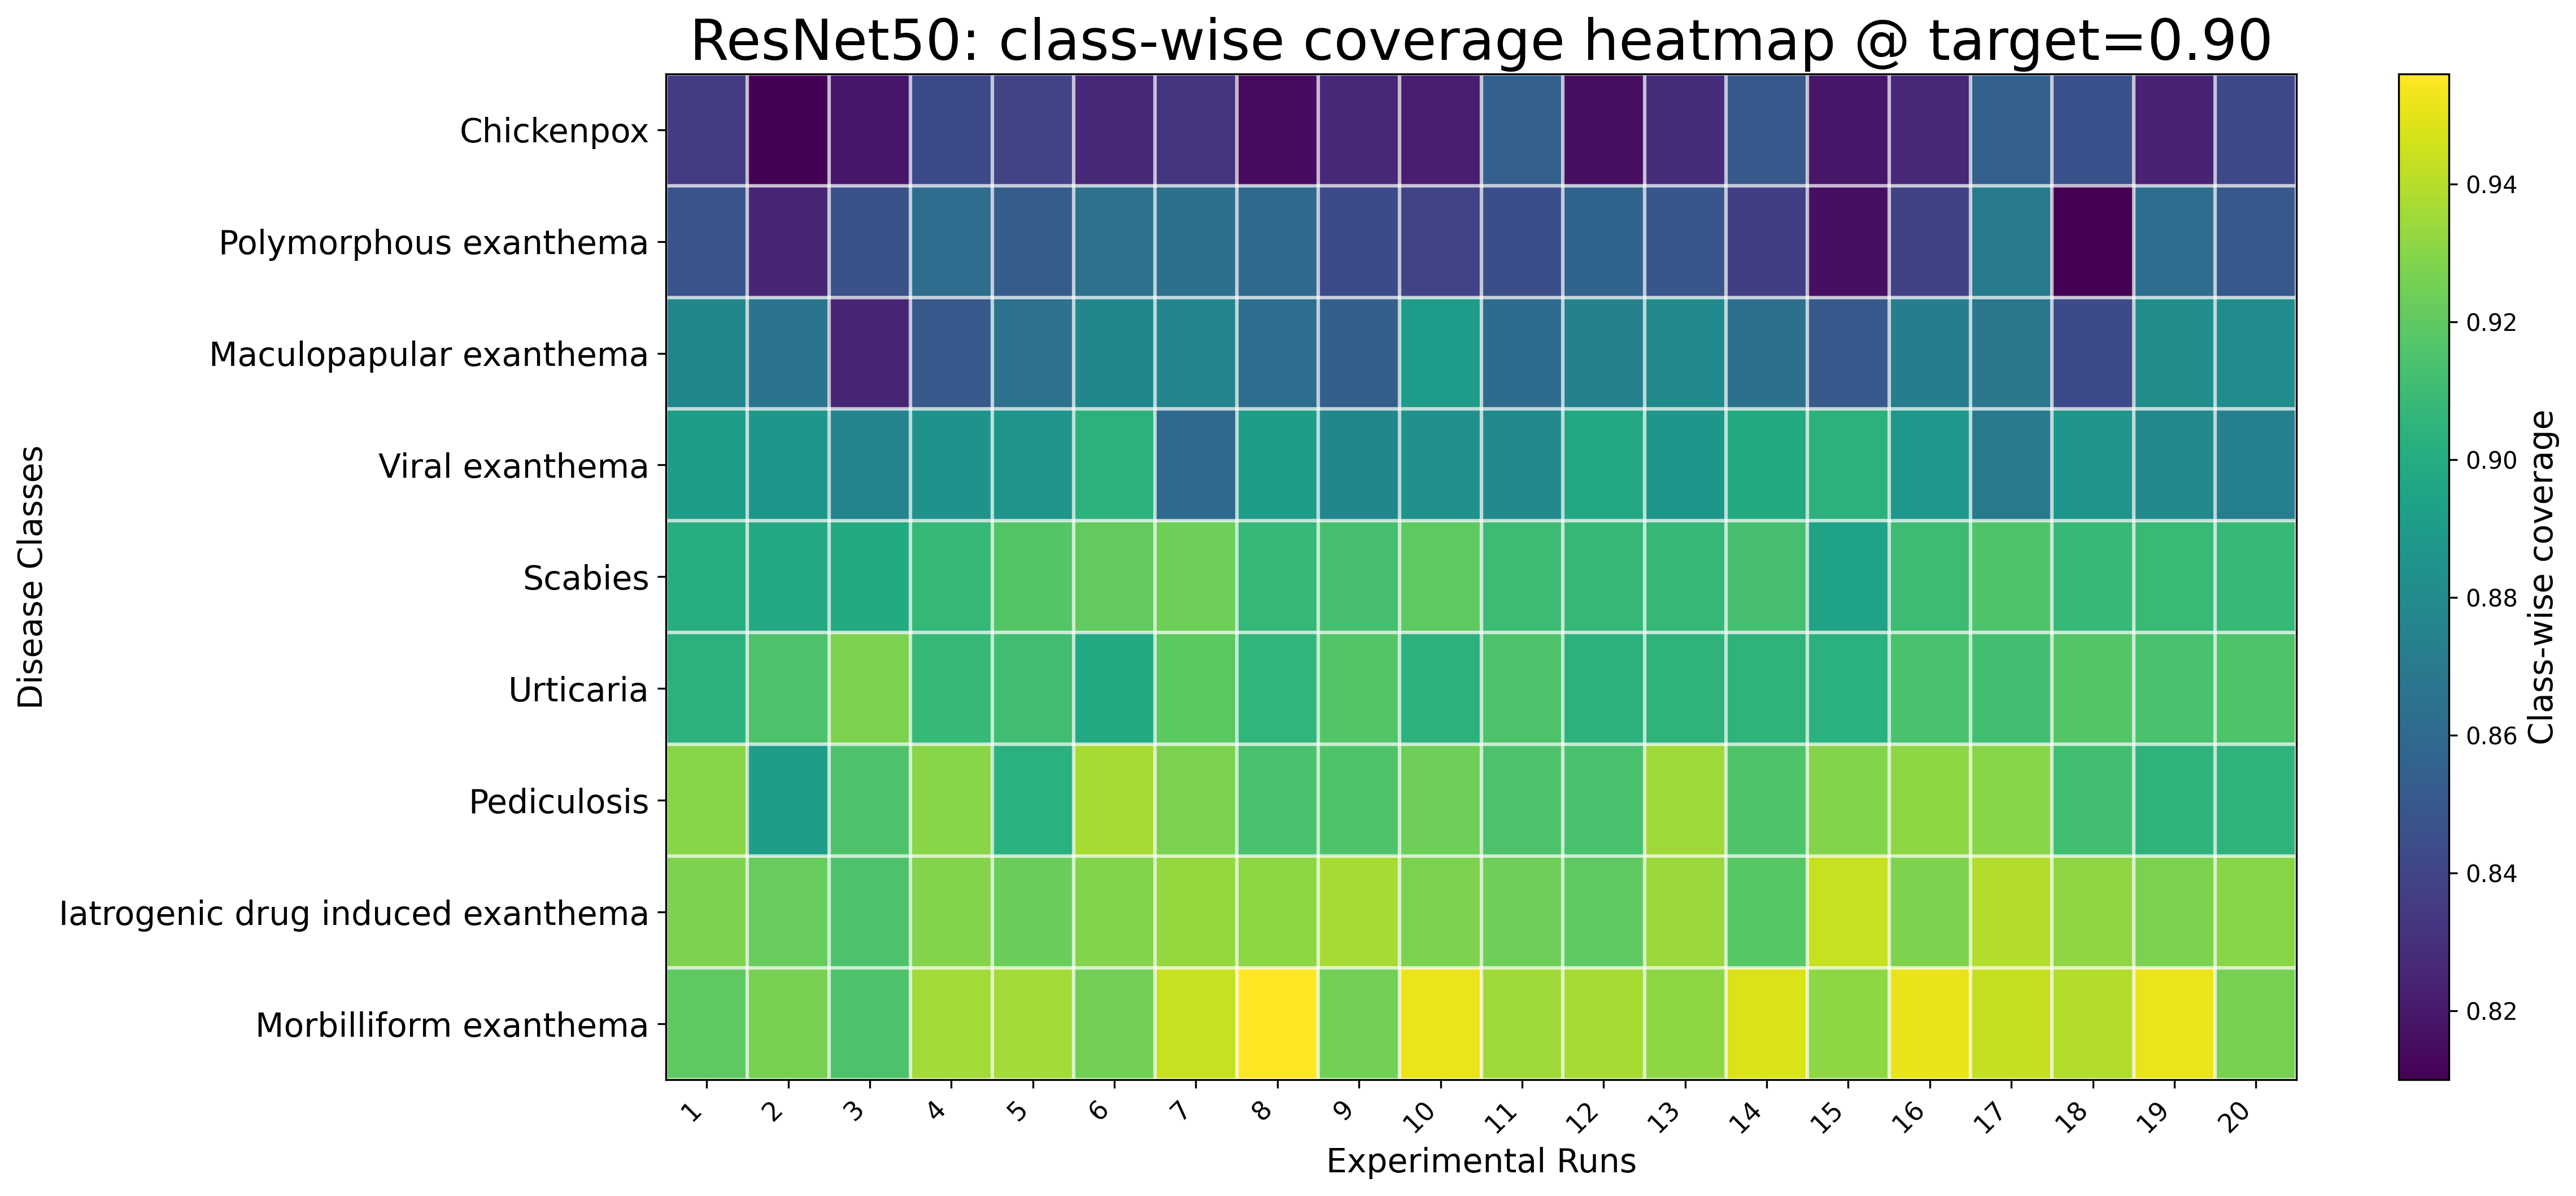

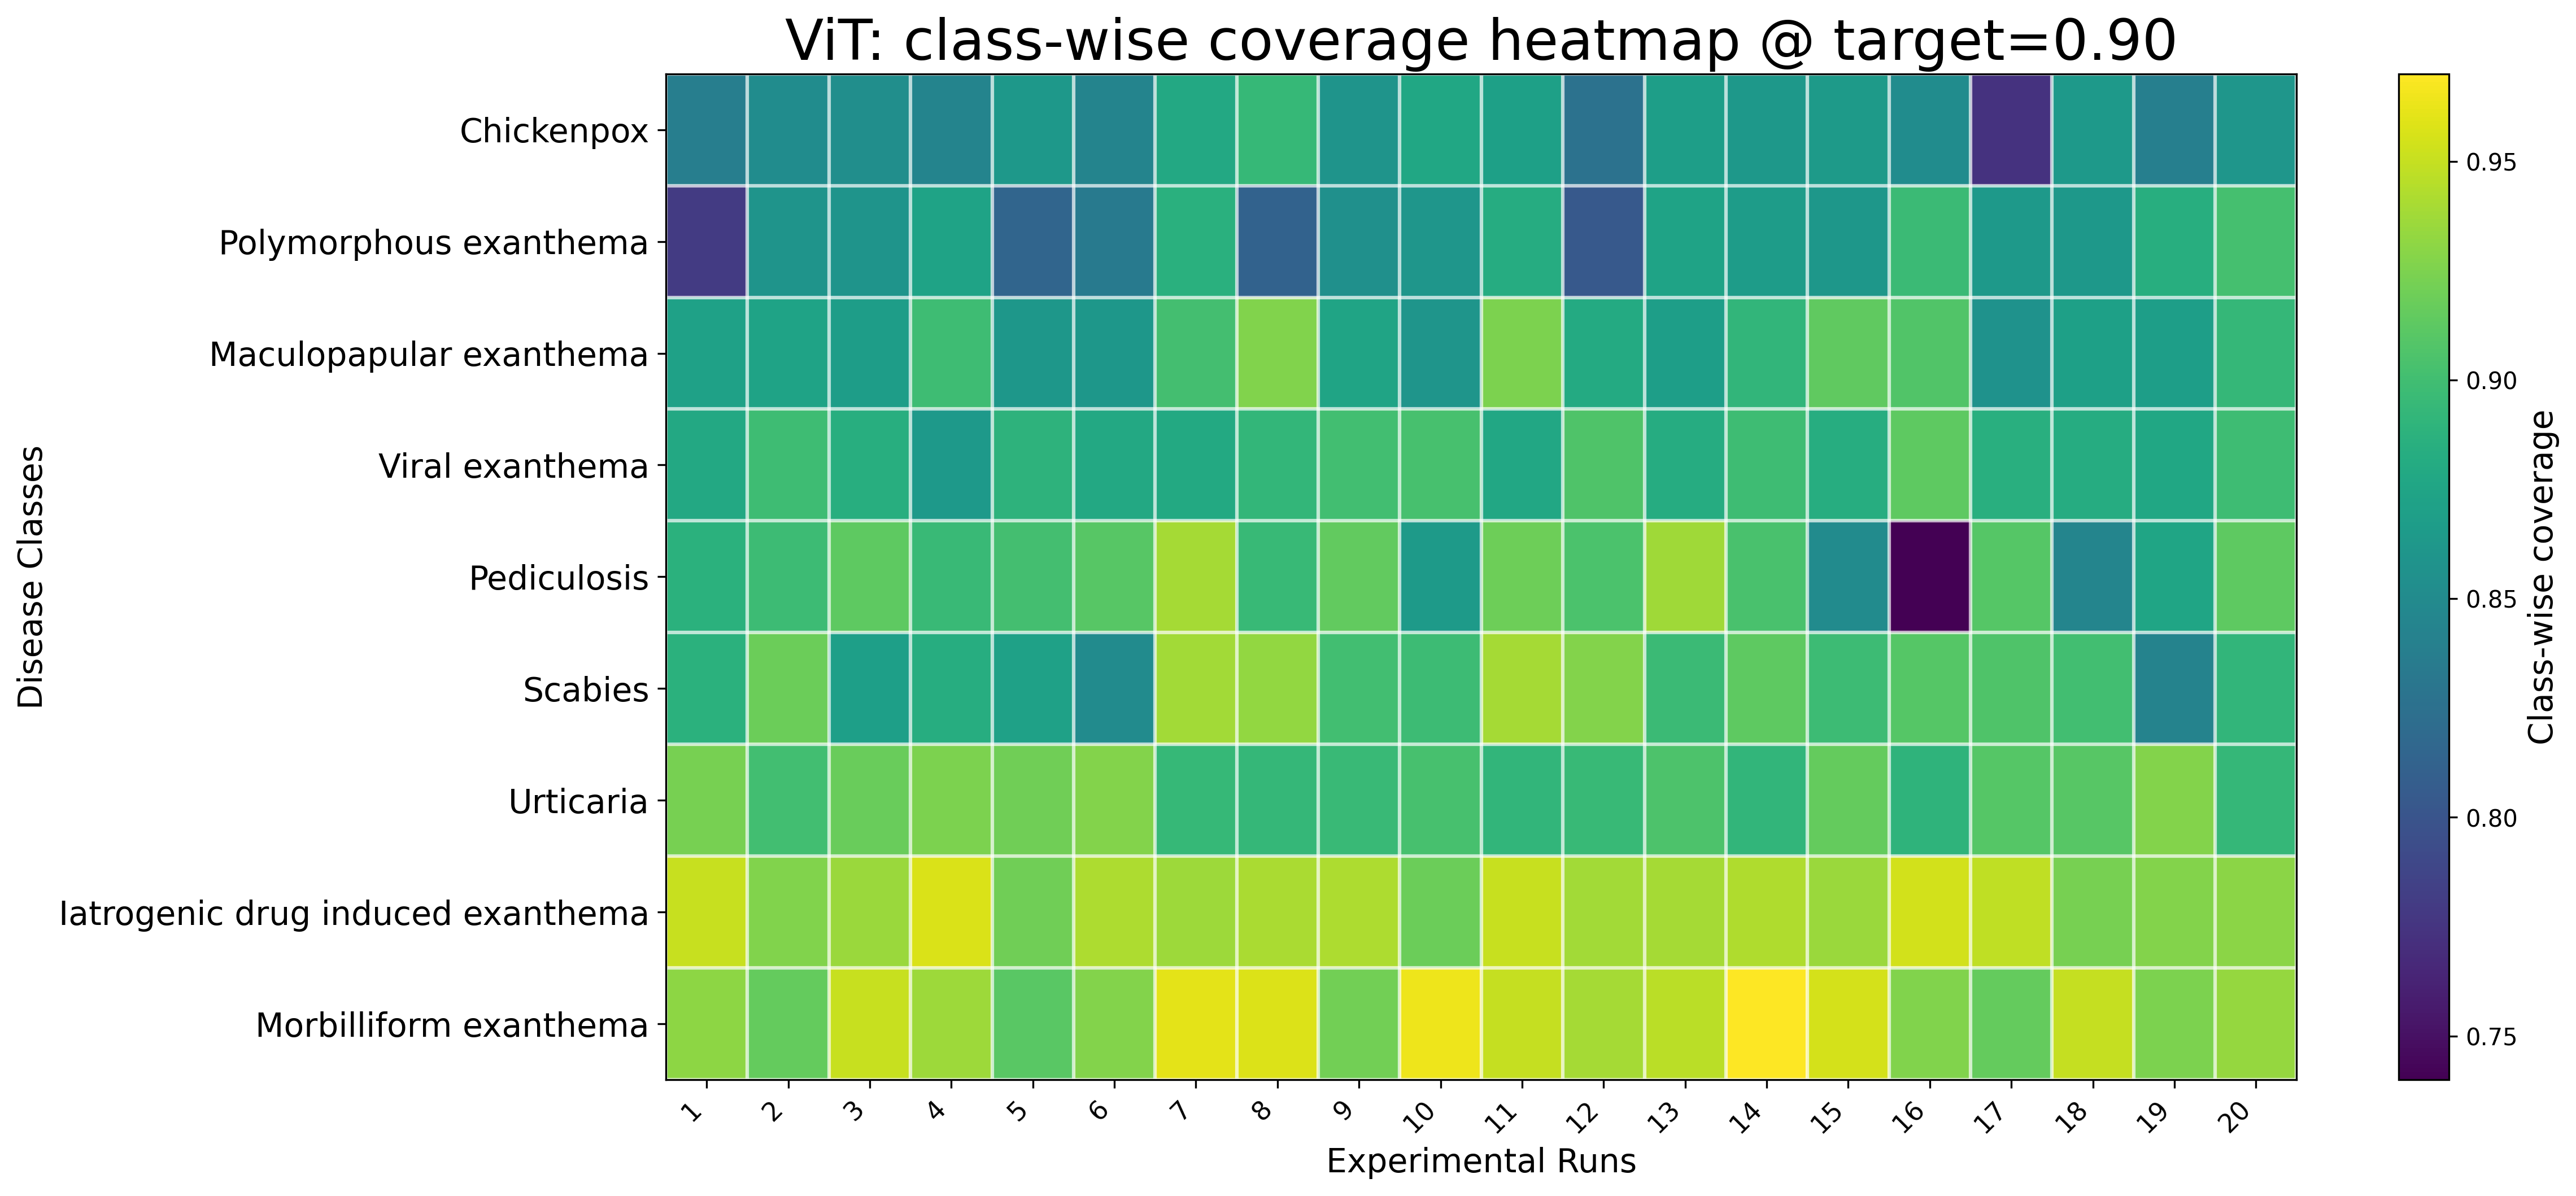

In [ ]:
plot_classwise_coverage_heatmap(
    class_df,
    model="ResNet50",
    target=0.90,
    figsize=(16, 7),
    class_fontsize=14,
    run_fontsize=11,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    title_fontsize=24,
    cbar_label_fontsize=14,
    cbar_tick_fontsize=10,
    out_path="08_heatmap_ResNet50_target_0.90.png",
    grid=True,
grid_linewidth=1.5,
grid_color="white",
grid_alpha=0.7,

)

plot_classwise_coverage_heatmap(
    class_df,
    model="ViT",
    target=0.90,
    figsize=(16, 7),
    class_fontsize=14,
    run_fontsize=11,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    title_fontsize=24,
    cbar_label_fontsize=14,
    cbar_tick_fontsize=10,
    out_path="08_heatmap_ViT_target_0.90.png",
    grid=True,
grid_linewidth=1.5,
grid_color="white",
grid_alpha=0.7,

)

# delta_table = per_class_delta_coverage_plots_all_classes(
#     class_df=class_df,
#     target=0.90,
#     resnet_name="ResNet50",
#     vit_name="ViT",
#     figsize_heatmap=(18, 4.3),
#     figsize_bar=(18, 7.0),
#     class_fontsize=14,
#     annotate_fontsize=18,
#     y_label_fontsize=12,
#     heatmap_ylabel_fontsize=16,
#     title_fontsize=24,
#     grid=True,
#     grid_axis_heatmap="both",
#     grid_axis_bar="both",
#     grid_linewidth=1.8,
#     grid_alpha=0.35,
#     annotate_as_percent=True,  
#     percent_decimals=2,
# )





In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def per_class_delta_coverage_plots_from_class_df(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    class_fontsize: int = 6,
    annotate_fontsize: int = 8,
    figsize_heatmap=(14, 2.6),
    figsize_bar=(14, 4.5),
):

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["class_coverage"] = d["class_coverage"].astype(float)
    d["class_name"] = d["class_name"].map(normalize_class_name)

    t = round(float(target), 2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows found for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )

    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )


    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")


    if resnet_name not in piv.columns or vit_name not in piv.columns:
        raise ValueError(
            f"Expected both models in data. Found models: {list(piv.columns)}"
        )

    common = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()


    common["delta"] = common[vit_name] - common[resnet_name]


    common_sorted = common.sort_values("delta", ascending=False)

    print(f"Per-class Δ coverage ({vit_name} - {resnet_name}) at target={t:.2f}, sorted:")
    for cls, row in common_sorted.iterrows():
        print(f"{cls:40s}: {row['delta']:+.4f}  ({vit_name} {row[vit_name]:.3f} vs {resnet_name} {row[resnet_name]:.3f})")

    class_names = common_sorted.index.tolist()
    deltas = common_sorted["delta"].values


    values = deltas.reshape(1, -1)

    plt.figure(figsize=figsize_heatmap)
    im = plt.imshow(values, aspect="auto")  

    plt.xticks(
        ticks=np.arange(len(class_names)),
        labels=class_names,
        rotation=45,
        ha="right",
        fontsize=class_fontsize
    )
    plt.yticks([0], [f"Δ coverage ({vit_name} - {resnet_name})"])
    plt.colorbar(im, label="Δ coverage")


    for j, v in enumerate(deltas):
        plt.text(j, 0, f"{v:+.3f}", ha="center", va="center", fontsize=annotate_fontsize)

    plt.title(f"Per-class Improvement in Coverage ({vit_name} - {resnet_name}) @ target={t:.2f}")
    plt.tight_layout()
    plt.show()


    x = np.arange(len(class_names))

    plt.figure(figsize=figsize_bar)
    plt.bar(x, deltas)
    plt.axhline(0.0)

    for xi, v in zip(x, deltas):
        plt.annotate(
            f"{v:+.3f}",
            xy=(xi, v),
            xytext=(0, 3 if v >= 0 else -11),
            textcoords="offset points",
            ha="center",
            va="bottom" if v >= 0 else "top",
            fontsize=annotate_fontsize
        )

    plt.xticks(x, class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})")
    plt.title(f"Per-class Δ Coverage: Positive = {vit_name} better, Negative = {resnet_name} better @ target={t:.2f}")
    plt.tight_layout()
    plt.show()

    return common_sorted  


Per-class Δ coverage (ViT - ResNet50) at target=0.90, sorted:
Chickenpox                              : +0.0227  (ViT 0.854 vs ResNet50 0.832)
Maculopapular exanthema                 : +0.0178  (ViT 0.884 vs ResNet50 0.866)
Polymorphous exanthema                  : +0.0096  (ViT 0.857 vs ResNet50 0.847)
Iatrogenic drug induced exanthema       : +0.0093  (ViT 0.938 vs ResNet50 0.928)
Viral exanthema                         : +0.0033  (ViT 0.889 vs ResNet50 0.885)
Morbilliform exanthema                  : +0.0029  (ViT 0.939 vs ResNet50 0.936)
Urticaria                               : -0.0044  (ViT 0.906 vs ResNet50 0.911)
Scabies                                 : -0.0107  (ViT 0.899 vs ResNet50 0.909)
Pediculosis                             : -0.0281  (ViT 0.891 vs ResNet50 0.919)


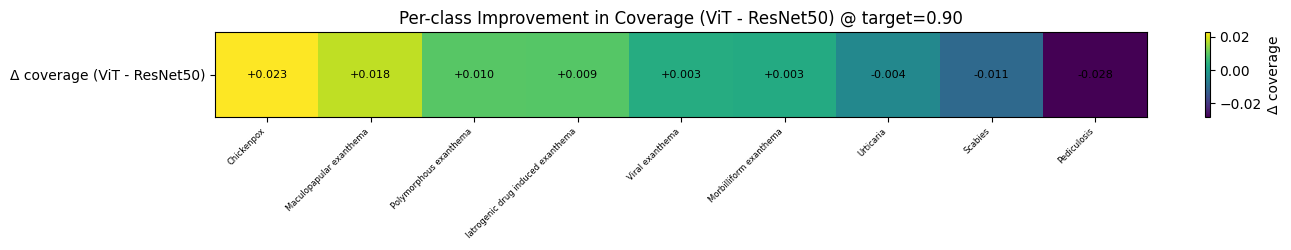

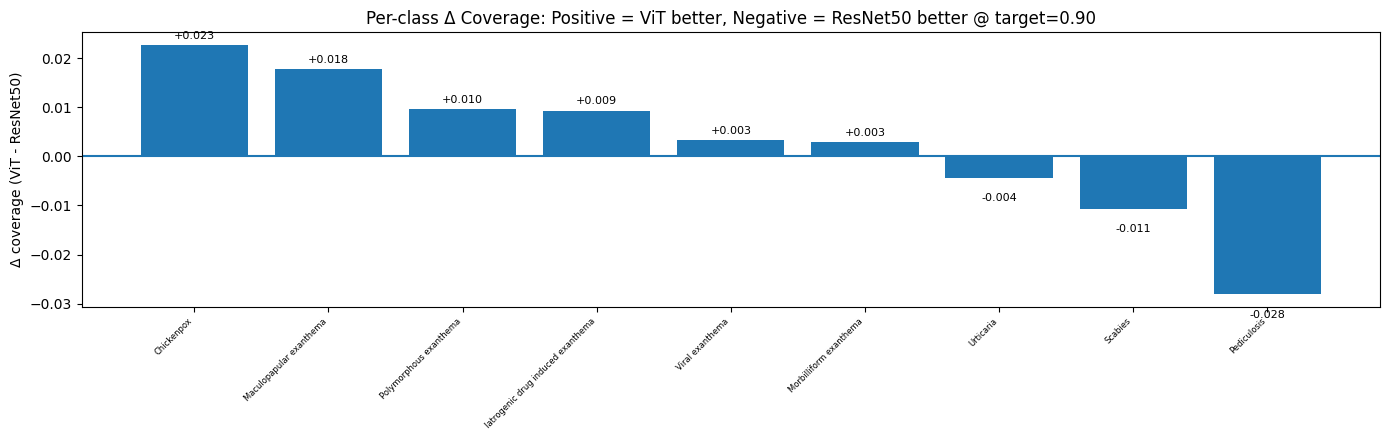

In [15]:
delta_table = per_class_delta_coverage_plots_from_class_df(
    class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    class_fontsize=6
)


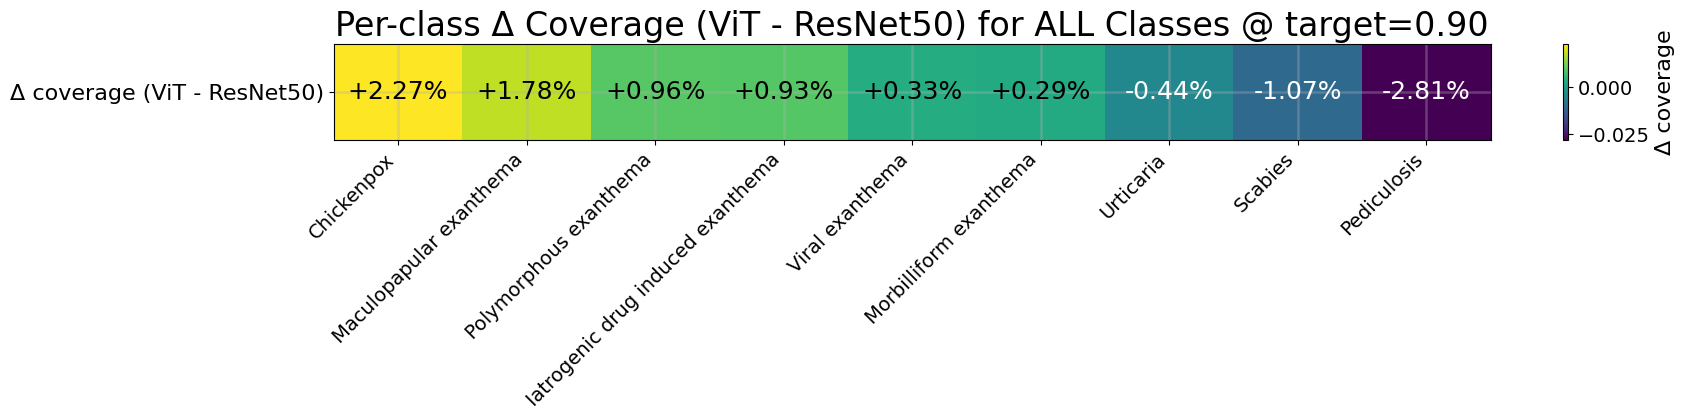

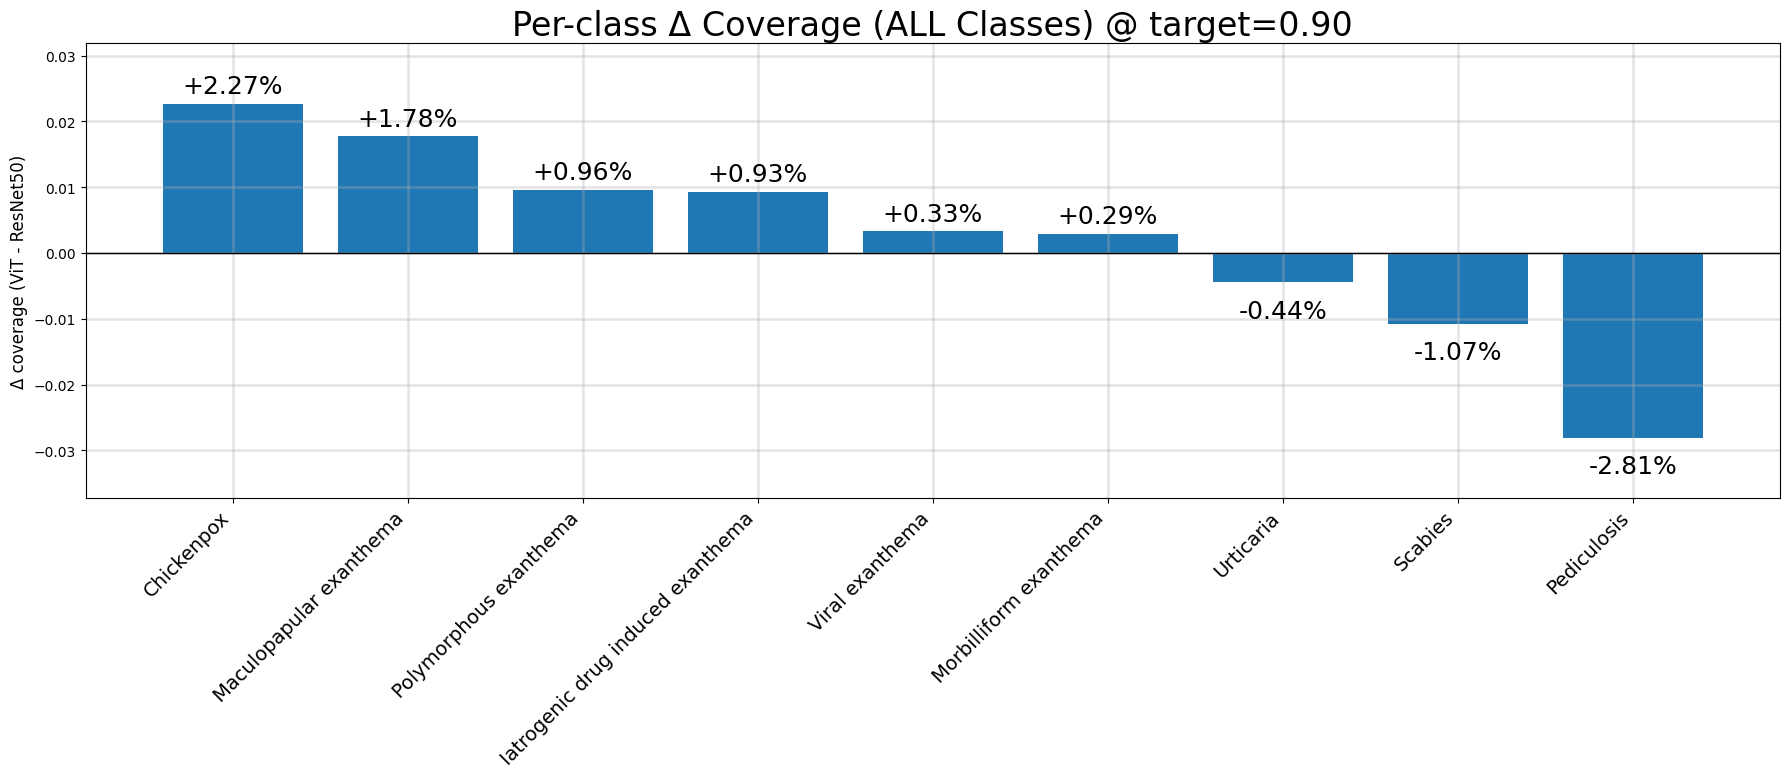

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def per_class_delta_coverage_plots_all_classes(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",

    class_fontsize: int = 8,            
    annotate_fontsize: int = 10,      
    y_label_fontsize: int = 11,        
    heatmap_ylabel_fontsize: int = 11, 
    title_fontsize: int = 11,          

    figsize_heatmap: Tuple[float, float] = (14, 3.0),
    figsize_bar: Tuple[float, float] = (14, 6.5),

    grid: bool = True,
    grid_axis_heatmap: str = "both",    
    grid_axis_bar: str = "both",      
    grid_linewidth: float = 0.8,
    grid_alpha: float = 0.35,

    annotate_as_percent: bool = True,    
    percent_decimals: int = 2,            
    value_decimals: int = 3,           
    sort_descending: bool = True,       
):


    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["class_coverage"] = d["class_coverage"].astype(float)
    d["class_name"] = d["class_name"].map(normalize_class_name)

    t = round(float(target), 2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows found for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")


    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")

    common = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()
    common["delta"] = common[vit_name] - common[resnet_name]

    common_sorted = common.sort_values("delta", ascending=not sort_descending)

    class_names = common_sorted.index.tolist()
    deltas = common_sorted["delta"].values
    deltas_pct = deltas * 100.0


    plt.figure(figsize=figsize_heatmap)
    im = plt.imshow(deltas.reshape(1, -1), aspect="auto")
    norm = im.norm 

    if grid:
        plt.grid(True, axis=grid_axis_heatmap, linewidth=grid_linewidth, alpha=grid_alpha)

    plt.xticks(
        np.arange(len(class_names)),
        class_names,
        rotation=45,
        ha="right",
        fontsize=class_fontsize
    )
    plt.yticks(
        [0],
        [f"Δ coverage ({vit_name} - {resnet_name})"],
        fontsize=heatmap_ylabel_fontsize
    )

    cbar = plt.colorbar(im)
    cbar.set_label("Δ coverage", fontsize=heatmap_ylabel_fontsize)
    cbar.ax.tick_params(labelsize=class_fontsize)

    for j, (v_abs, v_pct) in enumerate(zip(deltas, deltas_pct)):
        color_val = norm(v_abs)
        text_color = "white" if color_val <= 0.6 else "black"

        if annotate_as_percent:
            txt = f"{v_pct:+.{percent_decimals}f}%"
        else:
            txt = f"{v_abs:+.{value_decimals}f}"

        plt.text(
            j, 0,
            txt,
            ha="center",
            va="center",
            fontsize=annotate_fontsize,
            color=text_color
        )

    plt.title(
        f"Per-class Δ Coverage ({vit_name} - {resnet_name}) for ALL Classes @ target={t:.2f}",
        fontsize=title_fontsize
    )
    plt.tight_layout()
    plt.show()


    x = np.arange(len(class_names))
    plt.figure(figsize=figsize_bar)

    plt.bar(x, deltas)
    plt.axhline(0.0, color="black", linewidth=1)

    if grid:
        plt.grid(True, axis=grid_axis_bar, linewidth=grid_linewidth, alpha=grid_alpha)

    plt.margins(y=0.18)

    for xi, v_abs, v_pct in zip(x, deltas, deltas_pct):
        if annotate_as_percent:
            txt = f"{v_pct:+.{percent_decimals}f}%"
        else:
            txt = f"{v_abs:+.{value_decimals}f}"

        plt.annotate(
            txt,
            (xi, v_abs),
            xytext=(0, 4 if v_abs >= 0 else -12),
            textcoords="offset points",
            ha="center",
            va="bottom" if v_abs >= 0 else "top",
            fontsize=annotate_fontsize
        )

    plt.xticks(x, class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})", fontsize=y_label_fontsize)
    plt.title(
        f"Per-class Δ Coverage (ALL Classes) @ target={t:.2f}",
        fontsize=title_fontsize
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.28)
    plt.show()

    return common_sorted
delta_table = per_class_delta_coverage_plots_all_classes(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    figsize_heatmap=(18, 4.3),
    figsize_bar=(18, 7.0),
    class_fontsize=14,
    annotate_fontsize=18,
    y_label_fontsize=12,
    heatmap_ylabel_fontsize=16,
    title_fontsize=24,
    grid=True,
    grid_axis_heatmap="both",
    grid_axis_bar="both",
    grid_linewidth=1.8,
    grid_alpha=0.35,
    annotate_as_percent=True,  
    percent_decimals=2,
)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def plot_delta_for_failing_classes(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",   
    sort_by: str = "delta",         
    top_k: Optional[int] = None,    
    class_fontsize: int = 7,
    annotate: bool = True,
    annotate_fontsize: int = 8,
    dpi: int = 300,
    out_path: Optional[str] = None,
):
    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")

    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")

    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()


    res_fail = piv[resnet_name] < t
    vit_fail = piv[vit_name] < t

    if failing_rule == "either":
        fail = piv[res_fail | vit_fail].copy()
        rule_text = "failing in either model"
    elif failing_rule == "both":
        fail = piv[res_fail & vit_fail].copy()
        rule_text = "failing in both models"
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if fail.empty:
        print(f"No failing classes found at target={t:.2f} with rule='{failing_rule}'.")
        return fail


    fail["delta"] = fail[vit_name] - fail[resnet_name]
    fail["gap_resnet"] = t - fail[resnet_name]
    fail["gap_vit"] = t - fail[vit_name]
    fail["gap_max"] = np.maximum(fail["gap_resnet"], fail["gap_vit"])
    fail["min_cov"] = fail[[resnet_name, vit_name]].min(axis=1)


    if sort_by == "delta":
        fail = fail.sort_values("delta", ascending=False)
    elif sort_by == "gap_max":
        fail = fail.sort_values("gap_max", ascending=False)
    elif sort_by == "min_cov":
        fail = fail.sort_values("min_cov", ascending=True)
    elif sort_by == "name":
        fail = fail.sort_index()
    else:
        raise ValueError("sort_by must be one of: delta, gap_max, min_cov, name")


    if top_k is not None:
        fail = fail.head(int(top_k)).copy()

    classes = fail.index.tolist()
    deltas = fail["delta"].values
    x = np.arange(len(classes))

    plt.figure(figsize=(max(12, 0.55 * len(classes)), 4.8), dpi=dpi)
    plt.bar(x, deltas)

    plt.axhline(0.0, linewidth=1.2, color="black", alpha=0.8)

    if annotate:
        for xi, v in zip(x, deltas):
            plt.annotate(
                f"{v:+.3f}",
                xy=(xi, v),
                xytext=(0, 3 if v >= 0 else -11),
                textcoords="offset points",
                ha="center",
                va="bottom" if v >= 0 else "top",
                fontsize=annotate_fontsize
            )

    plt.xticks(x, classes, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})")
    plt.title(f"Δ coverage for failing classes @ nominal={t:.2f} ({rule_text})")
    plt.grid(True, axis="y", linewidth=0.6, alpha=0.35)
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return fail


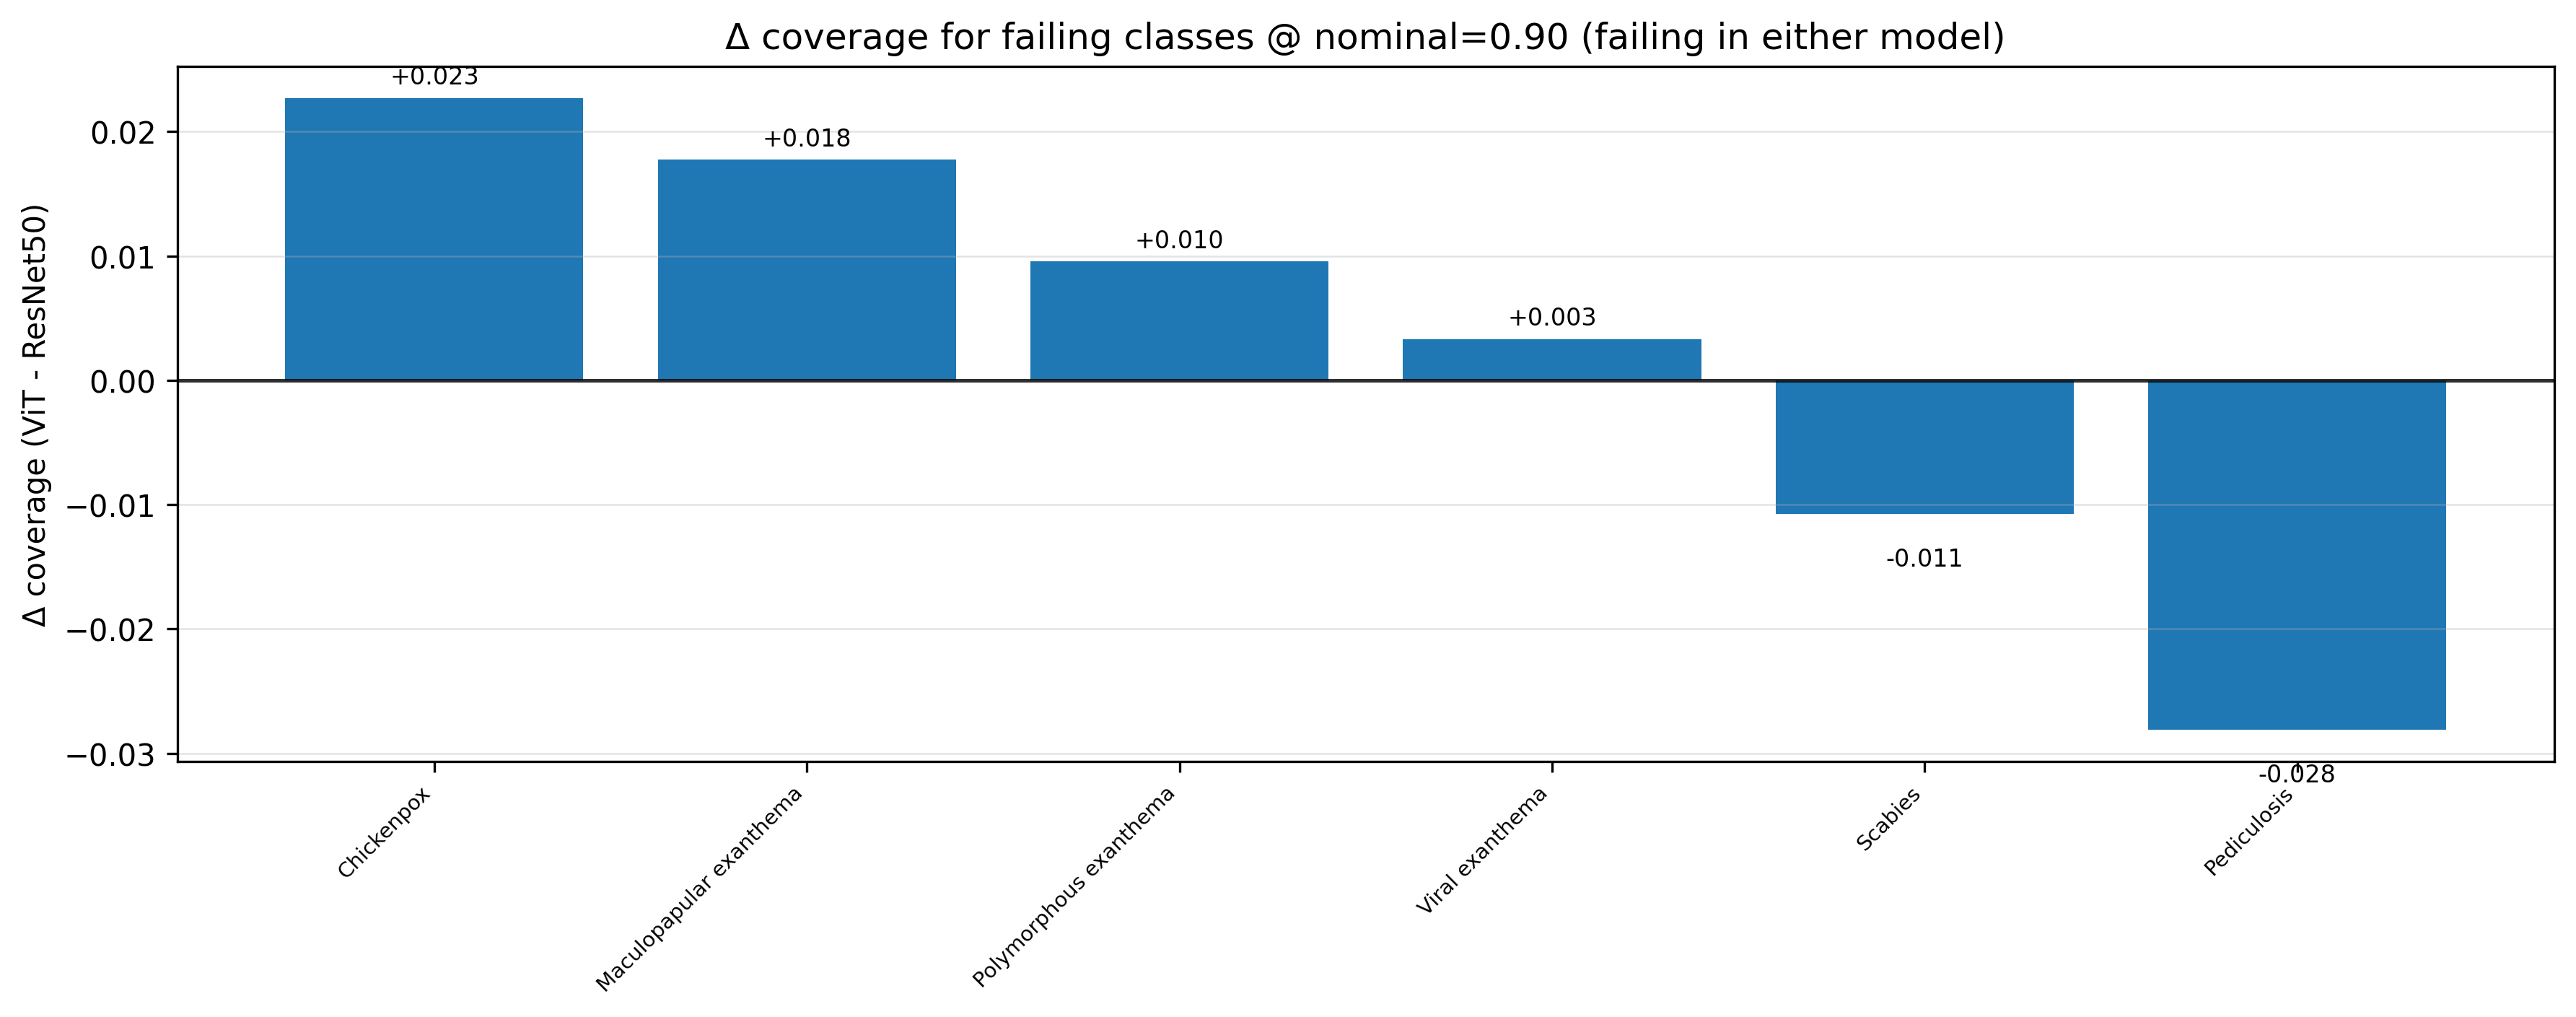

In [18]:
fail_tbl = plot_delta_for_failing_classes(
    class_df,
    target=0.90,
    failing_rule="either",
    sort_by="delta",
    out_path="paper_plots/delta_failing_classes_target_0p90.png"
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional, Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def plot_delta_for_failing_classes(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",
    sort_by: str = "delta",
    top_k: Optional[int] = None,
    class_fontsize: int = 7,
    annotate: bool = True,
    annotate_fontsize: int = 10,
    figsize: Optional[Tuple[float, float]] = None,  
    title_fontsize: int = 11,                      
    dpi: int = 300,
    out_path: Optional[str] = None,
    y_label_size: int = 11
):
    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)

    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")

    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")

    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()

    res_fail = piv[resnet_name] < t
    vit_fail = piv[vit_name] < t

    if failing_rule == "either":
        fail = piv[res_fail | vit_fail].copy()
        rule_text = "failing in either model"
    elif failing_rule == "both":
        fail = piv[res_fail & vit_fail].copy()
        rule_text = "failing in both models"
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if fail.empty:
        print(f"No failing classes found at target={t:.2f} with rule='{failing_rule}'.")
        return fail

    fail["delta"] = fail[vit_name] - fail[resnet_name]
    fail["gap_resnet"] = t - fail[resnet_name]
    fail["gap_vit"] = t - fail[vit_name]
    fail["gap_max"] = np.maximum(fail["gap_resnet"], fail["gap_vit"])
    fail["min_cov"] = fail[[resnet_name, vit_name]].min(axis=1)

    if sort_by == "delta":
        fail = fail.sort_values("delta", ascending=False)
    elif sort_by == "gap_max":
        fail = fail.sort_values("gap_max", ascending=False)
    elif sort_by == "min_cov":
        fail = fail.sort_values("min_cov", ascending=True)
    elif sort_by == "name":
        fail = fail.sort_index()
    else:
        raise ValueError("sort_by must be one of: delta, gap_max, min_cov, name")

    if top_k is not None:
        fail = fail.head(int(top_k)).copy()

    classes = fail.index.tolist()
    deltas = fail["delta"].values
    x = np.arange(len(classes))

    # ---- figure size handling
    if figsize is None:
        fig_w = max(12, 0.55 * len(classes))
        fig_h = 6.5
        figsize = (fig_w, fig_h)

    plt.figure(figsize=figsize, dpi=dpi)
    plt.bar(x, deltas)
    plt.axhline(0.0, linewidth=1.2, color="black", alpha=0.8)

    plt.grid(True, axis="both", linewidth=0.8, alpha=0.35)

    plt.margins(y=0.18)

    if annotate:
        for xi, v in zip(x, deltas):
            v_pct = v * 100.0
            plt.annotate(
                f"{v_pct:+.1f}%",
                xy=(xi, v),
                xytext=(0, 4 if v >= 0 else -12),
                textcoords="offset points",
                ha="center",
                va="bottom" if v >= 0 else "top",
                fontsize=annotate_fontsize
            )

    plt.xticks(x, classes, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})",
    fontsize=y_label_size)
    plt.title(
        f"Δ coverage for failing classes @ nominal={t:.2f} ({rule_text})",
        fontsize=title_fontsize
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.28)

    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return fail


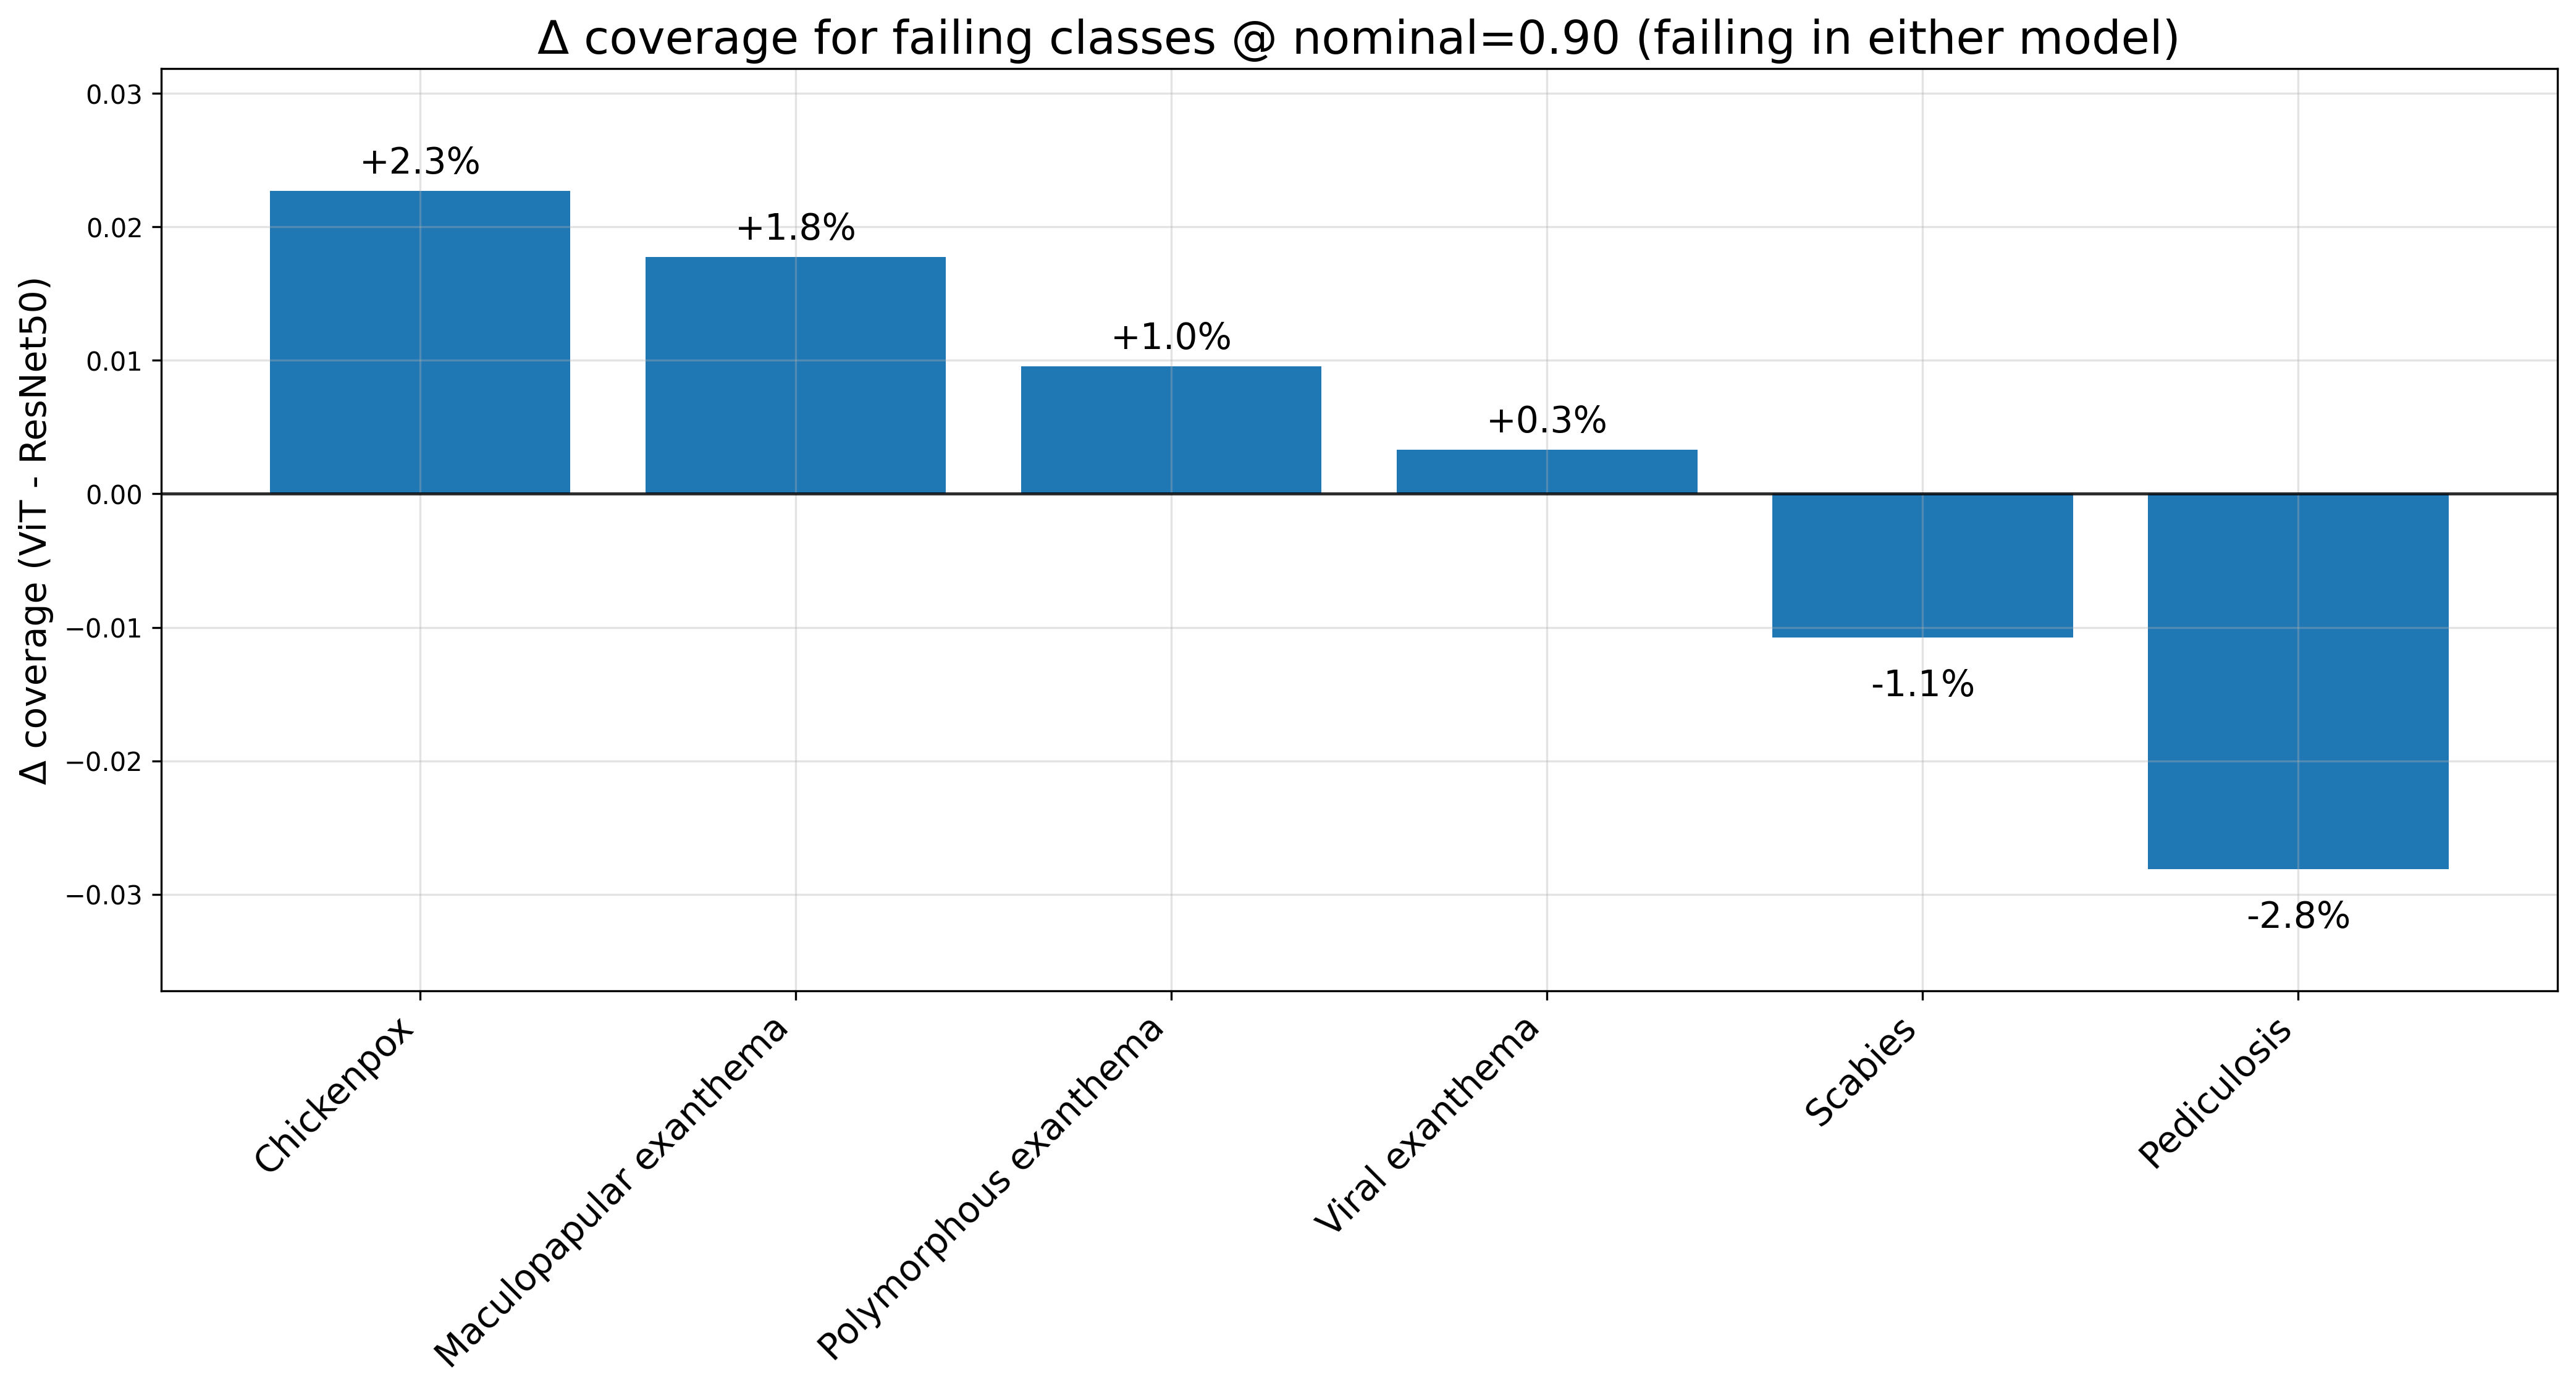

In [20]:
fail_tbl = plot_delta_for_failing_classes(
    class_df,
    target=0.90,
    failing_rule="either",
    sort_by="delta",
    out_path="paper_plots/delta_failing_classes_target_0p90.png",
    class_fontsize=14,
    annotate_fontsize=14,
    figsize=(14, 7.5),
    title_fontsize=18,
    y_label_size=14

)


# delta_table = per_class_delta_coverage_plots_from_class_df(
#     class_df,
#     target=0.90,
#     resnet_name="ResNet50",
#     vit_name="ViT",
#     class_fontsize=14,
#     annotate_fontsize=14,
#     figsize_bar= (14, 7.5)
# )



Classes where at least one model fails @ target=0.90:
Chickenpox                              : +0.0227  (ViT 0.854 vs ResNet50 0.832)
Maculopapular exanthema                 : +0.0178  (ViT 0.884 vs ResNet50 0.866)
Polymorphous exanthema                  : +0.0096  (ViT 0.857 vs ResNet50 0.847)
Viral exanthema                         : +0.0033  (ViT 0.889 vs ResNet50 0.885)
Scabies                                 : -0.0107  (ViT 0.899 vs ResNet50 0.909)
Pediculosis                             : -0.0281  (ViT 0.891 vs ResNet50 0.919)


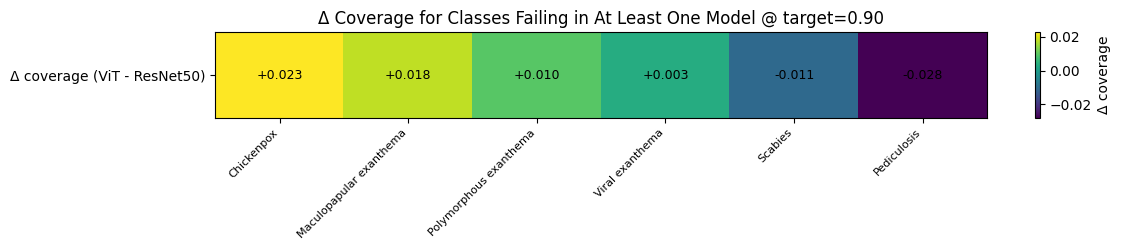

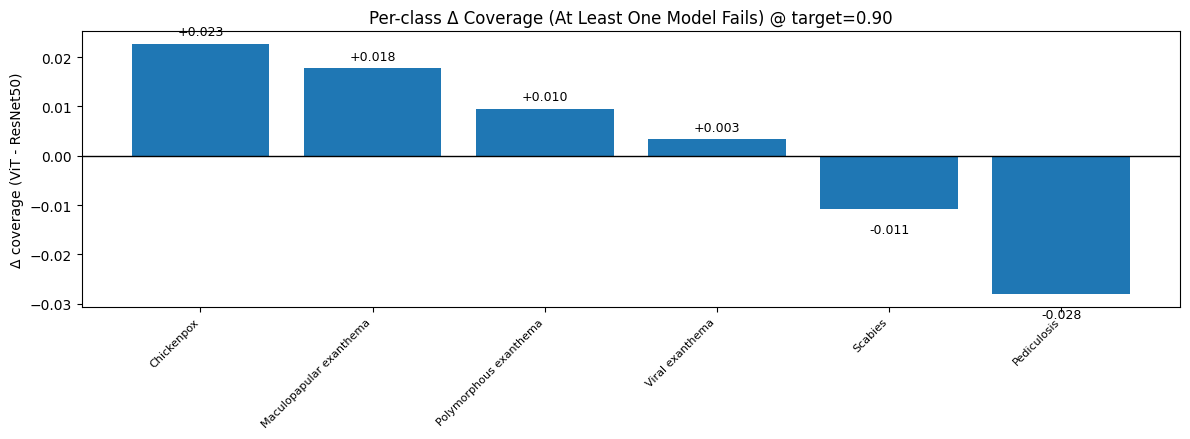

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def per_class_delta_coverage_atleast_one_fails(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    class_fontsize: int = 8,
    annotate_fontsize: int = 9,
    figsize_heatmap=(12, 2.6),
    figsize_bar=(12, 4.5),
):

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")


    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["class_coverage"] = d["class_coverage"].astype(float)
    d["class_name"] = d["class_name"].map(normalize_class_name)

    t = round(float(target), 2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows found for target_coverage={t}")


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(
        index="class_name",
        columns="model",
        values="mean_cov"
    )[[resnet_name, vit_name]].dropna()


    failing = piv[
        (piv[resnet_name] < t) | (piv[vit_name] < t)
    ].copy()

    if failing.empty:
        print(f"No classes fail the nominal threshold in either model at target={t:.2f}.")
        return failing


    failing["delta"] = failing[vit_name] - failing[resnet_name]
    failing = failing.sort_values("delta", ascending=False)

    print(f"\nClasses where at least one model fails @ target={t:.2f}:")
    for cls, row in failing.iterrows():
        print(
            f"{cls:40s}: {row['delta']:+.4f}  "
            f"({vit_name} {row[vit_name]:.3f} vs {resnet_name} {row[resnet_name]:.3f})"
        )

    class_names = failing.index.tolist()
    deltas = failing["delta"].values


    plt.figure(figsize=figsize_heatmap)
    im = plt.imshow(deltas.reshape(1, -1), aspect="auto")
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.yticks([0], [f"Δ coverage ({vit_name} - {resnet_name})"])
    plt.colorbar(im, label="Δ coverage")

    for j, v in enumerate(deltas):
        plt.text(j, 0, f"{v:+.3f}", ha="center", va="center", fontsize=annotate_fontsize)

    plt.title(f"Δ Coverage for Classes Failing in At Least One Model @ target={t:.2f}")
    plt.tight_layout()
    plt.show()


    x = np.arange(len(class_names))
    plt.figure(figsize=figsize_bar)
    plt.bar(x, deltas)
    plt.axhline(0.0, color="black", linewidth=1)

    for xi, v in zip(x, deltas):
        plt.annotate(
            f"{v:+.3f}",
            (xi, v),
            xytext=(0, 4 if v >= 0 else -10),
            textcoords="offset points",
            ha="center",
            va="bottom" if v >= 0 else "top",
            fontsize=annotate_fontsize
        )

    plt.xticks(x, class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})")
    plt.title(f"Per-class Δ Coverage (At Least One Model Fails) @ target={t:.2f}")
    plt.tight_layout()
    plt.show()

    return failing


failing_classes_df = per_class_delta_coverage_atleast_one_fails(
    class_df,
    target=0.90
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional, Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def per_class_delta_coverage_atleast_one_fails(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    class_fontsize: int = 8,
    annotate_fontsize: int = 10,
    y_label_fontsize: int = 11,
    title_fontsize: int = 11,
    figsize_heatmap: Tuple[float, float] = (14, 3.0),
    figsize_bar: Tuple[float, float] = (14, 6.5),
):

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["class_coverage"] = d["class_coverage"].astype(float)
    d["class_name"] = d["class_name"].map(normalize_class_name)

    t = round(float(target), 2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows found for target_coverage={t}")

    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(
        index="class_name",
        columns="model",
        values="mean_cov"
    )[[resnet_name, vit_name]].dropna()


    failing = piv[(piv[resnet_name] < t) | (piv[vit_name] < t)].copy()
    if failing.empty:
        print(f"No classes fail the nominal threshold at target={t:.2f}.")
        return failing

    failing["delta"] = failing[vit_name] - failing[resnet_name]
    failing = failing.sort_values("delta", ascending=False)

    class_names = failing.index.tolist()
    deltas = failing["delta"].values
    deltas_pct = deltas * 100.0


    plt.figure(figsize=figsize_heatmap)
    im = plt.imshow(deltas.reshape(1, -1), aspect="auto")

    plt.xticks(
        np.arange(len(class_names)),
        class_names,
        rotation=45,
        ha="right",
        fontsize=class_fontsize
    )
    plt.yticks([0], [f"Δ coverage ({vit_name} - {resnet_name})"])

    cbar = plt.colorbar(im)
    cbar.set_label("Δ coverage")

    for j, v in enumerate(deltas_pct):
        plt.text(
            j, 0,
            f"{v:+.2f}%",
            ha="center",
            va="center",
            fontsize=annotate_fontsize
        )

    plt.title(
        f"Δ Coverage for Classes Failing in At Least One Model @ target={t:.2f}",
        fontsize=title_fontsize
    )
    plt.tight_layout()
    plt.show()


    x = np.arange(len(class_names))
    plt.figure(figsize=figsize_bar)

    plt.bar(x, deltas)
    plt.axhline(0.0, color="black", linewidth=1)

    # gridlines (same style as your other plots)
    plt.grid(True, axis="both", linewidth=0.8, alpha=0.35)

    # prevent annotation collisions
    plt.margins(y=0.18)

    for xi, v_abs, v_pct in zip(x, deltas, deltas_pct):
        plt.annotate(
            f"{v_pct:+.2f}%",
            (xi, v_abs),
            xytext=(0, 4 if v_abs >= 0 else -12),
            textcoords="offset points",
            ha="center",
            va="bottom" if v_abs >= 0 else "top",
            fontsize=annotate_fontsize
        )

    plt.xticks(x, class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(
        f"Δ coverage ({vit_name} - {resnet_name})",
        fontsize=y_label_fontsize
    )
    plt.title(
        f"Per-class Δ Coverage (At Least One Model Fails) @ target={t:.2f}",
        fontsize=title_fontsize
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.28)
    plt.show()

    return failing


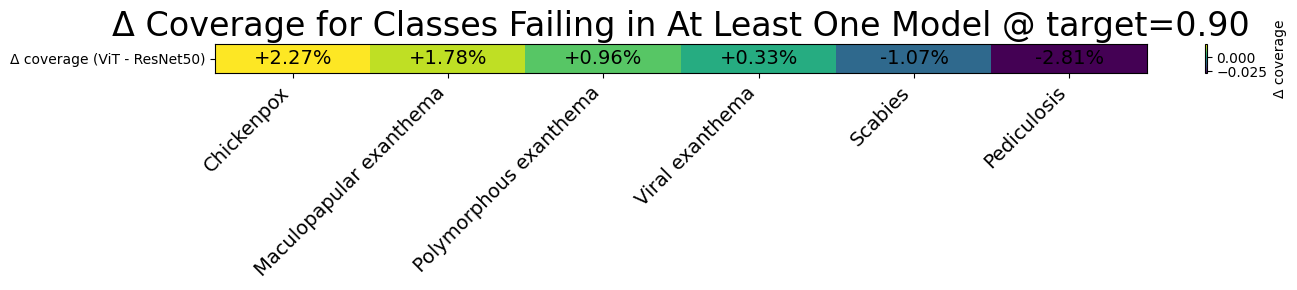

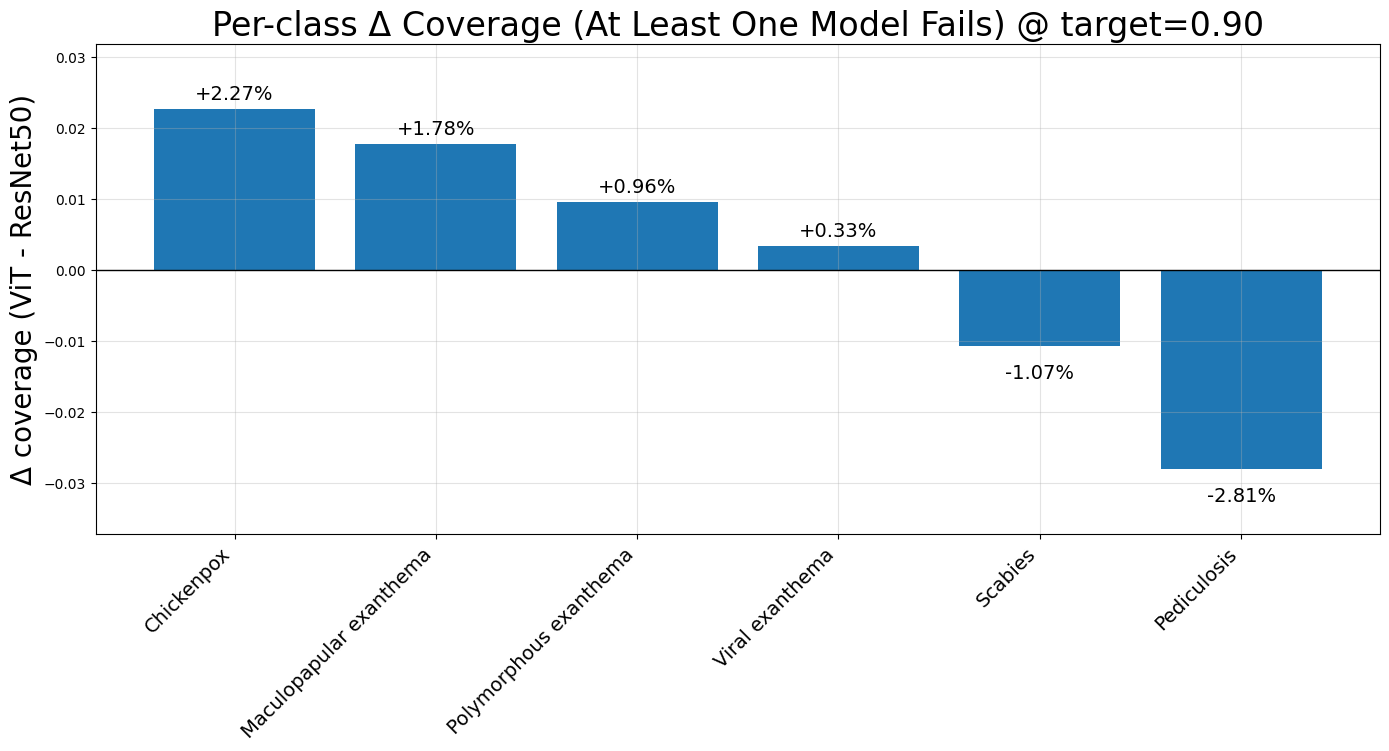

In [23]:
# per_class_delta_coverage_atleast_one_fails(
#     class_df,
#     target=0.90,
#     annotate_fontsize=11,
#     title_fontsize=12,
#     y_label_fontsize=12,
#     figsize_bar=(14, 7.0)
# )

failing_classes_df = per_class_delta_coverage_atleast_one_fails(
    class_df,
    target=0.90,
    annotate_fontsize=14,
    class_fontsize=14,
    title_fontsize=24,
    y_label_fontsize=20,
    figsize_bar=(14, 7.5)
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def per_class_delta_coverage_atleast_one_fails(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",

    class_fontsize: int = 8,           
    annotate_fontsize: int = 10,        
    y_label_fontsize: int = 11,          
    heatmap_ylabel_fontsize: int = 11,   
    title_fontsize: int = 11,            

    figsize_heatmap: Tuple[float, float] = (14, 3.0),
    figsize_bar: Tuple[float, float] = (14, 6.5),

    grid: bool = True,
    grid_axis_heatmap: str = "both",    
    grid_axis_bar: str = "both",         
    grid_linewidth: float = 0.8,
    grid_alpha: float = 0.35,
):


    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d["class_coverage"] = d["class_coverage"].astype(float)
    d["class_name"] = d["class_name"].map(normalize_class_name)

    t = round(float(target), 2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows found for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(
        index="class_name",
        columns="model",
        values="mean_cov"
    )


    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")

    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()


    failing = piv[(piv[resnet_name] < t) | (piv[vit_name] < t)].copy()
    if failing.empty:
        print(f"No classes fail the nominal threshold at target={t:.2f}.")
        return failing

    failing["delta"] = failing[vit_name] - failing[resnet_name]
    failing = failing.sort_values("delta", ascending=False)

    class_names = failing.index.tolist()
    deltas = failing["delta"].values
    deltas_pct = deltas * 100.0


    plt.figure(figsize=figsize_heatmap)
    im = plt.imshow(deltas.reshape(1, -1), aspect="auto")
    cmap = im.get_cmap()
    norm = im.norm


    if grid:
        plt.grid(True, axis=grid_axis_heatmap, linewidth=grid_linewidth, alpha=grid_alpha)

    plt.xticks(
        np.arange(len(class_names)),
        class_names,
        rotation=45,
        ha="right",
        fontsize=class_fontsize
    )
    plt.yticks(
        [0],
        [f"Δ coverage ({vit_name} - {resnet_name})"],
        fontsize=heatmap_ylabel_fontsize
    )

    cbar = plt.colorbar(im)
    cbar.set_label("Δ coverage", fontsize=heatmap_ylabel_fontsize)
    cbar.ax.tick_params(labelsize=class_fontsize)


    # for j, v in enumerate(deltas_pct):
    #     plt.text(
    #         j, 0,
    #         f"{v:+.2f}%",
    #         ha="center",
    #         va="center",
    #         fontsize=annotate_fontsize
    #     )
    for j, (v_abs, v_pct) in enumerate(zip(deltas, deltas_pct)):

        color_val = norm(v_abs)

        text_color = "white" if color_val <= 0.6 else "black"

        plt.text(
            j, 0,
            f"{v_pct:+.2f}%",
            ha="center",
            va="center",
            fontsize=annotate_fontsize,
            color=text_color
        )

    plt.title(
        f"Δ Coverage for Classes Failing in At Least One Model @ target={t:.2f}",
        fontsize=title_fontsize
    )
    plt.tight_layout()
    plt.show()


    x = np.arange(len(class_names))
    plt.figure(figsize=figsize_bar)

    plt.bar(x, deltas)
    plt.axhline(0.0, color="black", linewidth=1)

    if grid:
        plt.grid(True, axis=grid_axis_bar, linewidth=grid_linewidth, alpha=grid_alpha)


    plt.margins(y=0.18)

    for xi, v_abs, v_pct in zip(x, deltas, deltas_pct):
        plt.annotate(
            f"{v_pct:+.2f}%",
            (xi, v_abs),
            xytext=(0, 4 if v_abs >= 0 else -12),
            textcoords="offset points",
            ha="center",
            va="bottom" if v_abs >= 0 else "top",
            fontsize=annotate_fontsize
        )

    plt.xticks(x, class_names, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel(f"Δ coverage ({vit_name} - {resnet_name})", fontsize=y_label_fontsize)
    plt.title(
        f"Per-class Δ Coverage (At Least One Model Fails) @ target={t:.2f}",
        fontsize=title_fontsize
    )


    plt.tight_layout()
    plt.subplots_adjust(bottom=0.28)
    plt.show()

    return failing


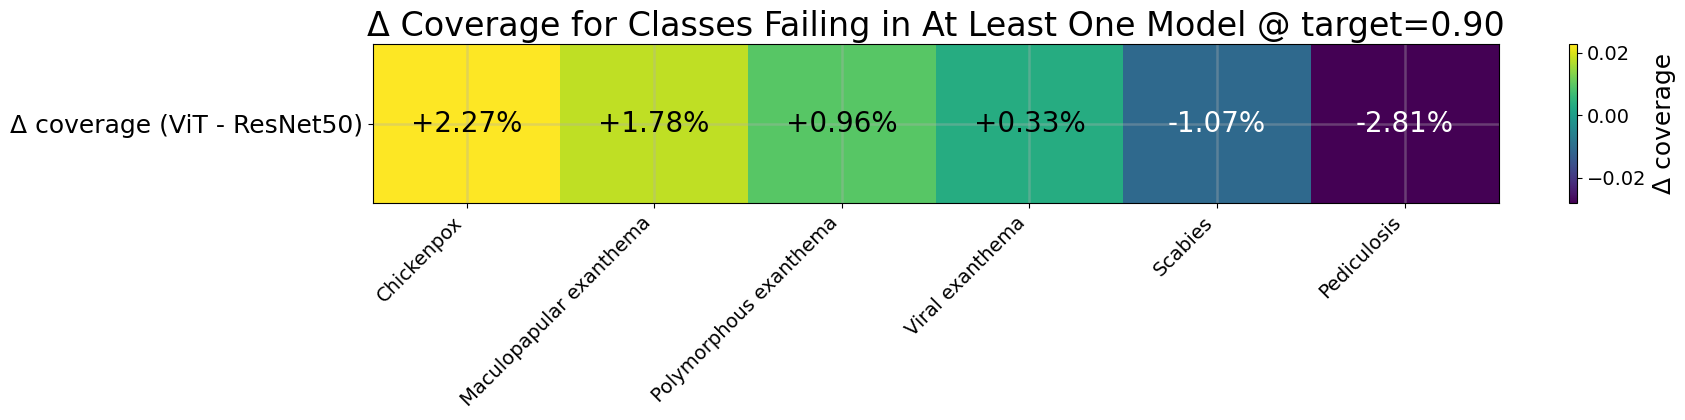

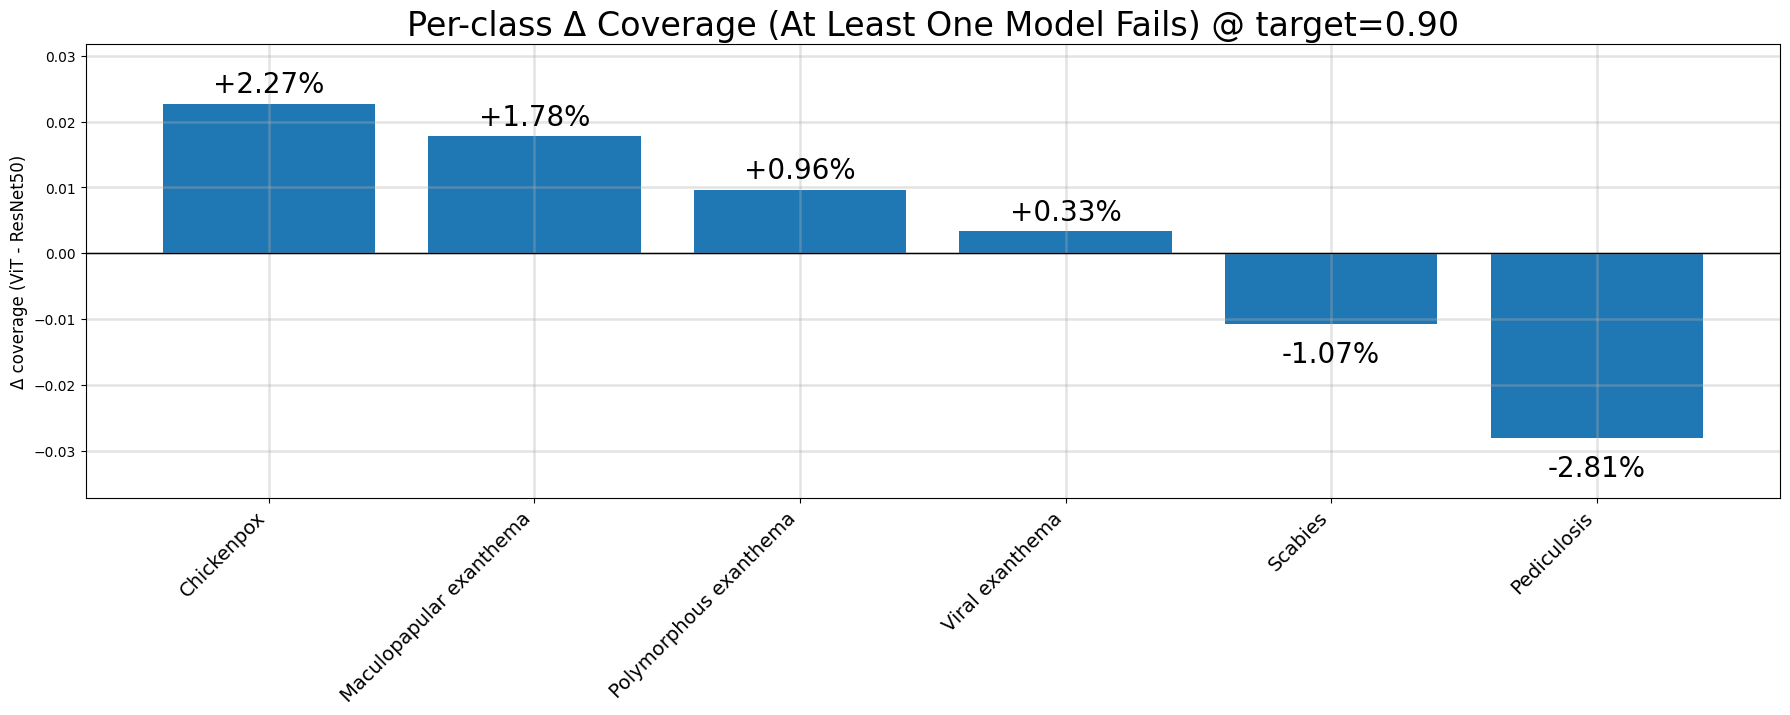

In [ ]:

failing_df = per_class_delta_coverage_atleast_one_fails(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    figsize_heatmap=(18, 4.3),
    figsize_bar=(18, 7.0),
    class_fontsize=14,
    annotate_fontsize=20,
    y_label_fontsize=12,
    heatmap_ylabel_fontsize=18,
    title_fontsize=24,
    grid=True,
    grid_axis_heatmap="both",
    grid_axis_bar="both",
    grid_linewidth=1.8,
    grid_alpha=0.35,
)


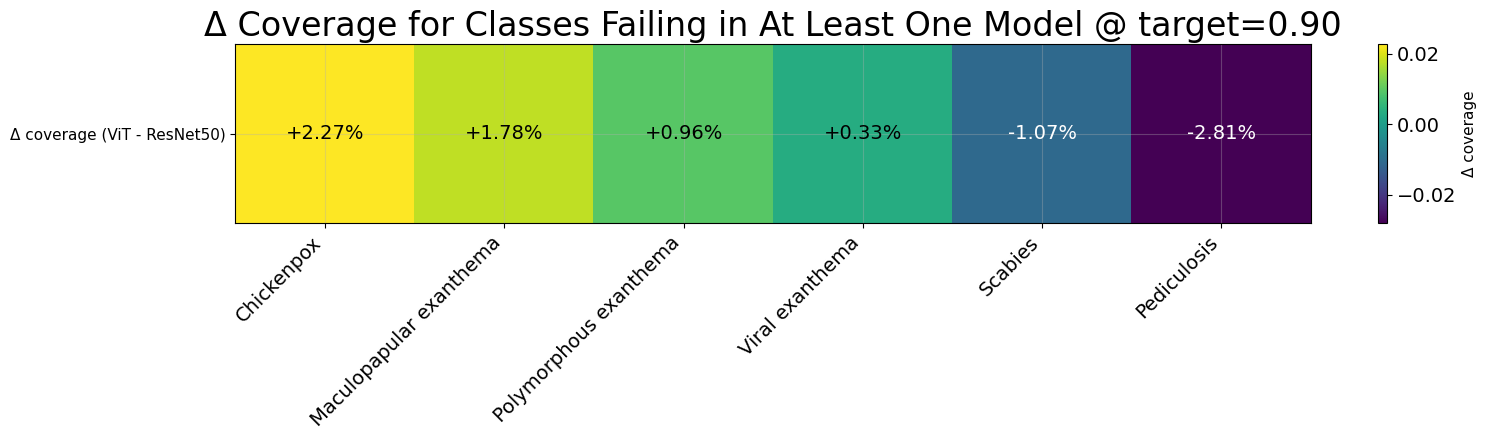

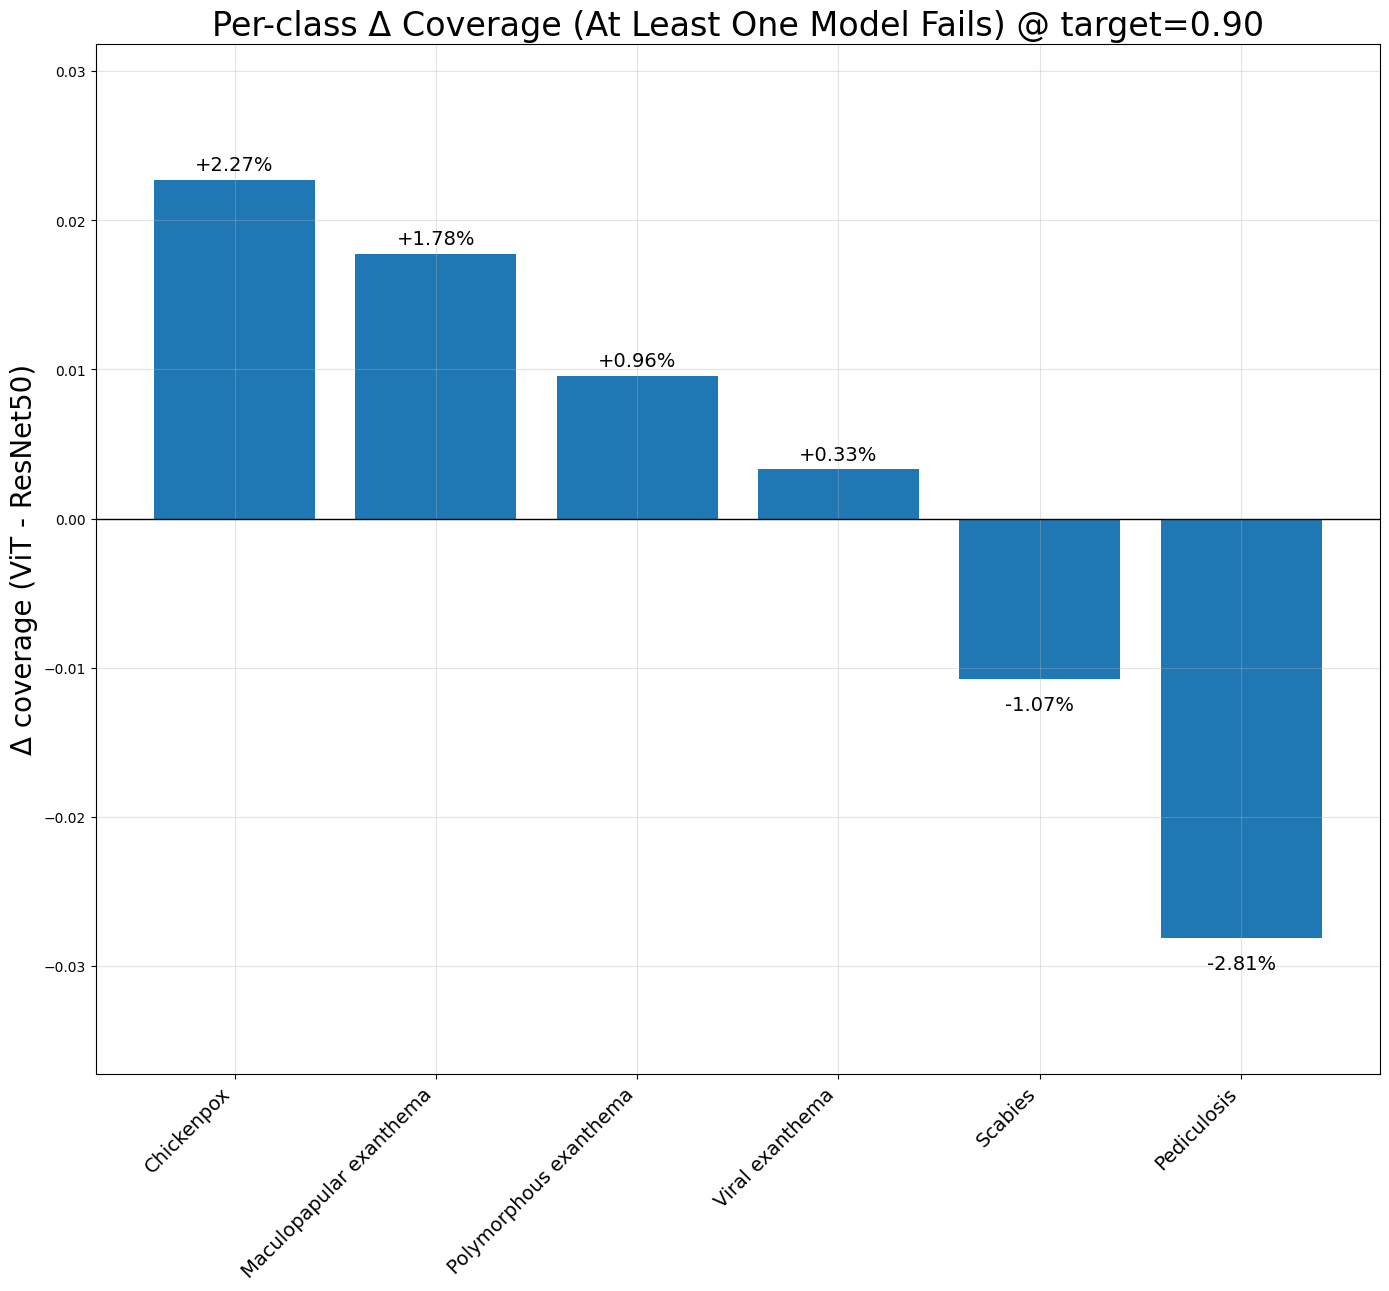

In [26]:
failing_classes_df = per_class_delta_coverage_atleast_one_fails(
    class_df,
    target=0.90,
    annotate_fontsize=14,
    class_fontsize=14,
    title_fontsize=24,
    y_label_fontsize=20,
    figsize_bar=(14, 15),
    figsize_heatmap=(16, 4.5)
)

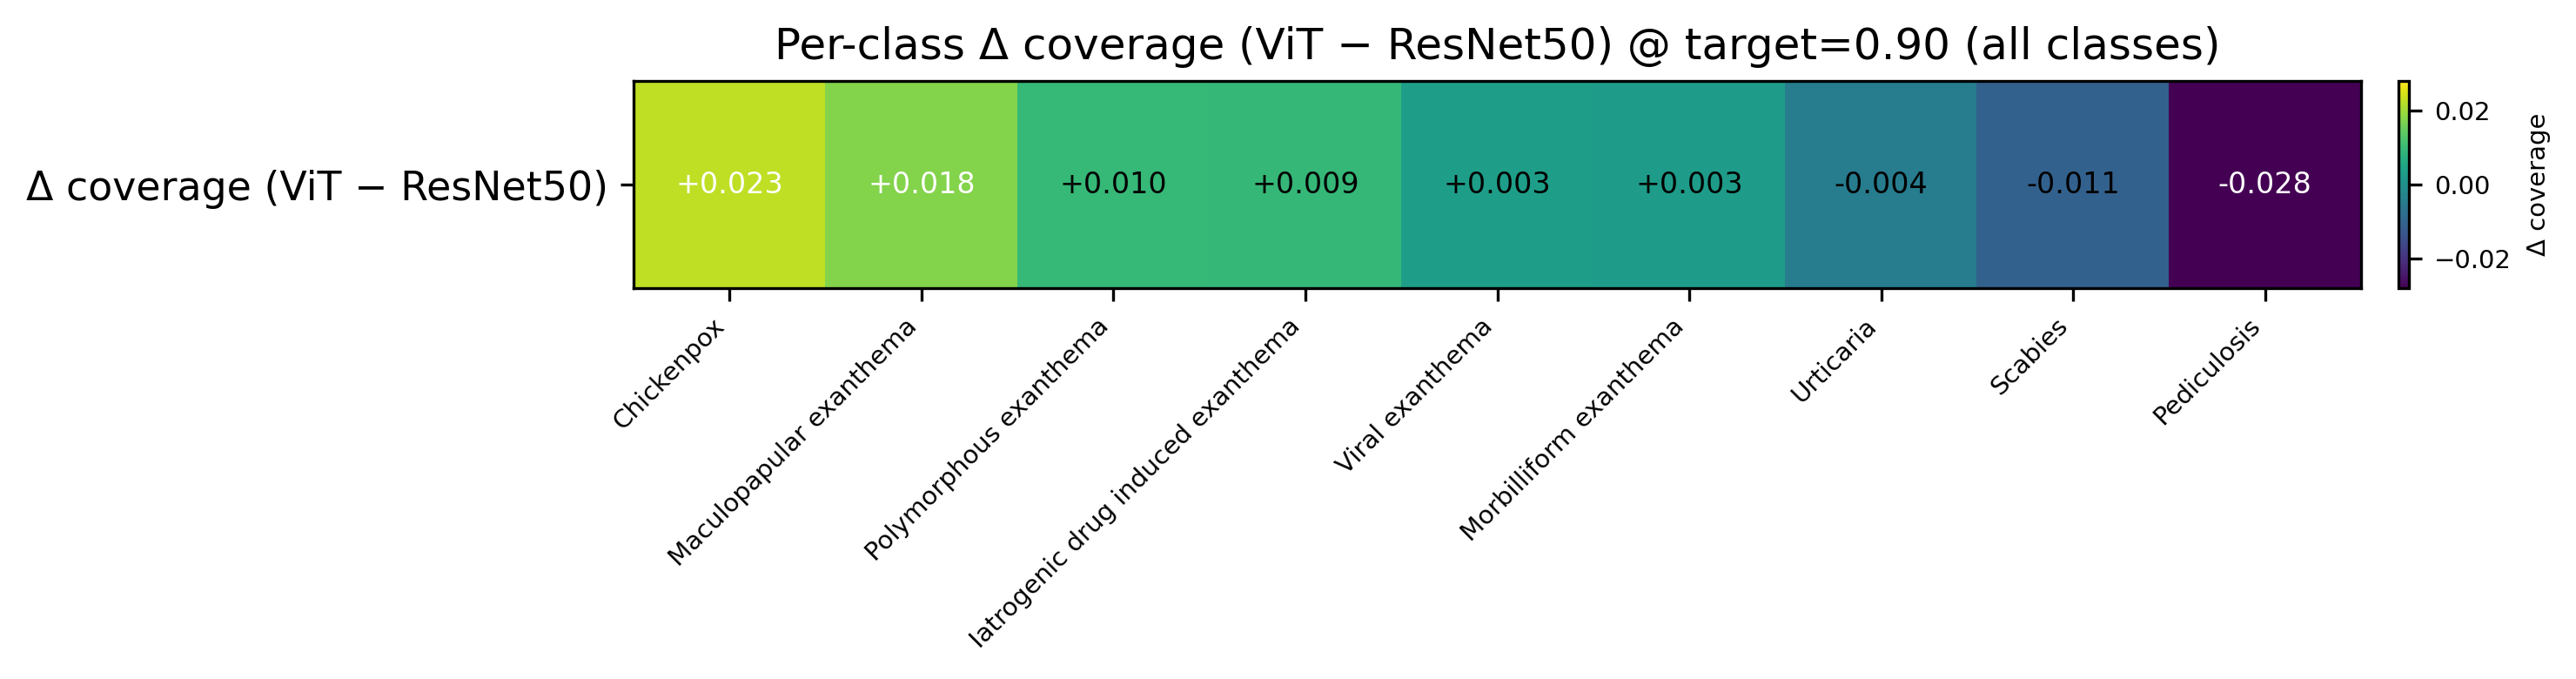

model                              ResNet50      ViT  gap_resnet  gap_vit  \
class_name                                                                  
Chickenpox                          0.83175  0.85445     0.06825  0.04555   
Maculopapular exanthema             0.86600  0.88375     0.03400  0.01625   
Polymorphous exanthema              0.84705  0.85660     0.05295  0.04340   
Iatrogenic drug induced exanthema   0.92850  0.93780    -0.02850 -0.03780   
Viral exanthema                     0.88540  0.88870     0.01460  0.01130   
Morbilliform exanthema              0.93640  0.93935    -0.03640 -0.03935   
Urticaria                           0.91075  0.90630    -0.01075 -0.00630   
Scabies                             0.90945  0.89870    -0.00945  0.00130   
Pediculosis                         0.91895  0.89085    -0.01895  0.00915   

model                                  gap    delta  
class_name                                           
Chickenpox                         0.06825  0.02270  
Maculopapular exanthema            0.03400  0.01775  
Polymorphous exanthema             0.05295  0.00955  
Iatrogenic drug induced exanthema -0.02850  0.00930  
Viral exanthema                    0.01460  0.00330  
Morbilliform exanthema            -0.03640  0.00295  
Urticaria                         -0.00630 -0.00445  
Scabies                            0.00130 -0.01075  
Pediculosis                        0.00915 -0.02810

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def delta_coverage_heatmap(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_only: bool = False,
    failing_rule: str = "either",   
    class_fontsize: int = 7,
    annotate_fontsize: int = 8,
    dpi: int = 300,
    out_path: Optional[str] = None,
):

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows for target_coverage={t}")

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model.pivot(index="class_name", columns="model", values="mean_cov")
    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()


    piv["gap_resnet"] = t - piv[resnet_name]
    piv["gap_vit"] = t - piv[vit_name]
    piv["gap"] = np.maximum(piv["gap_resnet"], piv["gap_vit"])
    piv["delta"] = piv[vit_name] - piv[resnet_name]


    if failing_only:
        if failing_rule == "either":
            piv = piv[(piv["gap_resnet"] > 0) | (piv["gap_vit"] > 0)]
            rule_text = "failing classes"
        elif failing_rule == "both":
            piv = piv[(piv["gap_resnet"] > 0) & (piv["gap_vit"] > 0)]
            rule_text = "classes failing in both models"
        else:
            raise ValueError("failing_rule must be 'either' or 'both'")
    else:
        rule_text = "all classes"

    if piv.empty:
        print("No classes to plot.")
        return piv


    piv = piv.sort_values("delta", ascending=False)

    classes = piv.index.tolist()
    deltas_vec = piv["delta"].values
    deltas = deltas_vec.reshape(1, -1)


    vmin_data, vmax_data = float(np.min(deltas_vec)), float(np.max(deltas_vec))
    has_pos = vmax_data > 0
    has_neg = vmin_data < 0

    if has_pos and has_neg:
        vmax = max(abs(vmin_data), abs(vmax_data))
        vmin = -vmax
    else:
        vmin, vmax = vmin_data, vmax_data

    fig, ax = plt.subplots(figsize=(max(10, 0.9 * len(classes)), 2.7), dpi=dpi)

    im = ax.imshow(deltas, aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=class_fontsize)
    ax.set_yticks([0])
    ax.set_yticklabels([f"Δ coverage ({vit_name} − {resnet_name})"], fontsize=11)#=class_fontsize)

    cbar = fig.colorbar(im, ax=ax, fraction=0.06, pad=0.02)
    cbar.set_label("Δ coverage", fontsize=class_fontsize)
    cbar.ax.tick_params(labelsize=class_fontsize)


    vmax_abs = max(abs(vmin), abs(vmax)) if (vmin != 0 or vmax != 0) else 1.0
    for j, v in enumerate(deltas[0]):
        ax.text(
            j, 0,
            f"{v:+.3f}",
            ha="center",
            va="center",
            fontsize=annotate_fontsize,
            color="black" if abs(v) < 0.6 * vmax_abs else "white"
        )

    ax.set_title(
        f"Per-class Δ coverage ({vit_name} − {resnet_name}) @ target={t:.2f} ({rule_text})",
        fontweight="normal"
    )

    fig.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return piv
delta_coverage_heatmap(
    class_df,
    target=0.90,
    failing_only=False,
    out_path="paper_plots/delta_heatmap_all_classes_0p90.png"
)


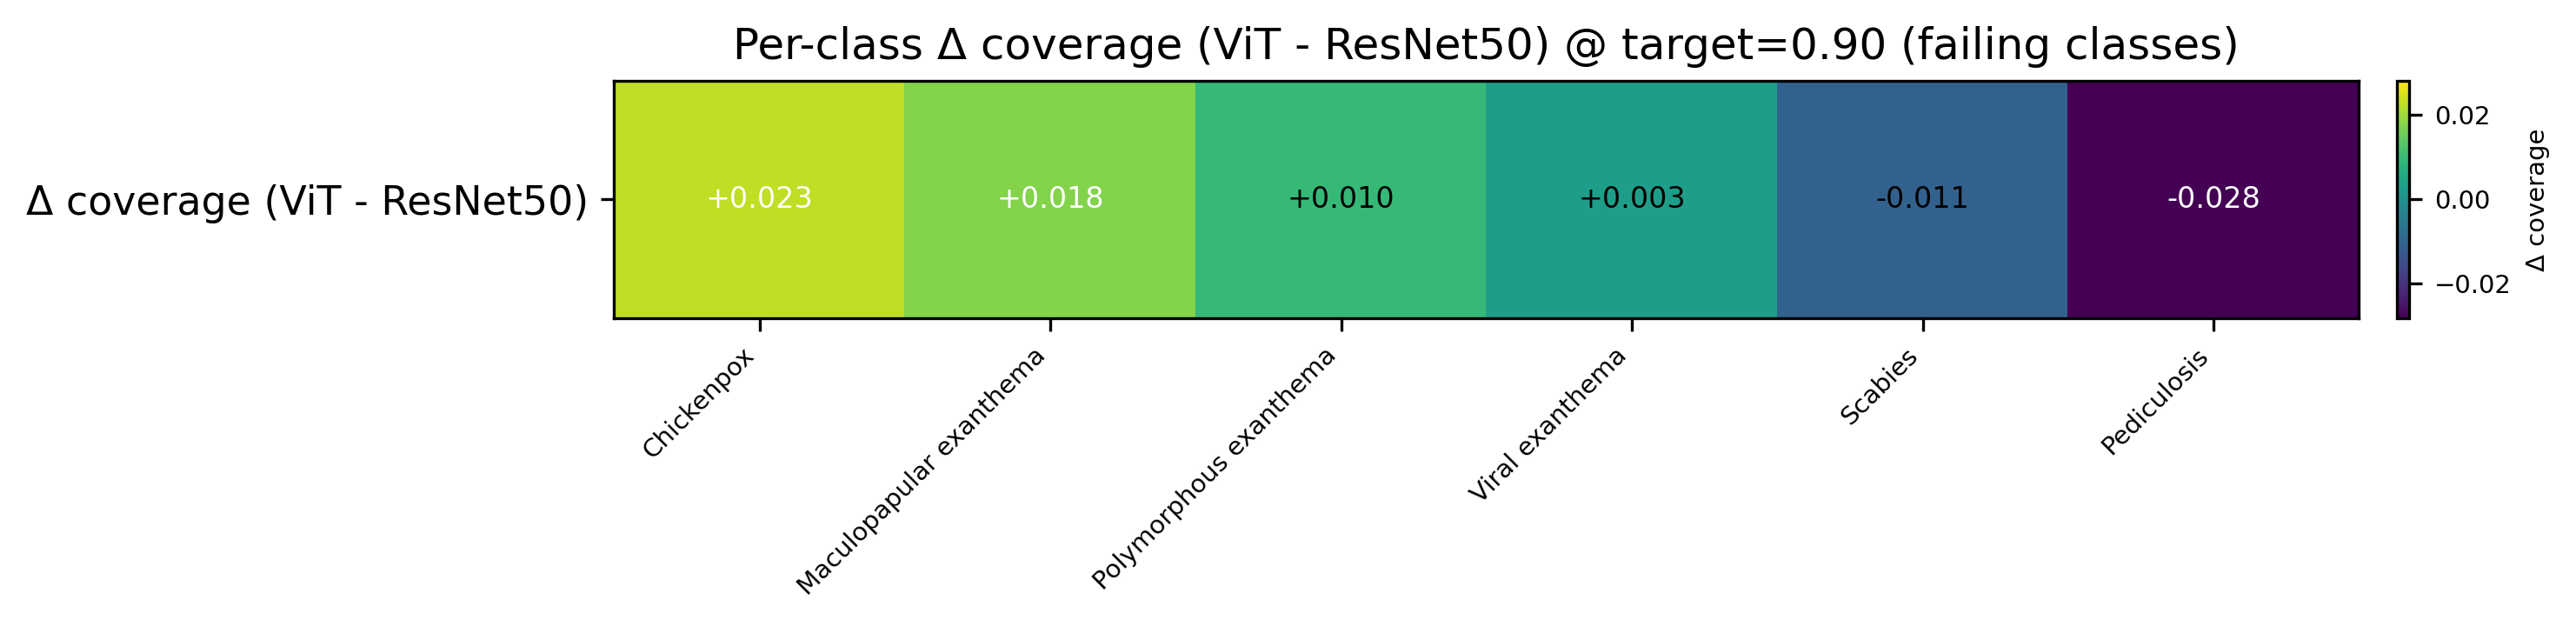

model                    ResNet50      ViT  gap_resnet  gap_vit      gap  \
class_name                                                                 
Chickenpox                0.83175  0.85445     0.06825  0.04555  0.06825   
Maculopapular exanthema   0.86600  0.88375     0.03400  0.01625  0.03400   
Polymorphous exanthema    0.84705  0.85660     0.05295  0.04340  0.05295   
Viral exanthema           0.88540  0.88870     0.01460  0.01130  0.01460   
Scabies                   0.90945  0.89870    -0.00945  0.00130  0.00130   
Pediculosis               0.91895  0.89085    -0.01895  0.00915  0.00915   

model                      delta  
class_name                        
Chickenpox               0.02270  
Maculopapular exanthema  0.01775  
Polymorphous exanthema   0.00955  
Viral exanthema          0.00330  
Scabies                 -0.01075  
Pediculosis             -0.02810

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def delta_coverage_heatmap(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_only: bool = False,
    failing_rule: str = "either", 
    class_fontsize: int = 7,
    annotate_fontsize: int = 8,
    dpi: int = 300,
    out_path: Optional[str] = None,
):
    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows for target_coverage={t}")

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model.pivot(index="class_name", columns="model", values="mean_cov")
    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any").copy()


    piv["gap_resnet"] = t - piv[resnet_name]
    piv["gap_vit"] = t - piv[vit_name]
    piv["gap"] = np.maximum(piv["gap_resnet"], piv["gap_vit"])
    piv["delta"] = piv[vit_name] - piv[resnet_name]


    if failing_only:
        if failing_rule == "either":
            piv = piv[(piv["gap_resnet"] > 0) | (piv["gap_vit"] > 0)]
            rule_text = "failing classes"
        elif failing_rule == "both":
            piv = piv[(piv["gap_resnet"] > 0) & (piv["gap_vit"] > 0)]
            rule_text = "classes failing in both models"
        else:
            raise ValueError("failing_rule must be 'either' or 'both'")
    else:
        rule_text = "all classes"

    if piv.empty:
        print("No classes to plot.")
        return piv


    piv = piv.sort_values("delta", ascending=False)

    classes = piv.index.tolist()
    deltas_vec = piv["delta"].values
    deltas = deltas_vec.reshape(1, -1)


    vmin_data, vmax_data = float(np.min(deltas_vec)), float(np.max(deltas_vec))
    has_pos = vmax_data > 0
    has_neg = vmin_data < 0

    if has_pos and has_neg:
        vmax = max(abs(vmin_data), abs(vmax_data))
        vmin = -vmax
    else:
        vmin, vmax = vmin_data, vmax_data

    fig, ax = plt.subplots(figsize=(max(10, 0.9 * len(classes)), 2.5), dpi=dpi)

    im = ax.imshow(deltas, aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right", fontsize=class_fontsize)
    ax.set_yticks([0])
    ax.set_yticklabels([f"Δ coverage ({vit_name} - {resnet_name})"], fontsize=11)#class_fontsize)

    cbar = fig.colorbar(im, ax=ax, fraction=0.06, pad=0.02)
    cbar.set_label("Δ coverage", fontsize=class_fontsize)
    cbar.ax.tick_params(labelsize=class_fontsize)


    vmax_abs = max(abs(vmin), abs(vmax)) if (vmin != 0 or vmax != 0) else 1.0
    for j, v in enumerate(deltas[0]):
        ax.text(
            j, 0,
            f"{v:+.3f}",
            ha="center",
            va="center",
            fontsize=annotate_fontsize,
            color="black" if abs(v) < 0.6 * vmax_abs else "white"
        )

    ax.set_title(
        f"Per-class Δ coverage ({vit_name} - {resnet_name}) @ target={t:.2f} ({rule_text})",
        fontweight="normal"
    )

    fig.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return piv



delta_coverage_heatmap(
    class_df,
    target=0.90,
    failing_only=True,
    failing_rule="either",
    out_path="paper_plots/delta_heatmap_failing_classes_0p90.png"
)


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def plot_failing_classes_avg_coverages_annotated(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",   
    sort_by: str = "min",           
    class_fontsize: int = 7,
    annotate: bool = True,
    annotate_fontsize: int = 8,
    show_gap_in_labels: bool = False,  
    dpi: int = 300,
    out_path: Optional[str] = None,
):

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")

    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")

    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any")


    res_fail = piv[resnet_name] < t
    vit_fail = piv[vit_name] < t

    if failing_rule == "either":
        failing = piv[res_fail | vit_fail].copy()
        rule_text = "classes failing in either model"
    elif failing_rule == "both":
        failing = piv[res_fail & vit_fail].copy()
        rule_text = "classes failing in both models"
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if failing.empty:
        print(f"No failing classes found at target={t:.2f} using rule='{failing_rule}'.")
        return failing


    failing["min_cov"] = failing[[resnet_name, vit_name]].min(axis=1)
    failing["gap_resnet"] = t - failing[resnet_name]
    failing["gap_vit"] = t - failing[vit_name]
    failing["gap_max"] = np.maximum(failing["gap_resnet"], failing["gap_vit"])


    if sort_by == "min":
        failing = failing.sort_values("min_cov", ascending=True)
    elif sort_by == "gap":
        failing = failing.sort_values("gap_max", ascending=False)
    elif sort_by == "resnet":
        failing = failing.sort_values(resnet_name, ascending=True)
    elif sort_by == "vit":
        failing = failing.sort_values(vit_name, ascending=True)
    elif sort_by == "name":
        failing = failing.sort_index()
    else:
        raise ValueError("sort_by must be one of: min, gap, resnet, vit, name")

    classes = failing.index.tolist()
    x = np.arange(len(classes))
    width = 0.42


    if show_gap_in_labels:
        xtick_labels = [
            f"{cls}\nΔgap={failing.loc[cls, 'gap_max']:.3f}"
            for cls in classes
        ]
    else:
        xtick_labels = classes

    plt.figure(figsize=(max(12, 0.55 * len(classes)), 5.2), dpi=dpi)

    bars_r = plt.bar(x - width/2, failing[resnet_name].values, width=width, label=resnet_name)
    bars_v = plt.bar(x + width/2, failing[vit_name].values,    width=width, label=vit_name)

    plt.axhline(t, linestyle="--", linewidth=1.4, color="black", alpha=0.8, label=f"target={t:.2f}")


    if annotate:
        def _annotate(bars):
            for b in bars:
                h = b.get_height()
                plt.annotate(
                    f"{h:.3f}",
                    xy=(b.get_x() + b.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontsize=annotate_fontsize
                )

        _annotate(bars_r)
        _annotate(bars_v)

    plt.xticks(x, xtick_labels, rotation=45, ha="right", fontsize=class_fontsize)
    plt.ylabel("Average class coverage (average over 20 runs)", fontsize=13)
    plt.title(f"Failing classes @ nominal={t:.2f} — {rule_text}",  fontweight="normal")
    plt.grid(True, axis="y", linewidth=0.6, alpha=0.35)
    plt.legend(frameon=True)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

    return failing


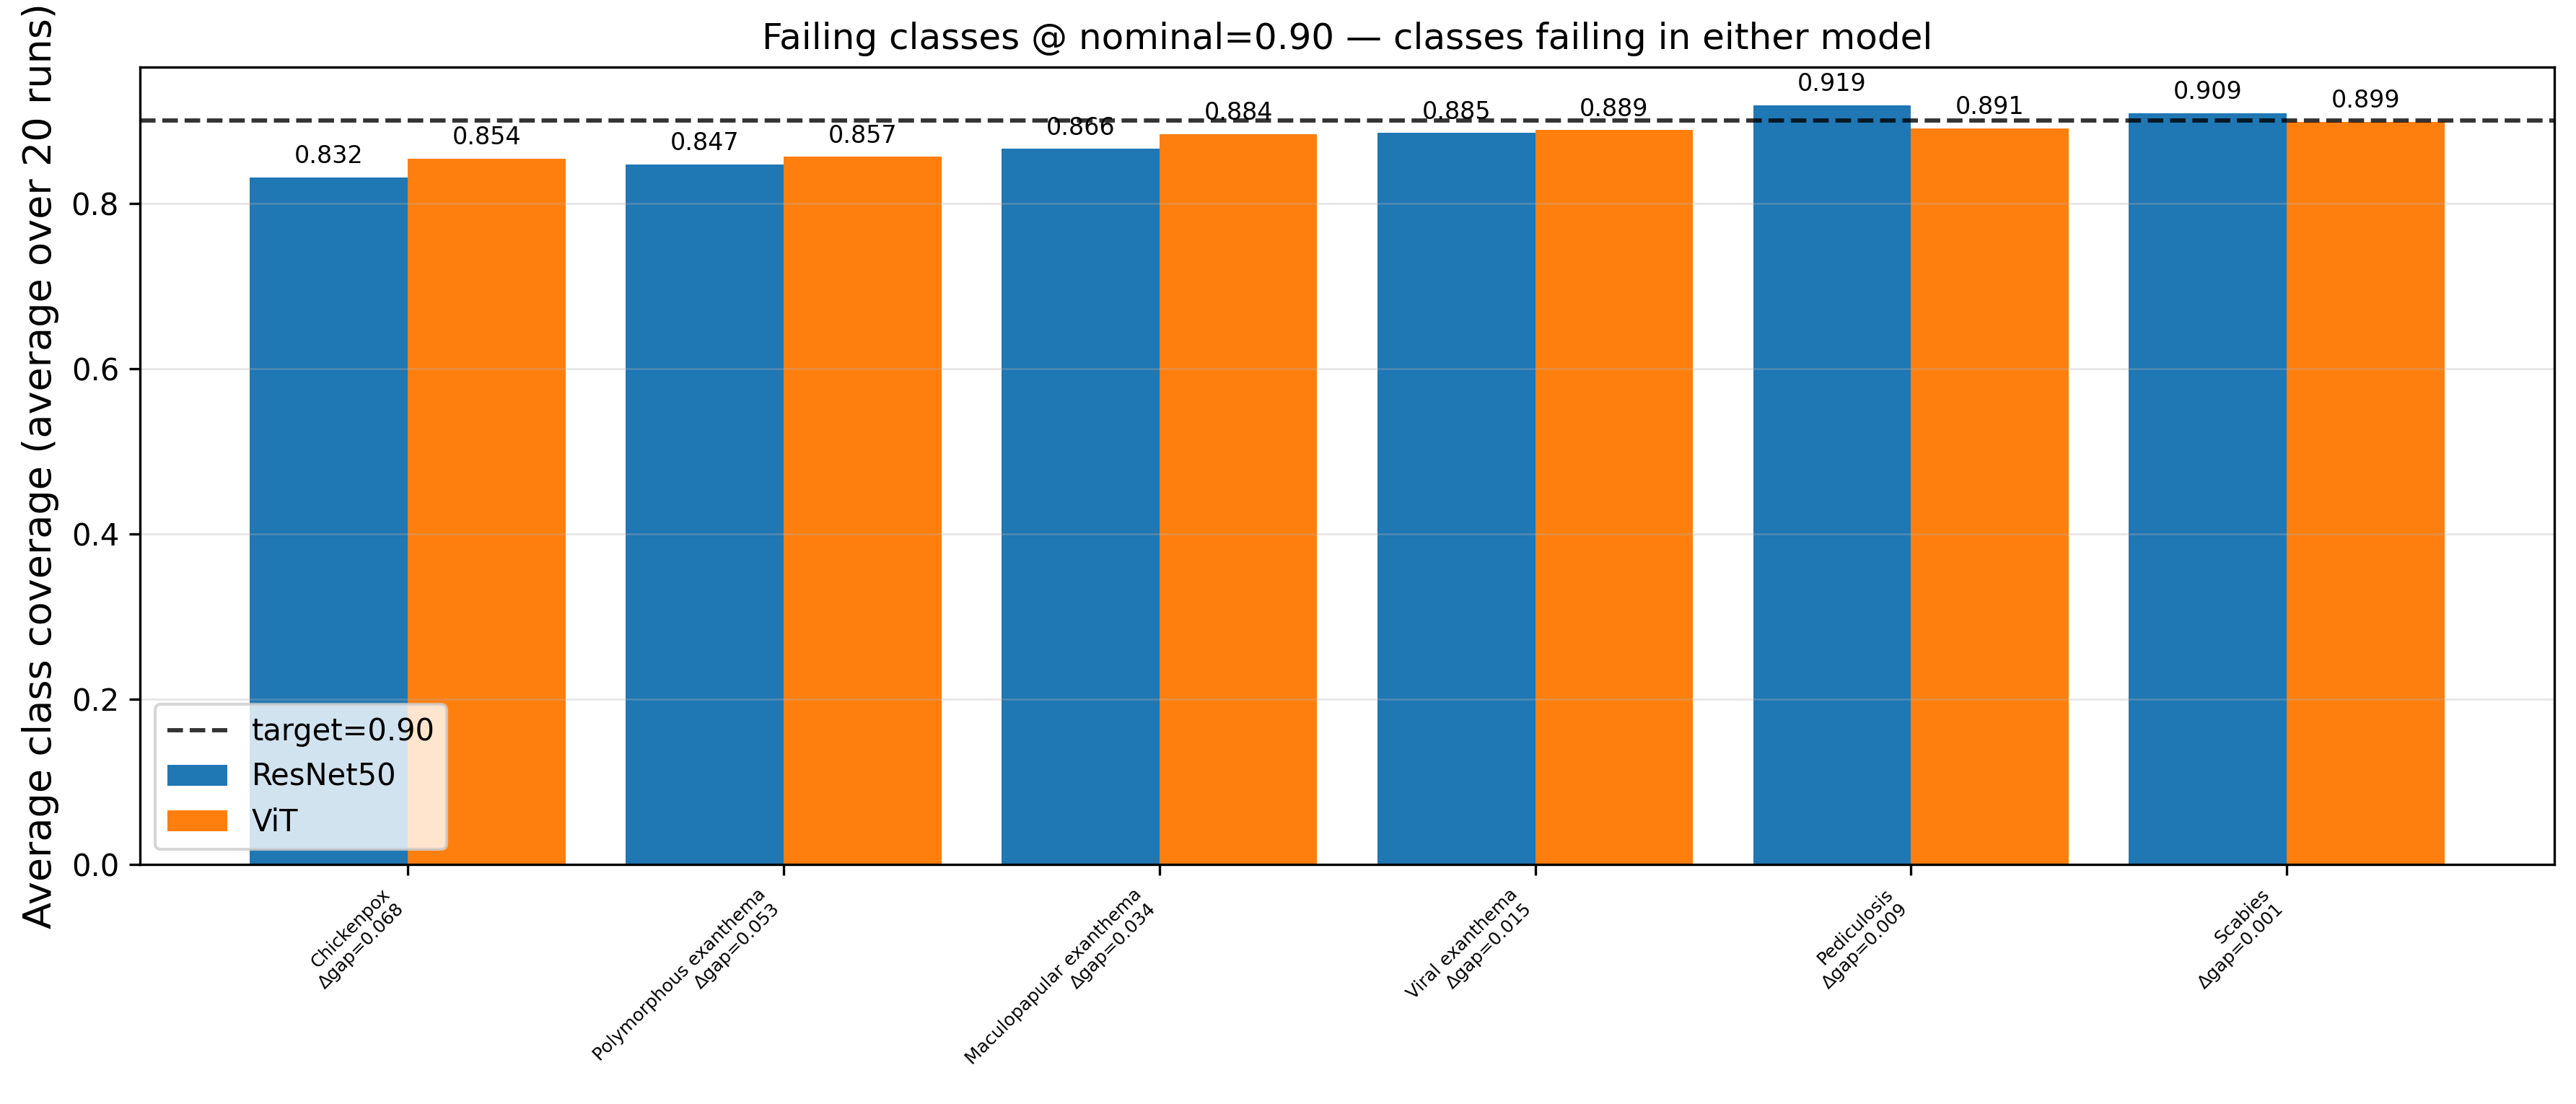

In [30]:
failing_tbl = plot_failing_classes_avg_coverages_annotated(
    class_df,
    target=0.90,
    failing_rule="either",
    sort_by="min",
    annotate=True,
    annotate_fontsize=8,
    class_fontsize=6,
    show_gap_in_labels=True,
    out_path="paper_plots/failing_classes_bar_annotated_0p90.png"
)


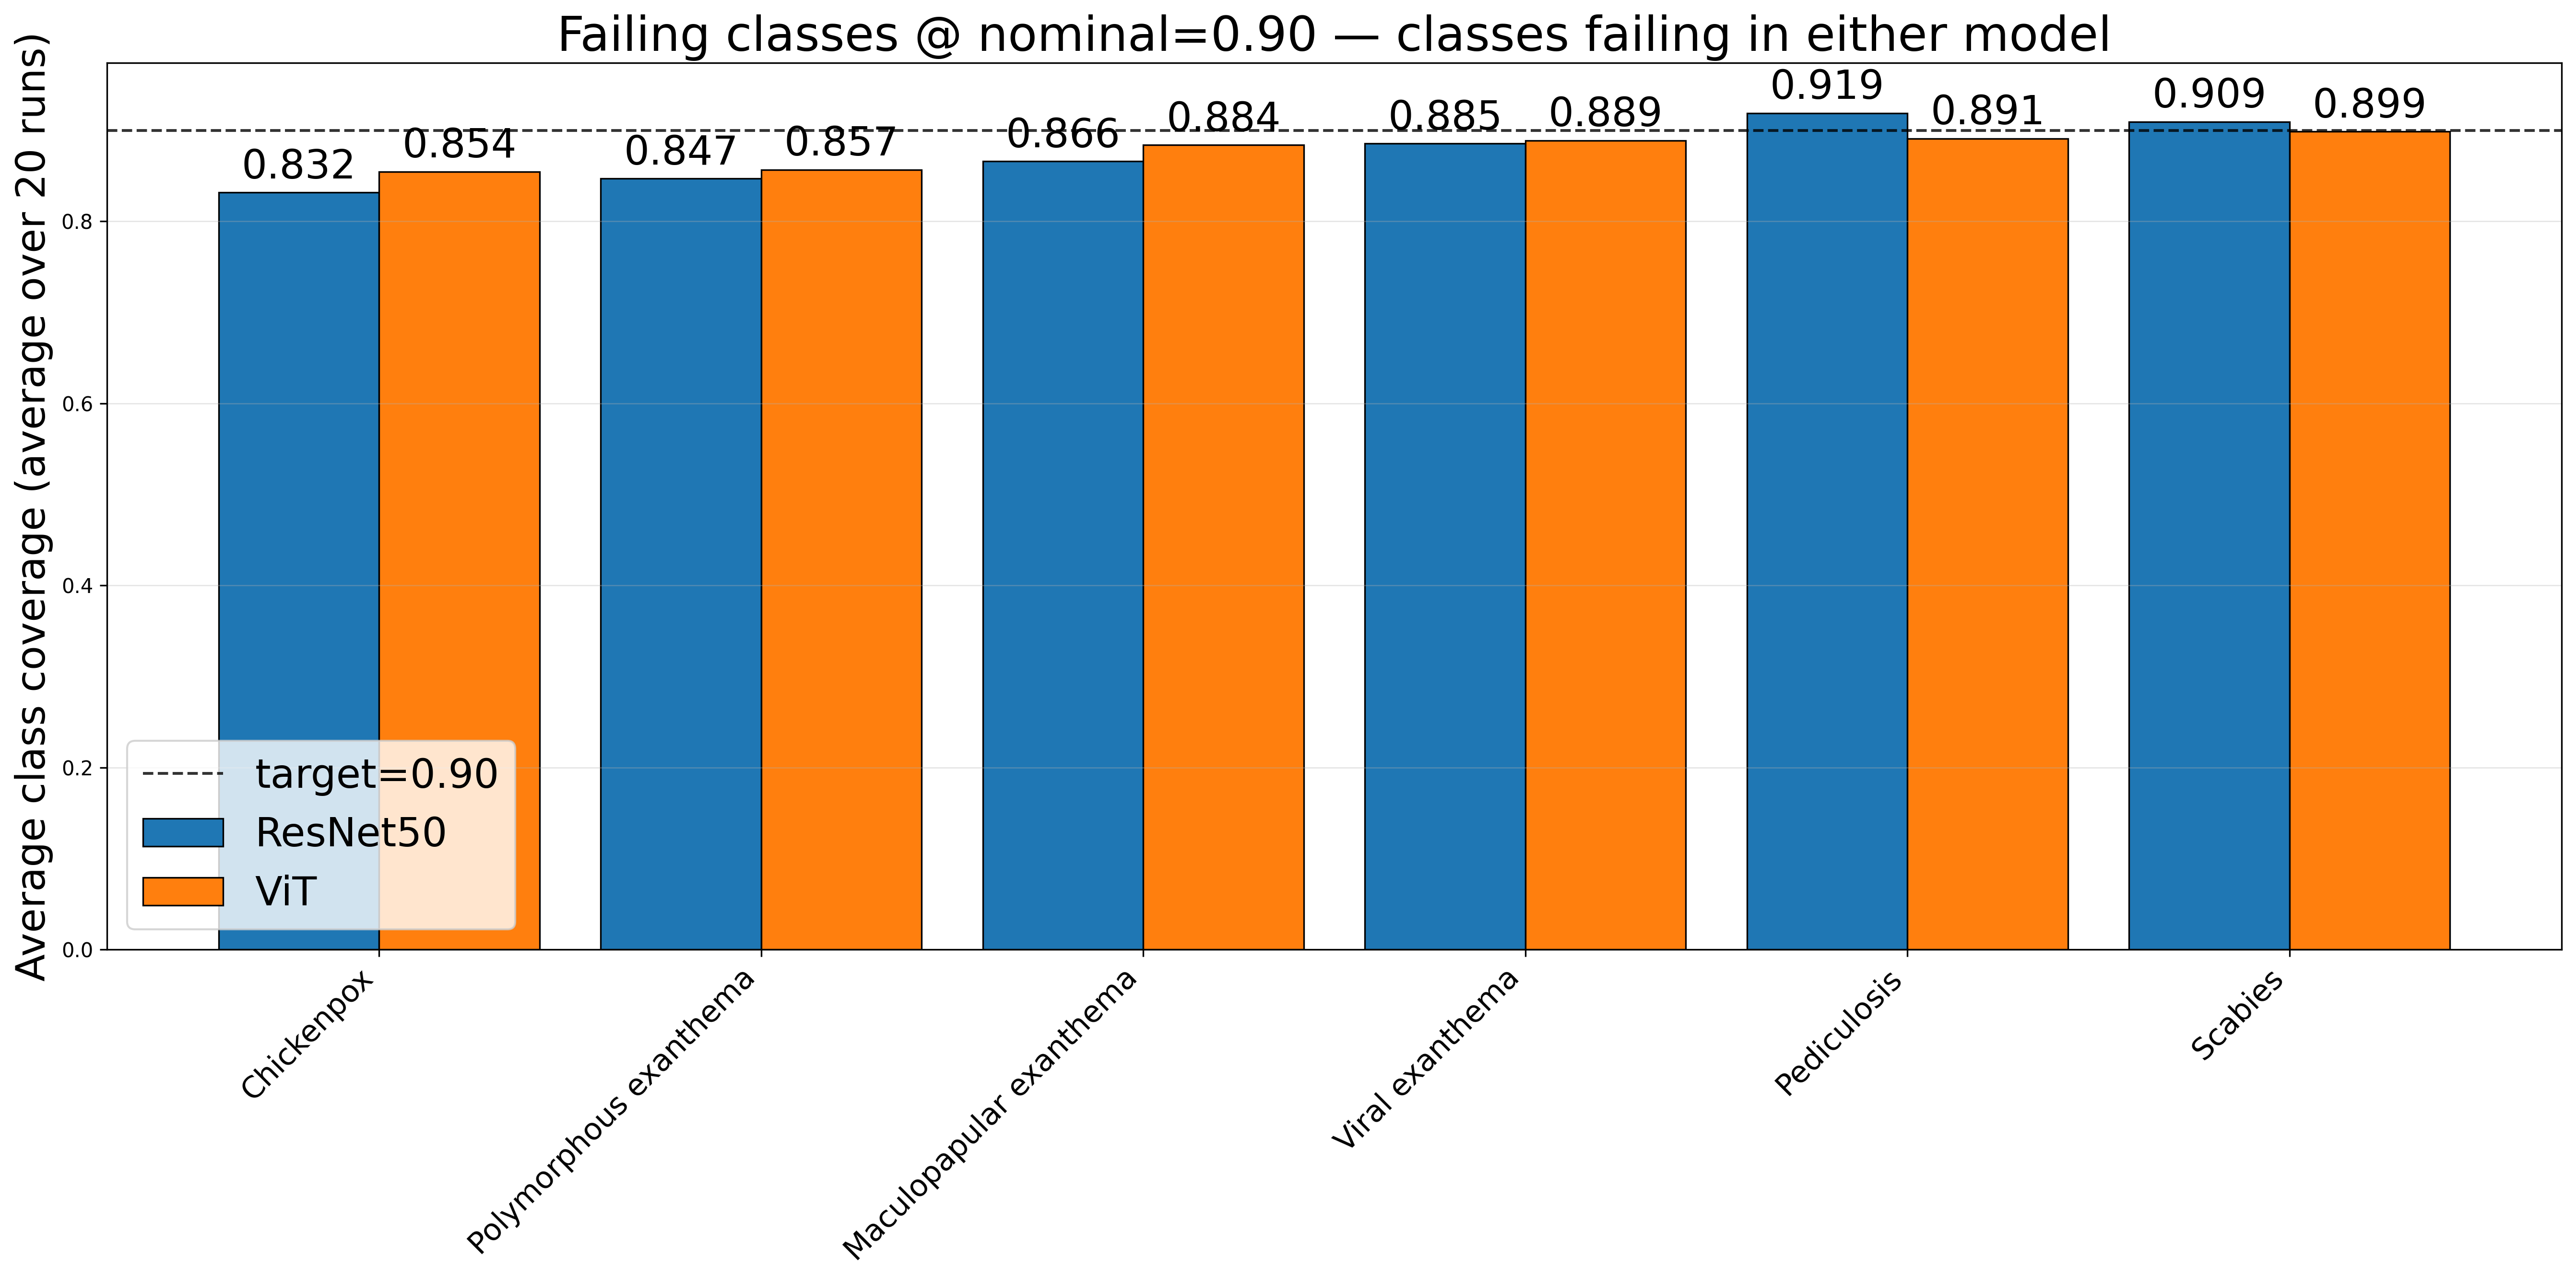

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Optional, Tuple


def normalize_class_name(name: str) -> str:
    name = str(name)
    name = re.sub(r"^crops_fair_", "", name)
    name = re.sub(r"^skin_", "", name)
    return name


def plot_failing_classes_avg_coverages_annotated(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",   
    sort_by: str = "min",              
    show_gap_in_labels: bool = False,
    annotate: bool = True,
    out_path: Optional[str] = None,

  

    figsize: Optional[Tuple[float, float]] = None, 
    dpi: int = 300,


    class_fontsize: int = 7,            
    y_label_fontsize: int = 13,
    title_fontsize: int = 12,
    legend_fontsize: int = 9,
    annotate_fontsize: int = 8,


    xtick_rotation: float = 45,
    xtick_ha: str = "right",


    bar_width: float = 0.42,
    resnet_color: str = "tab:blue",
    vit_color: str = "tab:orange",
    bar_edgecolor: Optional[str] = None,  
    bar_linewidth: float = 0.0,


    target_line: bool = True,
    target_line_style: str = "--",
    target_line_width: float = 1.4,
    target_line_color: str = "black",
    target_line_alpha: float = 0.8,
    target_label: Optional[str] = None, 


    grid: bool = True,
    grid_axis: str = "y",
    grid_linewidth: float = 0.6,
    grid_alpha: float = 0.35,


    legend_frameon: bool = True,
    legend_loc: str = "best",


    ylim: Optional[Tuple[float, float]] = None,
    tight_layout: bool = True,
):
    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(
            f"No rows for target_coverage={t}. "
            f"Available: {sorted(class_df['target_coverage'].astype(float).round(2).unique())}"
        )

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model_class = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model_class.pivot(index="class_name", columns="model", values="mean_cov")

    for m in (resnet_name, vit_name):
        if m not in piv.columns:
            raise ValueError(f"Model '{m}' not found. Available models: {list(piv.columns)}")


    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any")

    # failing rule
    res_fail = piv[resnet_name] < t
    vit_fail = piv[vit_name] < t

    if failing_rule == "either":
        failing = piv[res_fail | vit_fail].copy()
        rule_text = "classes failing in either model"
    elif failing_rule == "both":
        failing = piv[res_fail & vit_fail].copy()
        rule_text = "classes failing in both models"
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if failing.empty:
        print(f"No failing classes found at target={t:.2f} using rule='{failing_rule}'.")
        return failing

    failing["min_cov"] = failing[[resnet_name, vit_name]].min(axis=1)
    failing["gap_resnet"] = t - failing[resnet_name]
    failing["gap_vit"] = t - failing[vit_name]
    failing["gap_max"] = np.maximum(failing["gap_resnet"], failing["gap_vit"])

    # sorting
    if sort_by == "min":
        failing = failing.sort_values("min_cov", ascending=True)
    elif sort_by == "gap":
        failing = failing.sort_values("gap_max", ascending=False)
    elif sort_by == "resnet":
        failing = failing.sort_values(resnet_name, ascending=True)
    elif sort_by == "vit":
        failing = failing.sort_values(vit_name, ascending=True)
    elif sort_by == "name":
        failing = failing.sort_index()
    else:
        raise ValueError("sort_by must be one of: min, gap, resnet, vit, name")

    classes = failing.index.tolist()
    x = np.arange(len(classes))

    if show_gap_in_labels:
        xtick_labels = [f"{cls}\nΔgap={failing.loc[cls, 'gap_max']:.3f}" for cls in classes]
    else:
        xtick_labels = classes


    if figsize is None:
        figsize = (max(12, 0.55 * len(classes)), 5.2)

    plt.figure(figsize=figsize, dpi=dpi)

    edge_kw = {}
    if bar_edgecolor is not None:
        edge_kw["edgecolor"] = bar_edgecolor
        edge_kw["linewidth"] = bar_linewidth


    bars_r = plt.bar(
        x - bar_width / 2,
        failing[resnet_name].values,
        width=bar_width,
        label=resnet_name,
        color=resnet_color,
        **edge_kw,
    )
    bars_v = plt.bar(
        x + bar_width / 2,
        failing[vit_name].values,
        width=bar_width,
        label=vit_name,
        color=vit_color,
        **edge_kw,
    )

    y_max = failing[[resnet_name, vit_name]].to_numpy().max()
    plt.ylim(top=y_max * 1.06)


    # target line
    if target_line:
        if target_label is None:
            target_label = f"target={t:.2f}"
        plt.axhline(
            t,
            linestyle=target_line_style,
            linewidth=target_line_width,
            color=target_line_color,
            alpha=target_line_alpha,
            label=target_label,
        )

    # annotations
    if annotate:
        def _annotate(bars):
            for b in bars:
                h = b.get_height()
                plt.annotate(
                    f"{h:.3f}",
                    xy=(b.get_x() + b.get_width() / 2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontsize=annotate_fontsize,
                )
        _annotate(bars_r)
        _annotate(bars_v)

    plt.xticks(
        x,
        xtick_labels,
        rotation=xtick_rotation,
        ha=xtick_ha,
        fontsize=class_fontsize,
    )
    plt.ylabel("Average class coverage (average over 20 runs)", fontsize=y_label_fontsize)
    plt.title(
        f"Failing classes @ nominal={t:.2f} — {rule_text}",
        fontsize=title_fontsize,
        fontweight="normal",
    )

    if grid:
        plt.grid(True, axis=grid_axis, linewidth=grid_linewidth, alpha=grid_alpha)

    plt.legend(frameon=legend_frameon, loc=legend_loc, fontsize=legend_fontsize)

    if ylim is not None:
        plt.ylim(*ylim)

    if tight_layout:
        plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    return failing
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=24,
    legend_fontsize=20,
    y_label_fontsize=20,  
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color="tab:blue",
    vit_color="tab:orange",
    bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 9),
)


# failing_classes_df = per_class_delta_coverage_atleast_one_fails(
#     class_df,
#     target=0.90,
#     annotate_fontsize=14,
#     class_fontsize=14,
#     title_fontsize=24,
#     y_label_fontsize=20,
#     figsize_bar=(14, 15),
#     figsize_heatmap=(16, 4.5)
# )


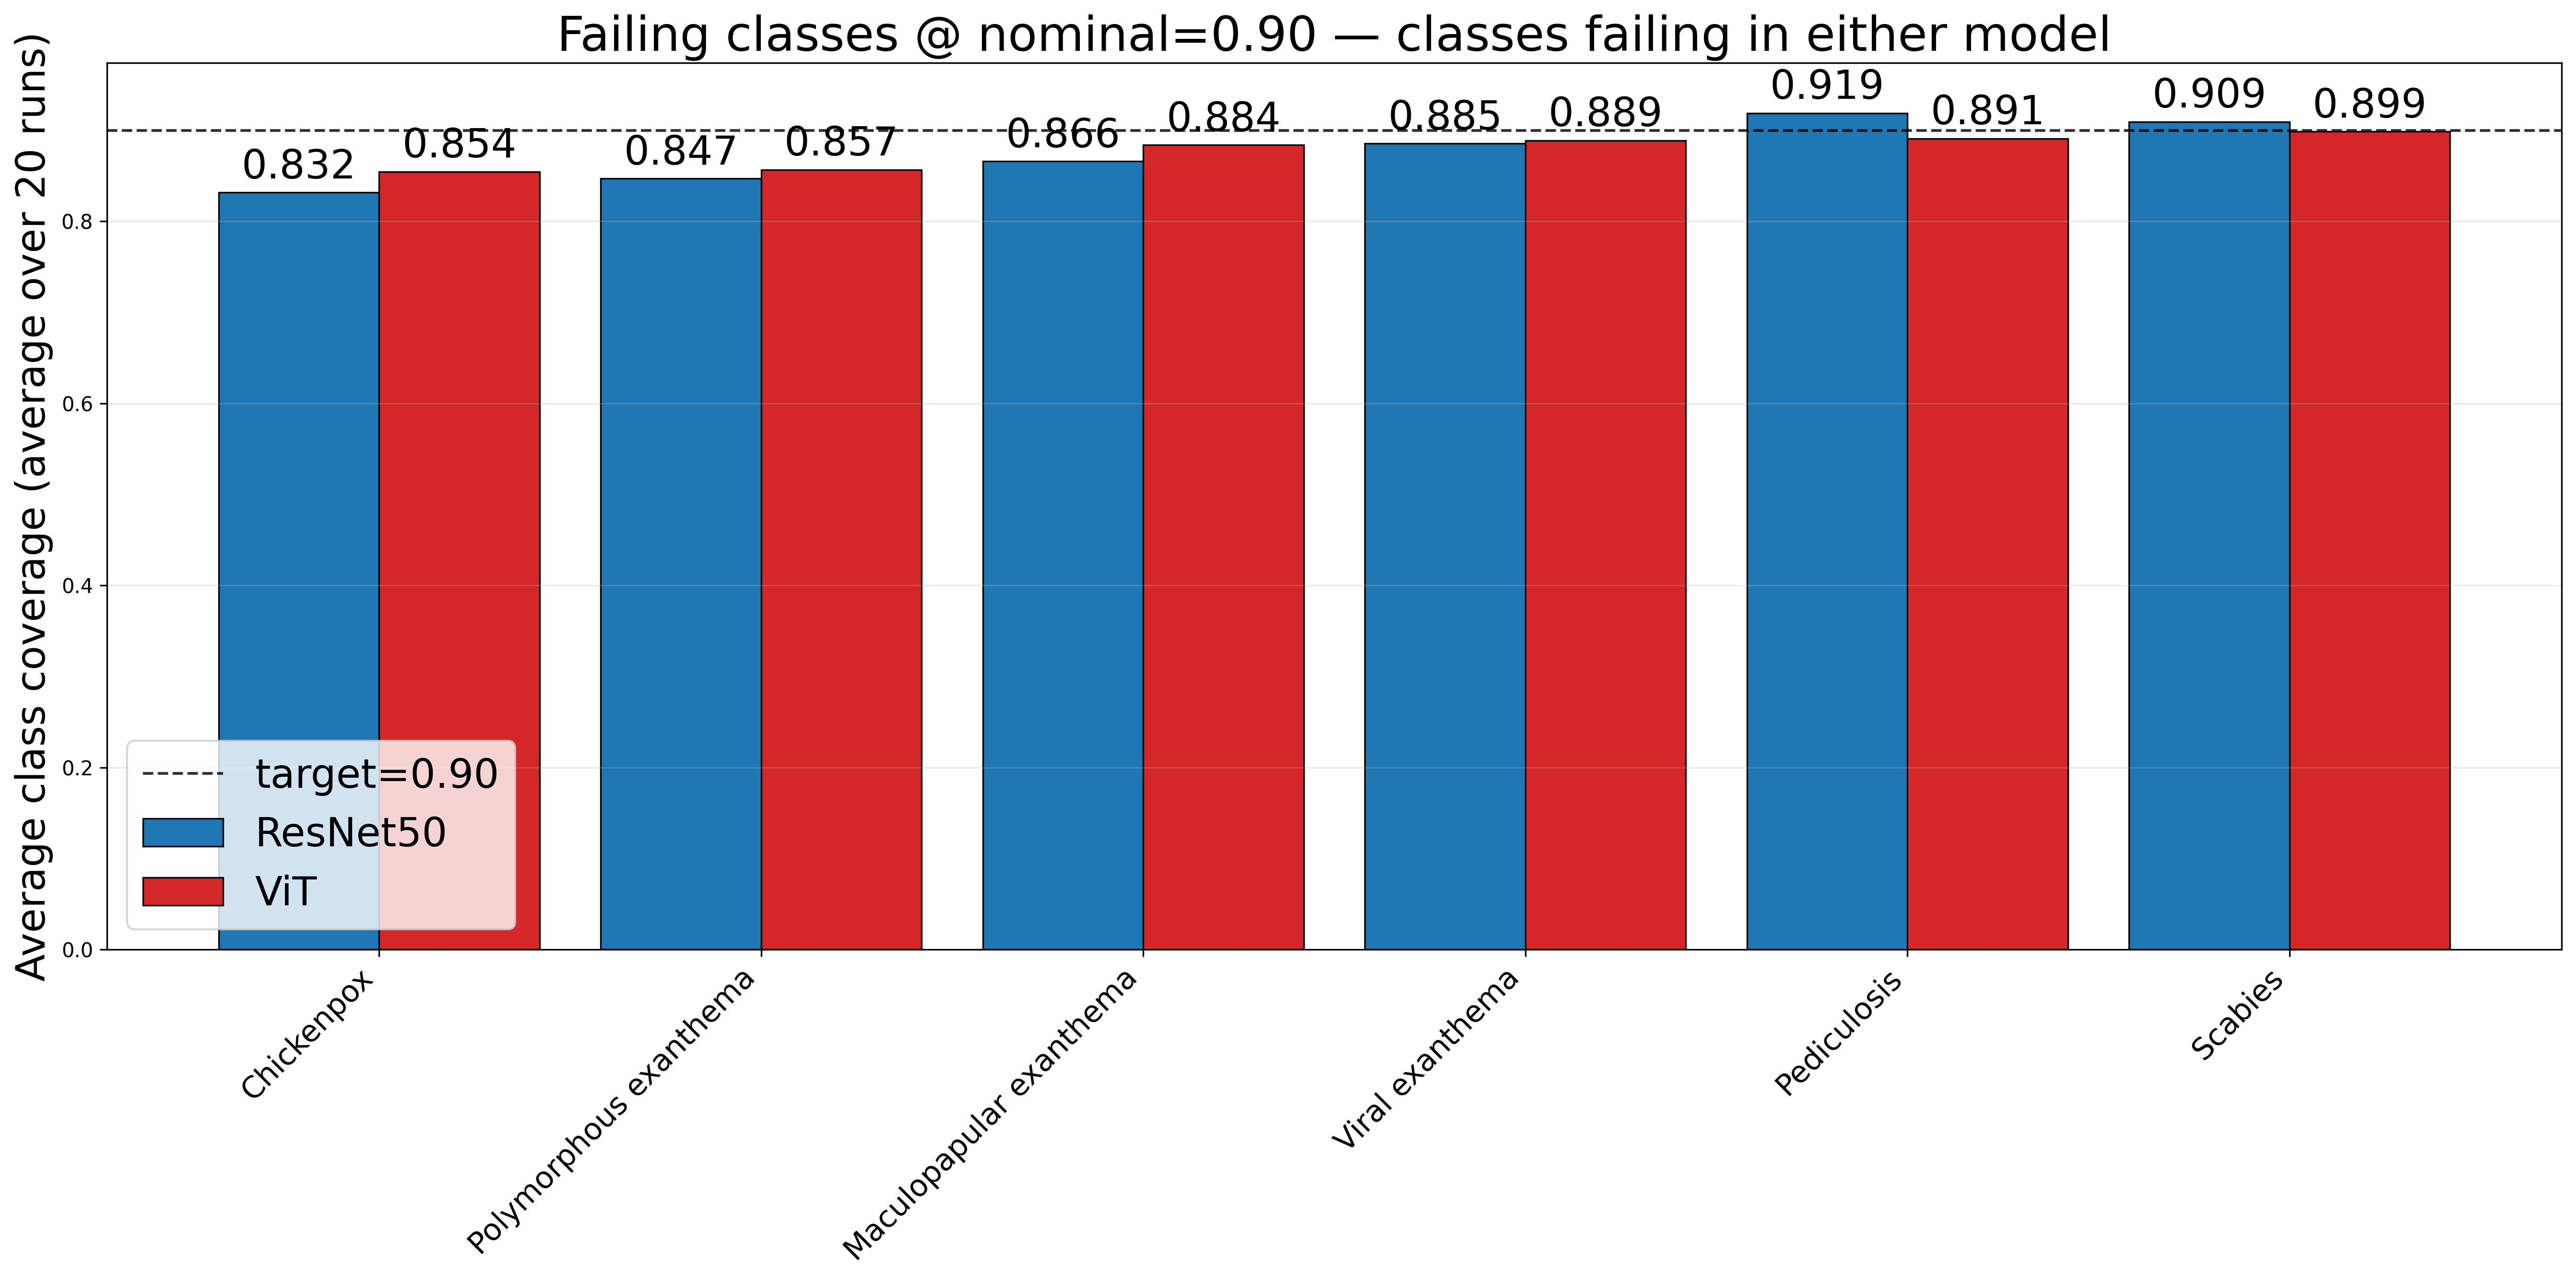

In [ ]:
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=24,
    legend_fontsize=20,
    y_label_fontsize=20,   
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color = "#1f77b4", 
vit_color    = "#d62728",   
bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 9),
)

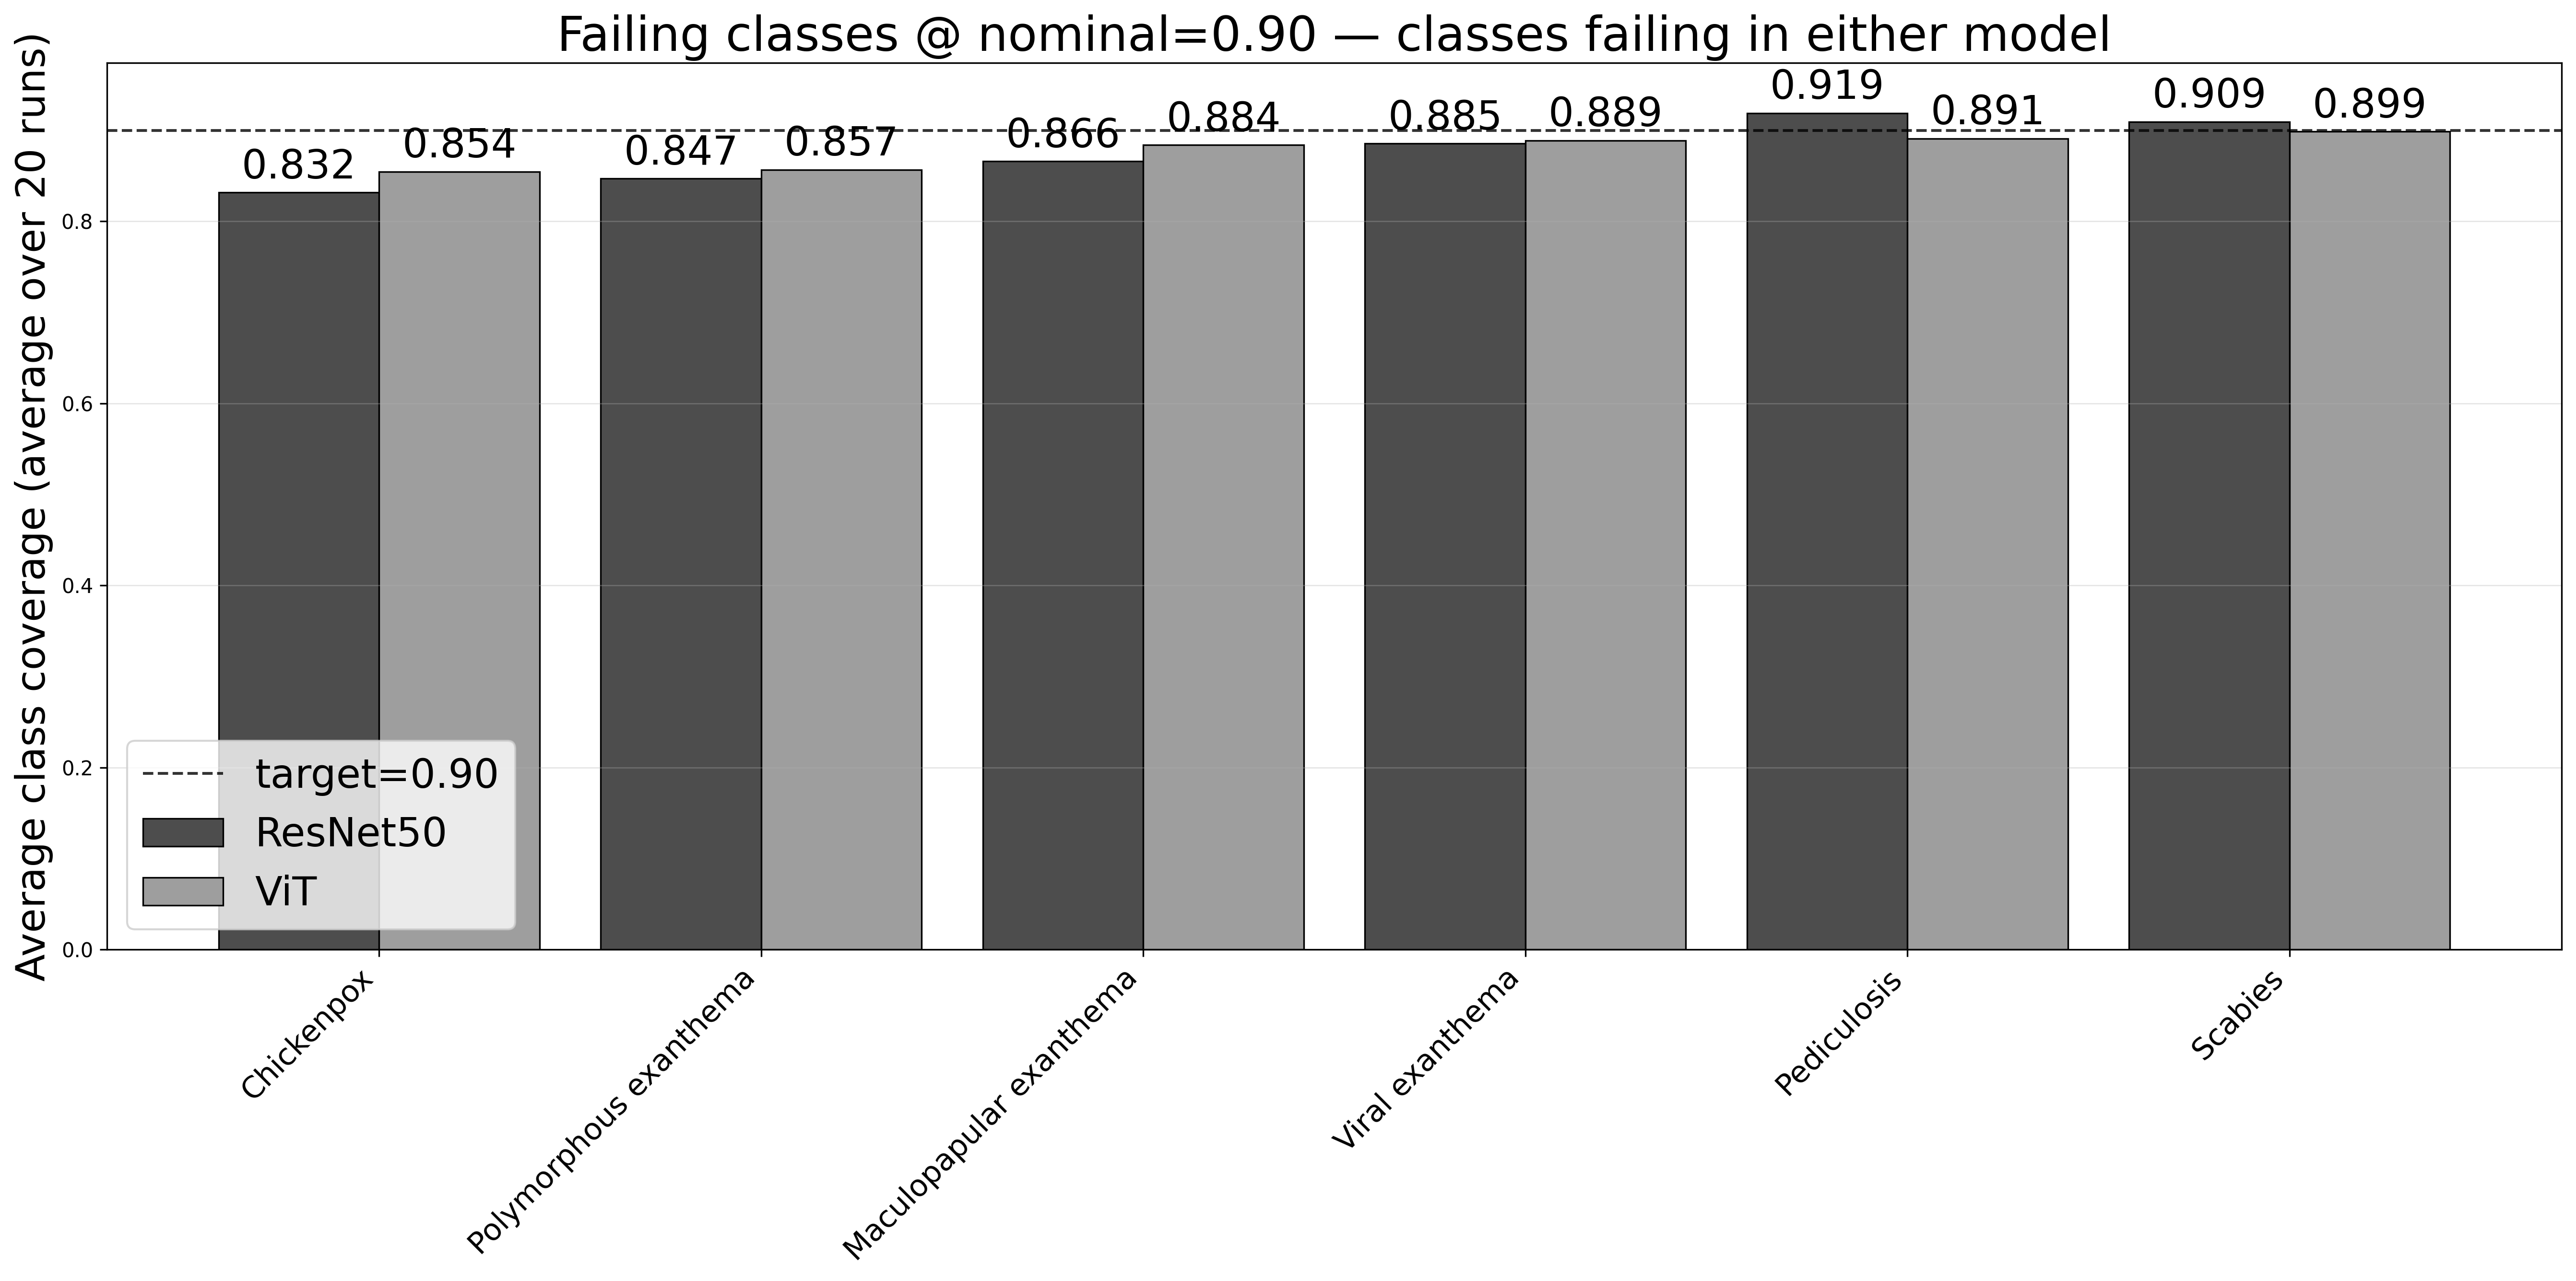

In [ ]:
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=24,
    legend_fontsize=20,
    y_label_fontsize=20,   
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color="#4D4D4D",
    vit_color="#9E9E9E",
    bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 9),
)

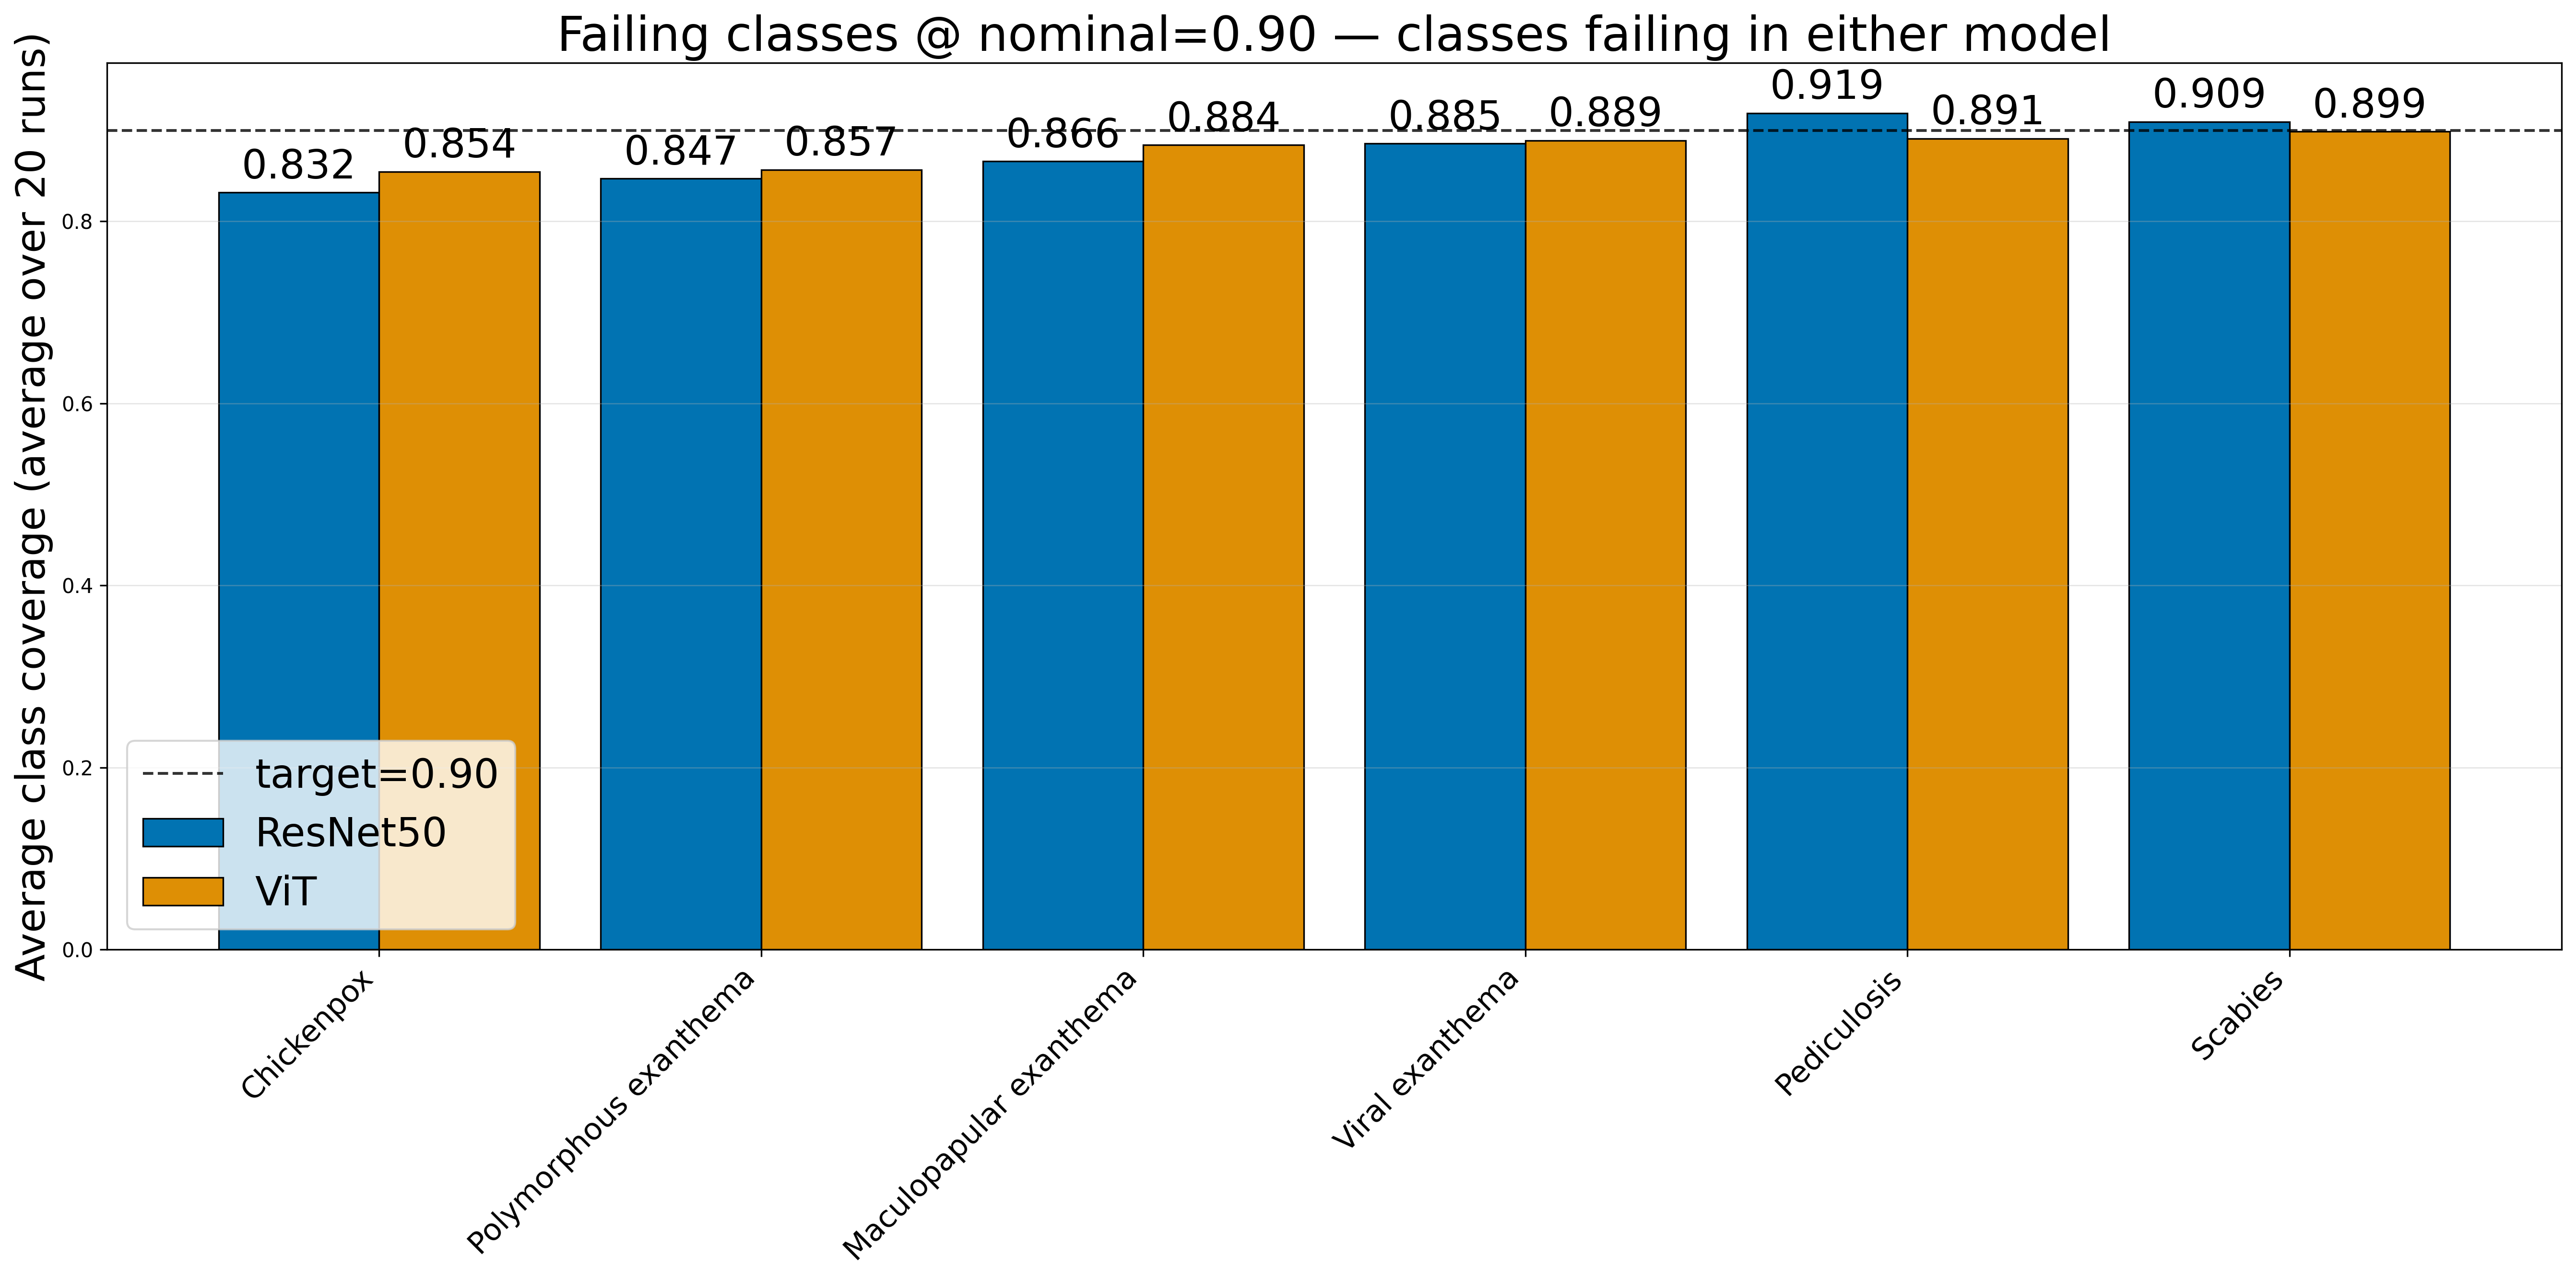

In [ ]:
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=24,
    legend_fontsize=20,
    y_label_fontsize=20,  
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color = "#0173B2",   # seaborn blue
vit_color    = "#DE8F05",   # seaborn orange
    bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 9),
)

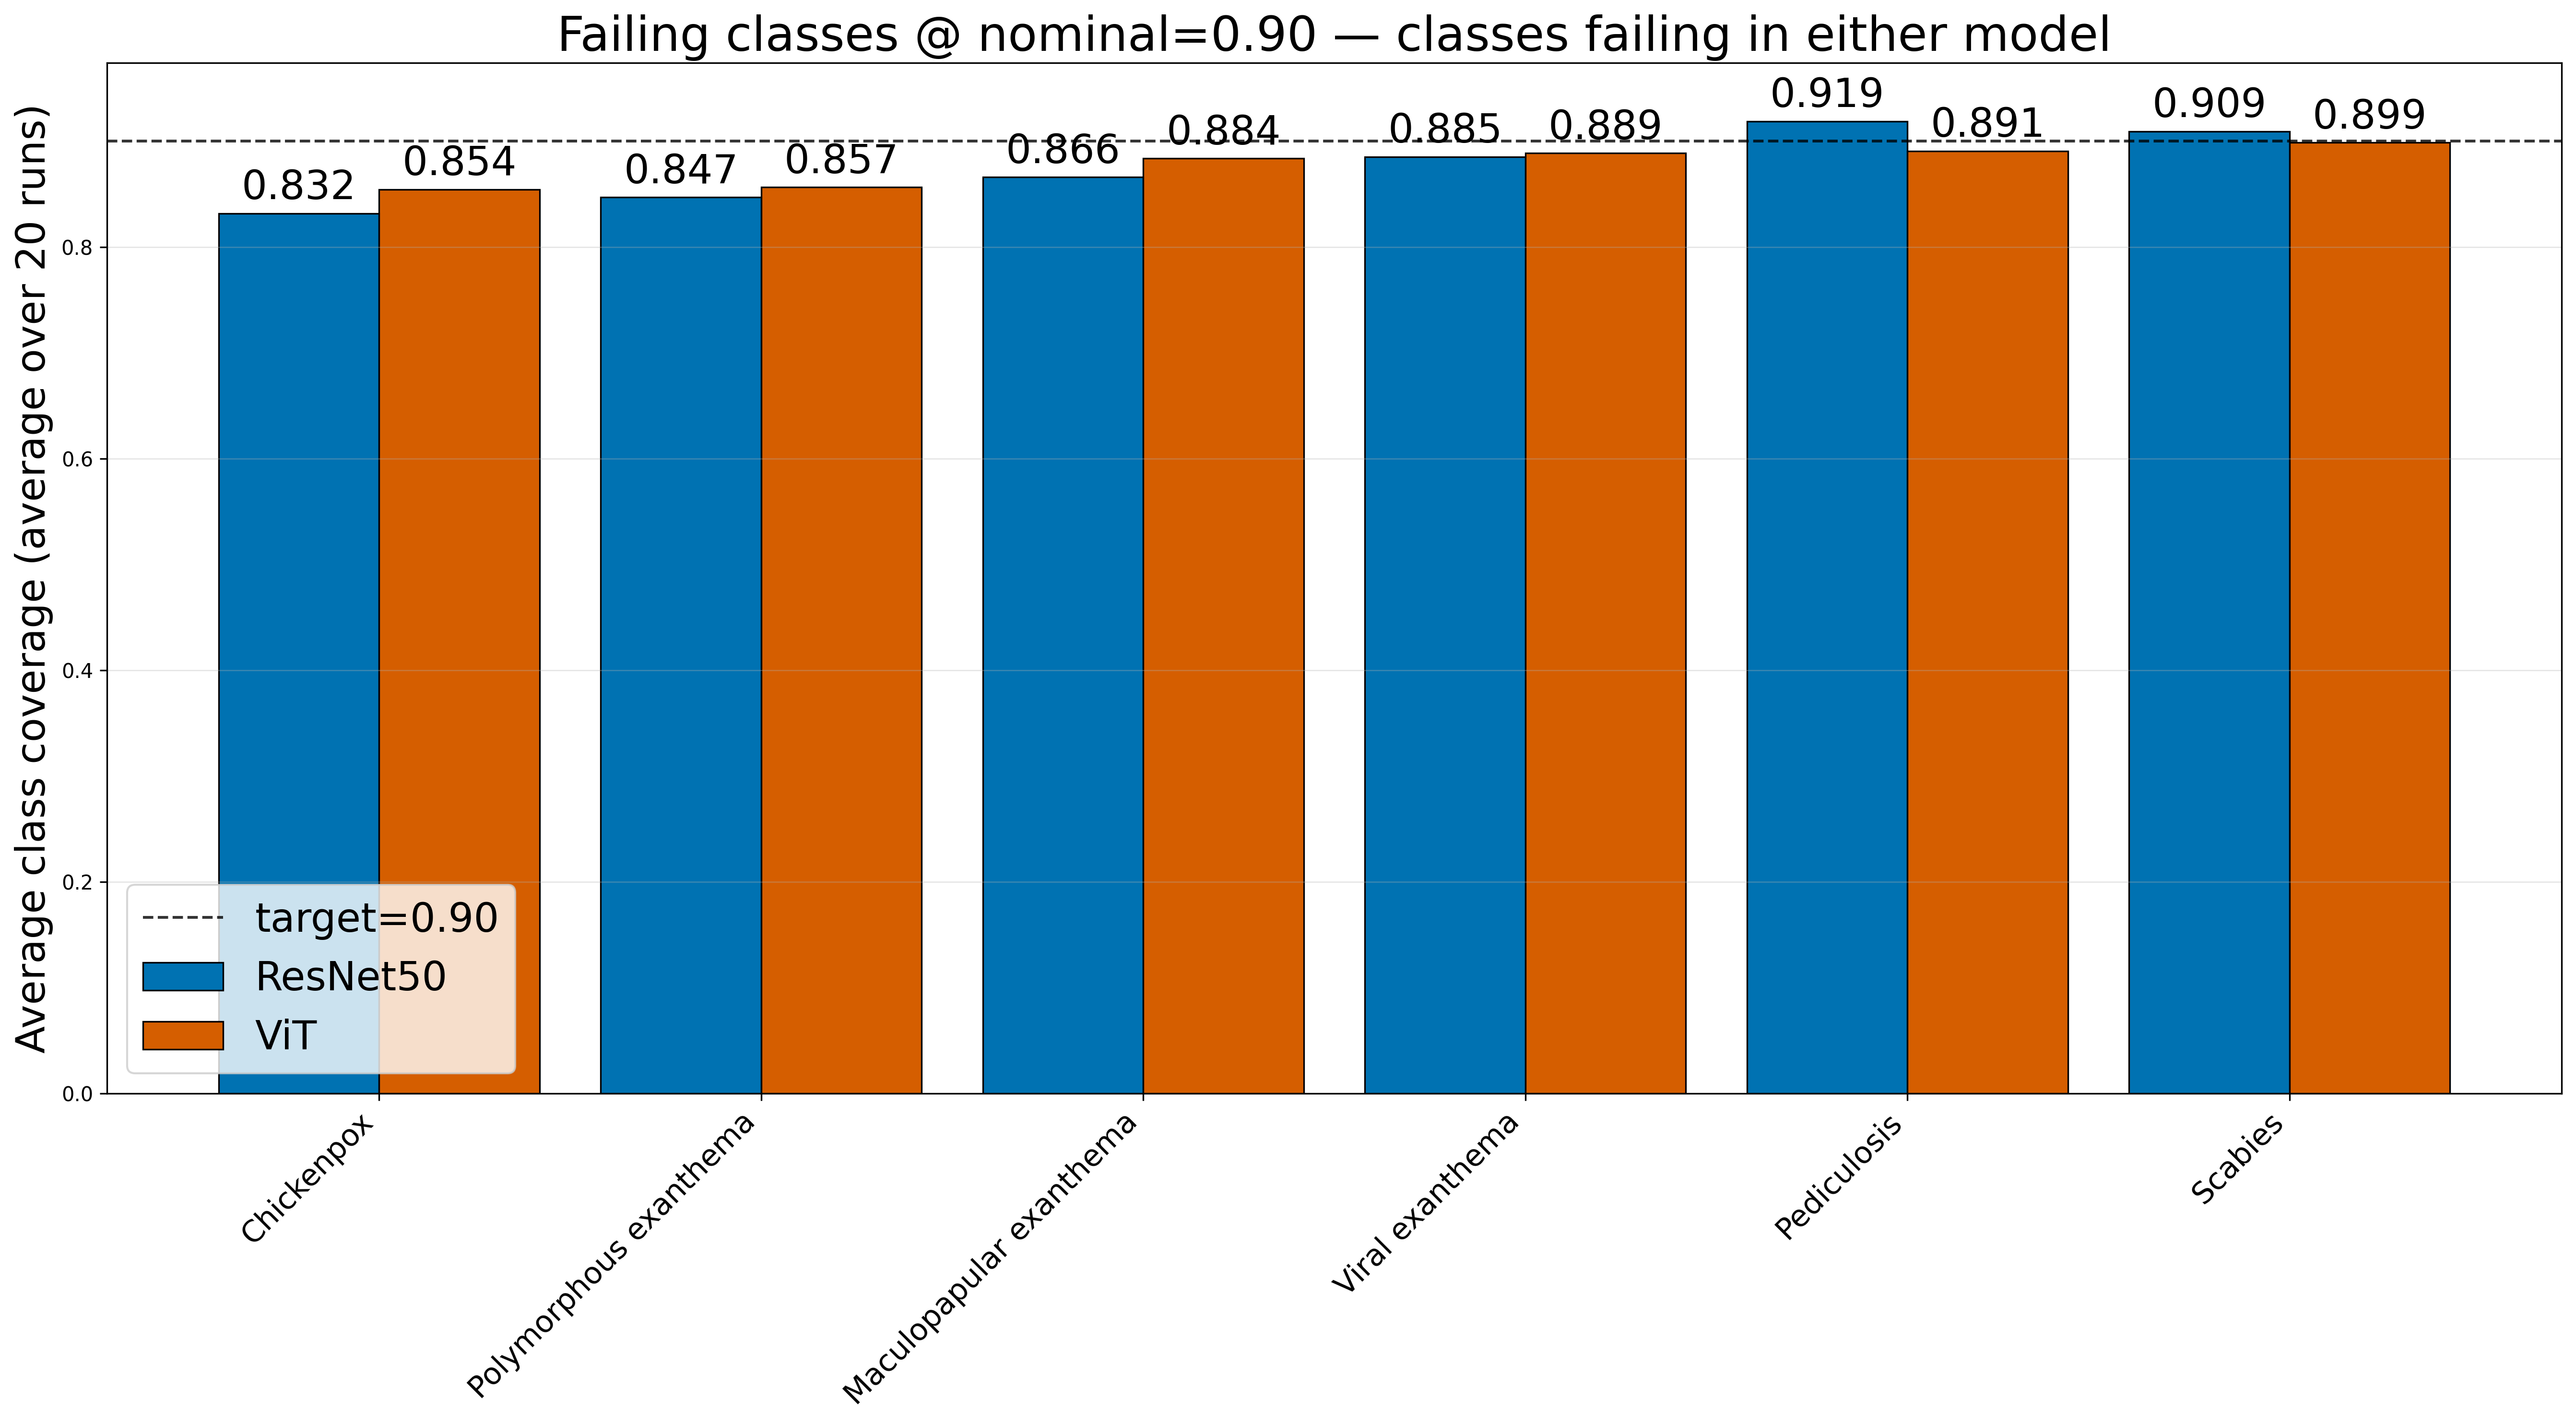

In [ ]:
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=24,
    legend_fontsize=20,
    y_label_fontsize=20,   
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color="#0072B2",
vit_color="#D55E00",
    bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 10),
)

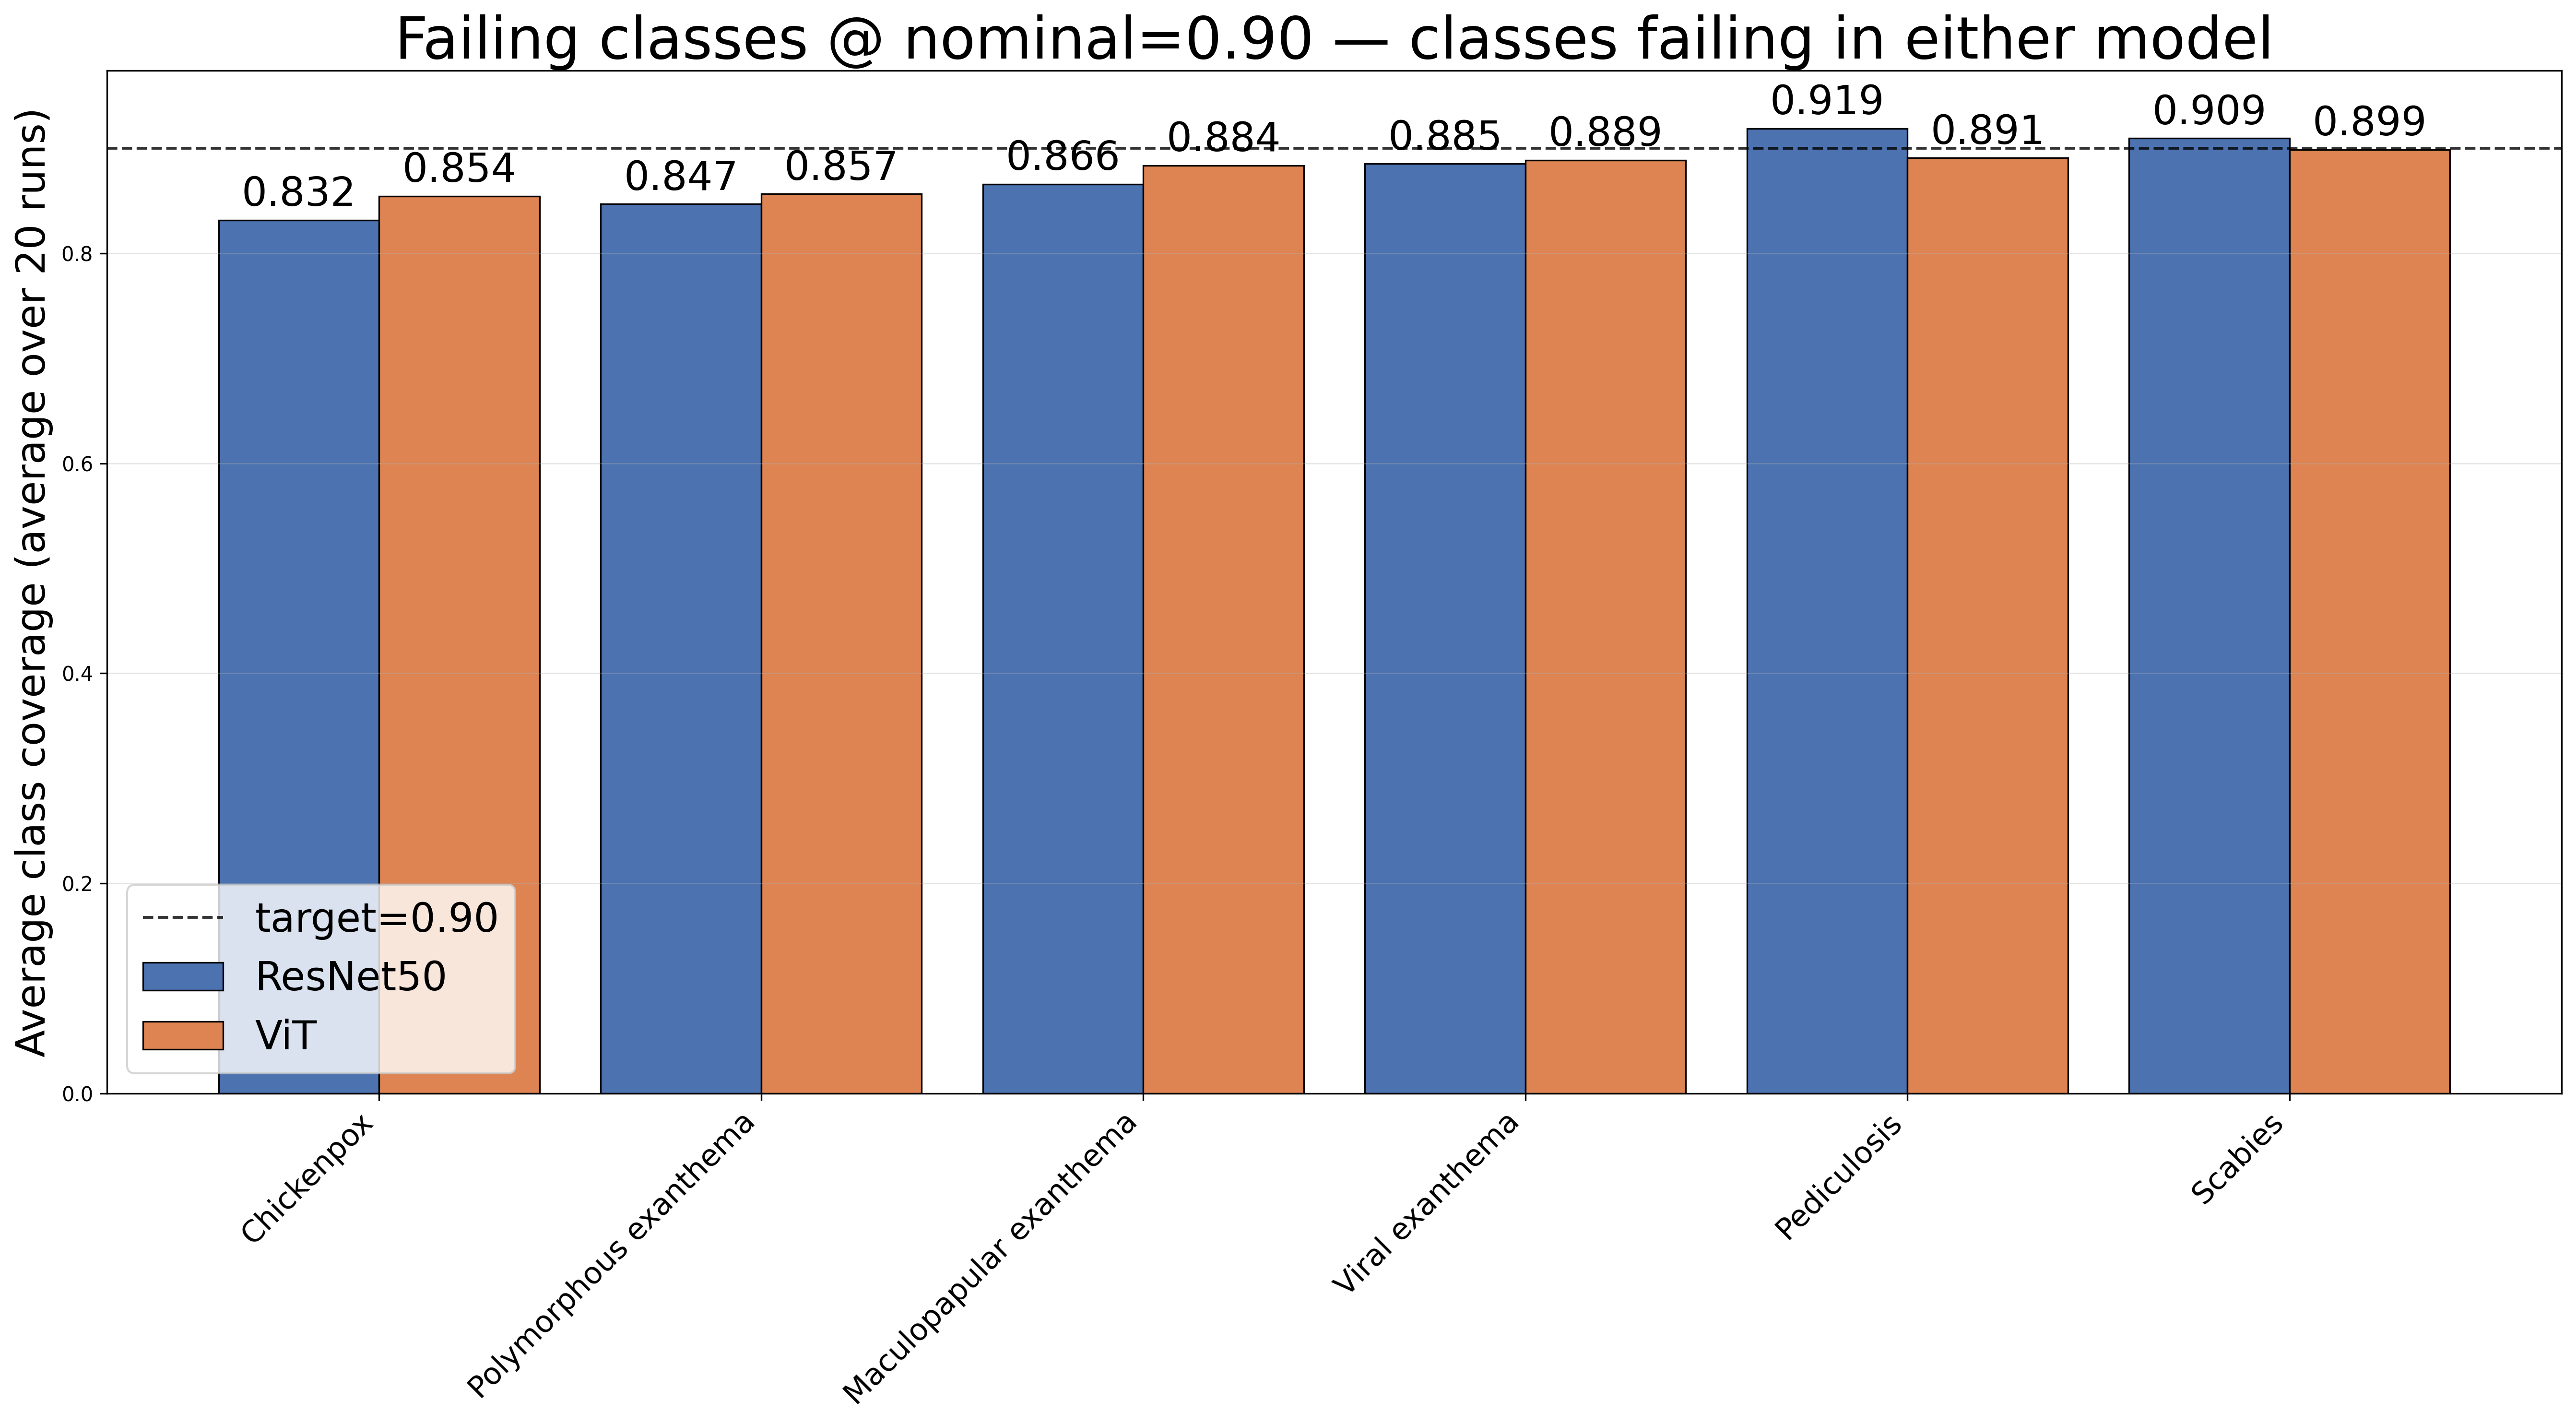

In [ ]:
failing = plot_failing_classes_avg_coverages_annotated(
    class_df=class_df,
    target=0.90,
    resnet_name="ResNet50",
    vit_name="ViT",
    failing_rule="either",
    sort_by="min",
    class_fontsize=15,
    annotate_fontsize=20,
    title_fontsize=29,
    legend_fontsize=20,
    y_label_fontsize=20,  
    grid=True,
    grid_axis="y",
    grid_linewidth=0.6,
    grid_alpha=0.35,
    resnet_color="#4C72B0",
vit_color="#DD8452",
    bar_edgecolor="black",
    bar_linewidth=0.8,
    figsize=(18, 10),
)

In [ ]:
def plot_gap_vs_improvement_annotated(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",   
    top_k: Optional[int] = None,
    class_fontsize: int = 8,
    annotate_fontsize: int = 8,
    dpi: int = 300,
    out_path: Optional[str] = None,
):
    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows for target_coverage={t}")

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )

    per_model = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model.pivot(index="class_name", columns="model", values="mean_cov")
    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any")

    out = piv.copy()
    out["gap_resnet"] = t - out[resnet_name]
    out["gap_vit"] = t - out[vit_name]
    out["gap"] = np.maximum(out["gap_resnet"], out["gap_vit"])
    out["delta"] = out[vit_name] - out[resnet_name]

    if failing_rule == "either":
        out = out[(out["gap_resnet"] > 0) | (out["gap_vit"] > 0)]
    elif failing_rule == "both":
        out = out[(out["gap_resnet"] > 0) & (out["gap_vit"] > 0)]
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if out.empty:
        print("No failing classes.")
        return out

    out = out.sort_values("gap", ascending=False)
    if top_k is not None:
        out = out.head(int(top_k))

    classes = out.index.tolist()


    gaps = (out["gap"].values * 100.0)
    deltas = (out["delta"].values * 100.0)

    y = np.arange(len(classes))
    h = 0.38

    fig, ax = plt.subplots(figsize=(10, max(4, 0.45 * len(classes))), dpi=dpi)


    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["bottom"].set_visible(True)


    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    bars_gap = ax.barh(
        y + h/2, gaps, height=h, label="Coverage gap (%)", color="#4C72B0"
    )
    bars_delta = ax.barh(
        y - h/2, deltas, height=h, label="Improvement (ViT − ResNet) (%)", color="#DD8452"
    )

    ax.axvline(0.0, linewidth=1.2, color="black")


    x_min, x_max = ax.get_xlim()
    pad = 0.015 * (x_max - x_min)

    def annotate(bars, values):
        for bar, v in zip(bars, values):
            x = bar.get_width()
            y0 = bar.get_y() + bar.get_height() / 2
            label = f"{v:+.1f}%"
            if v >= 0:
                ax.text(x + pad, y0, label, va="center", ha="left", fontsize=annotate_fontsize)
            else:
                ax.text(x - pad, y0, label, va="center", ha="right", fontsize=annotate_fontsize)

    annotate(bars_gap, gaps)
    annotate(bars_delta, deltas)

    ax.set_yticks(y)
    ax.set_yticklabels(classes, fontsize=class_fontsize)
    ax.set_xlabel("Values in Percentage points (%)")
    ax.set_title(f"Coverage gap vs improvement @ nominal={t:.2f}", fontweight="normal")
    ax.legend(
        frameon=True,
        fontsize=8,
        handlelength=1.2,
        handletextpad=0.5,
        borderpad=0.4,
        labelspacing=0.3
    )
    ax.grid(True, axis="x", linewidth=0.6, alpha=0.35)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

    return out


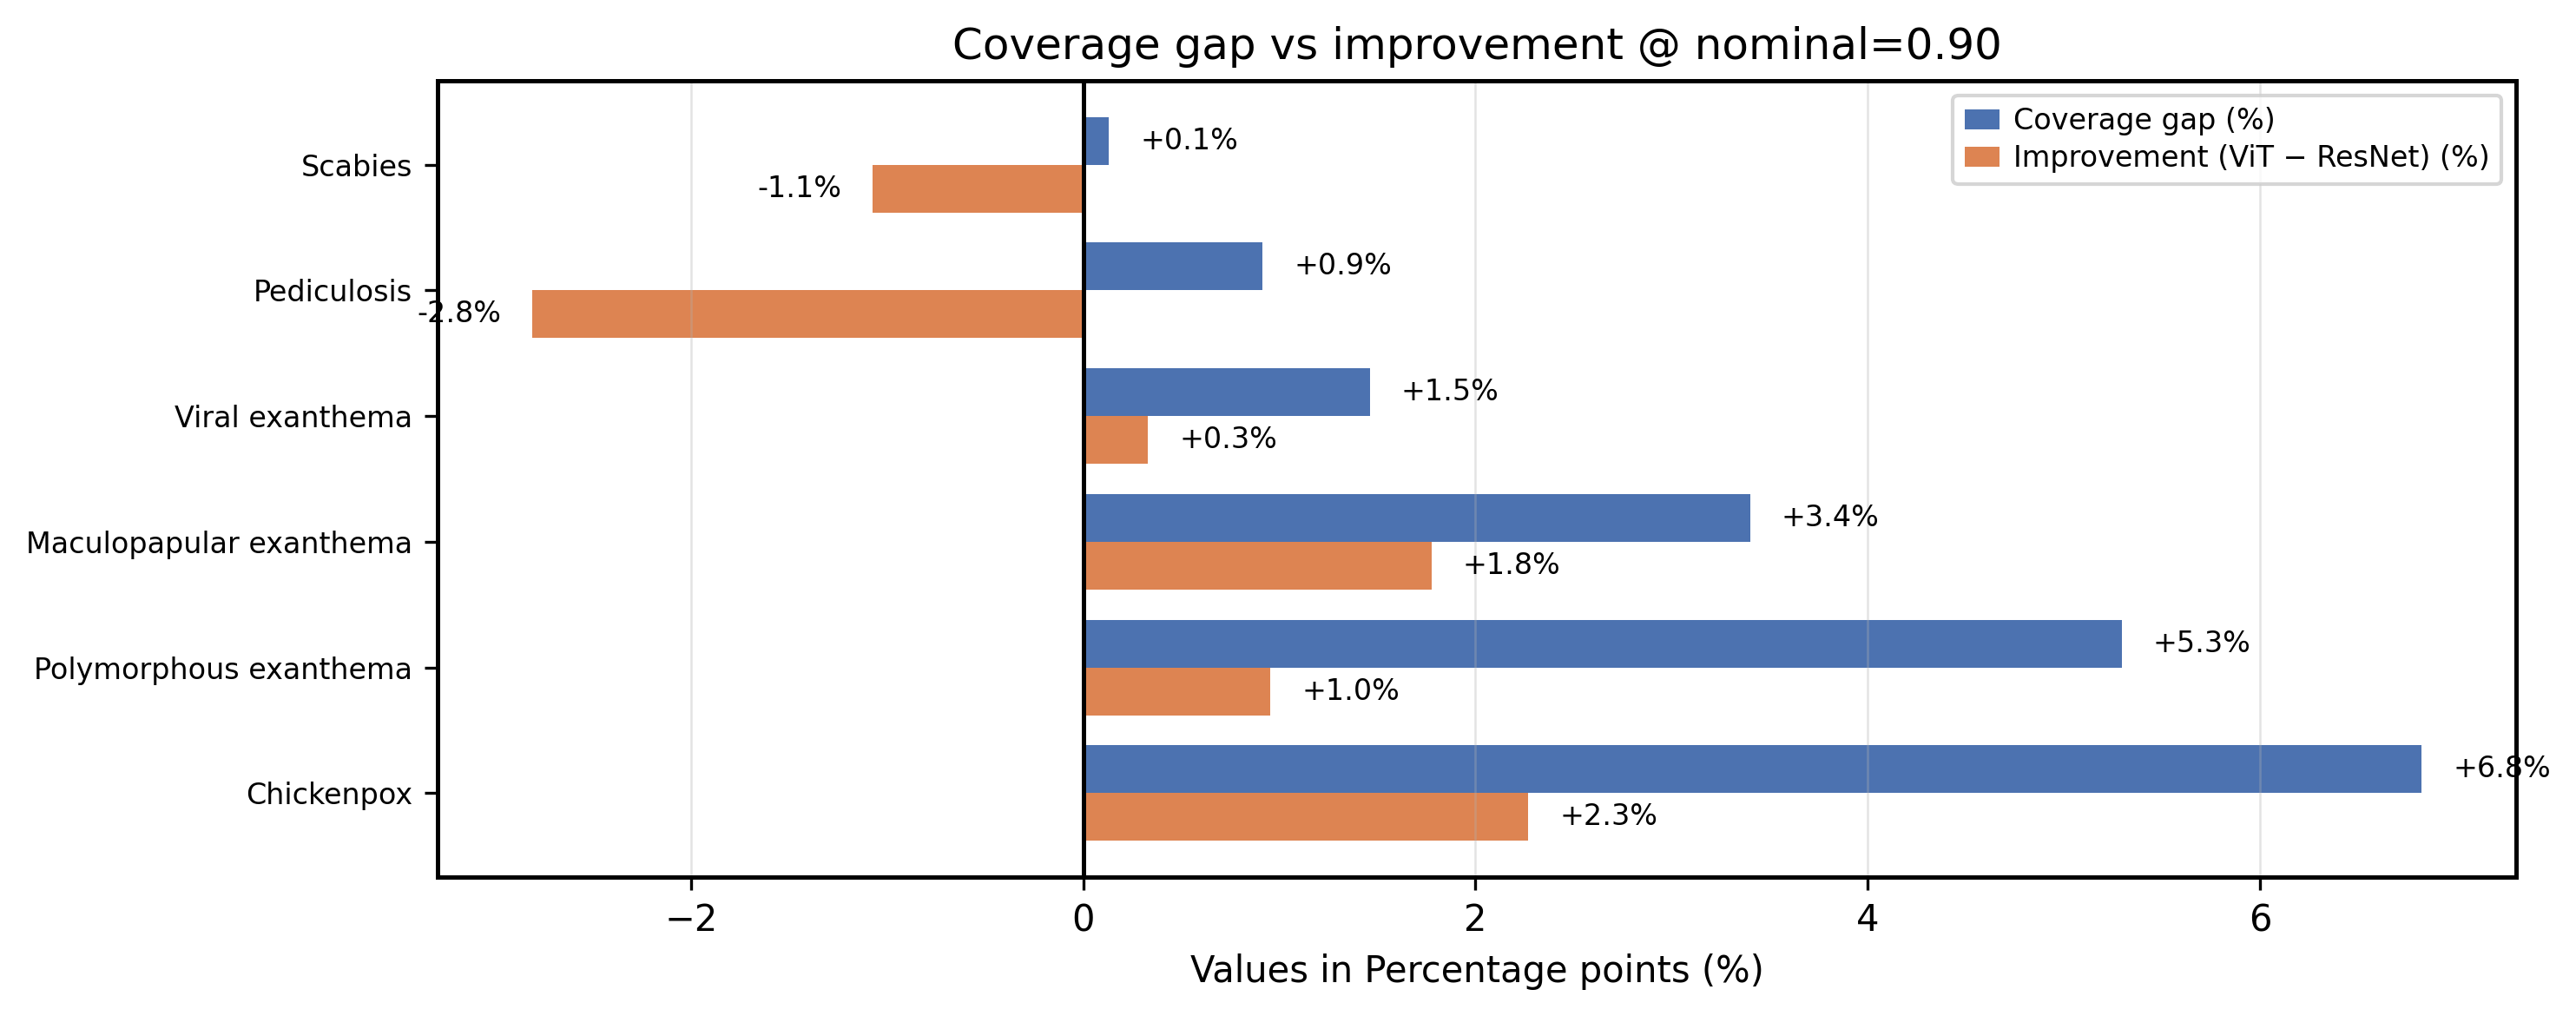

In [38]:
tbl = plot_gap_vs_improvement_annotated(
    class_df,
    target=0.90,
    failing_rule="either",
    top_k=20,
    out_path="paper_plots/gap_vs_improvement_annotated_0p90.png"
)


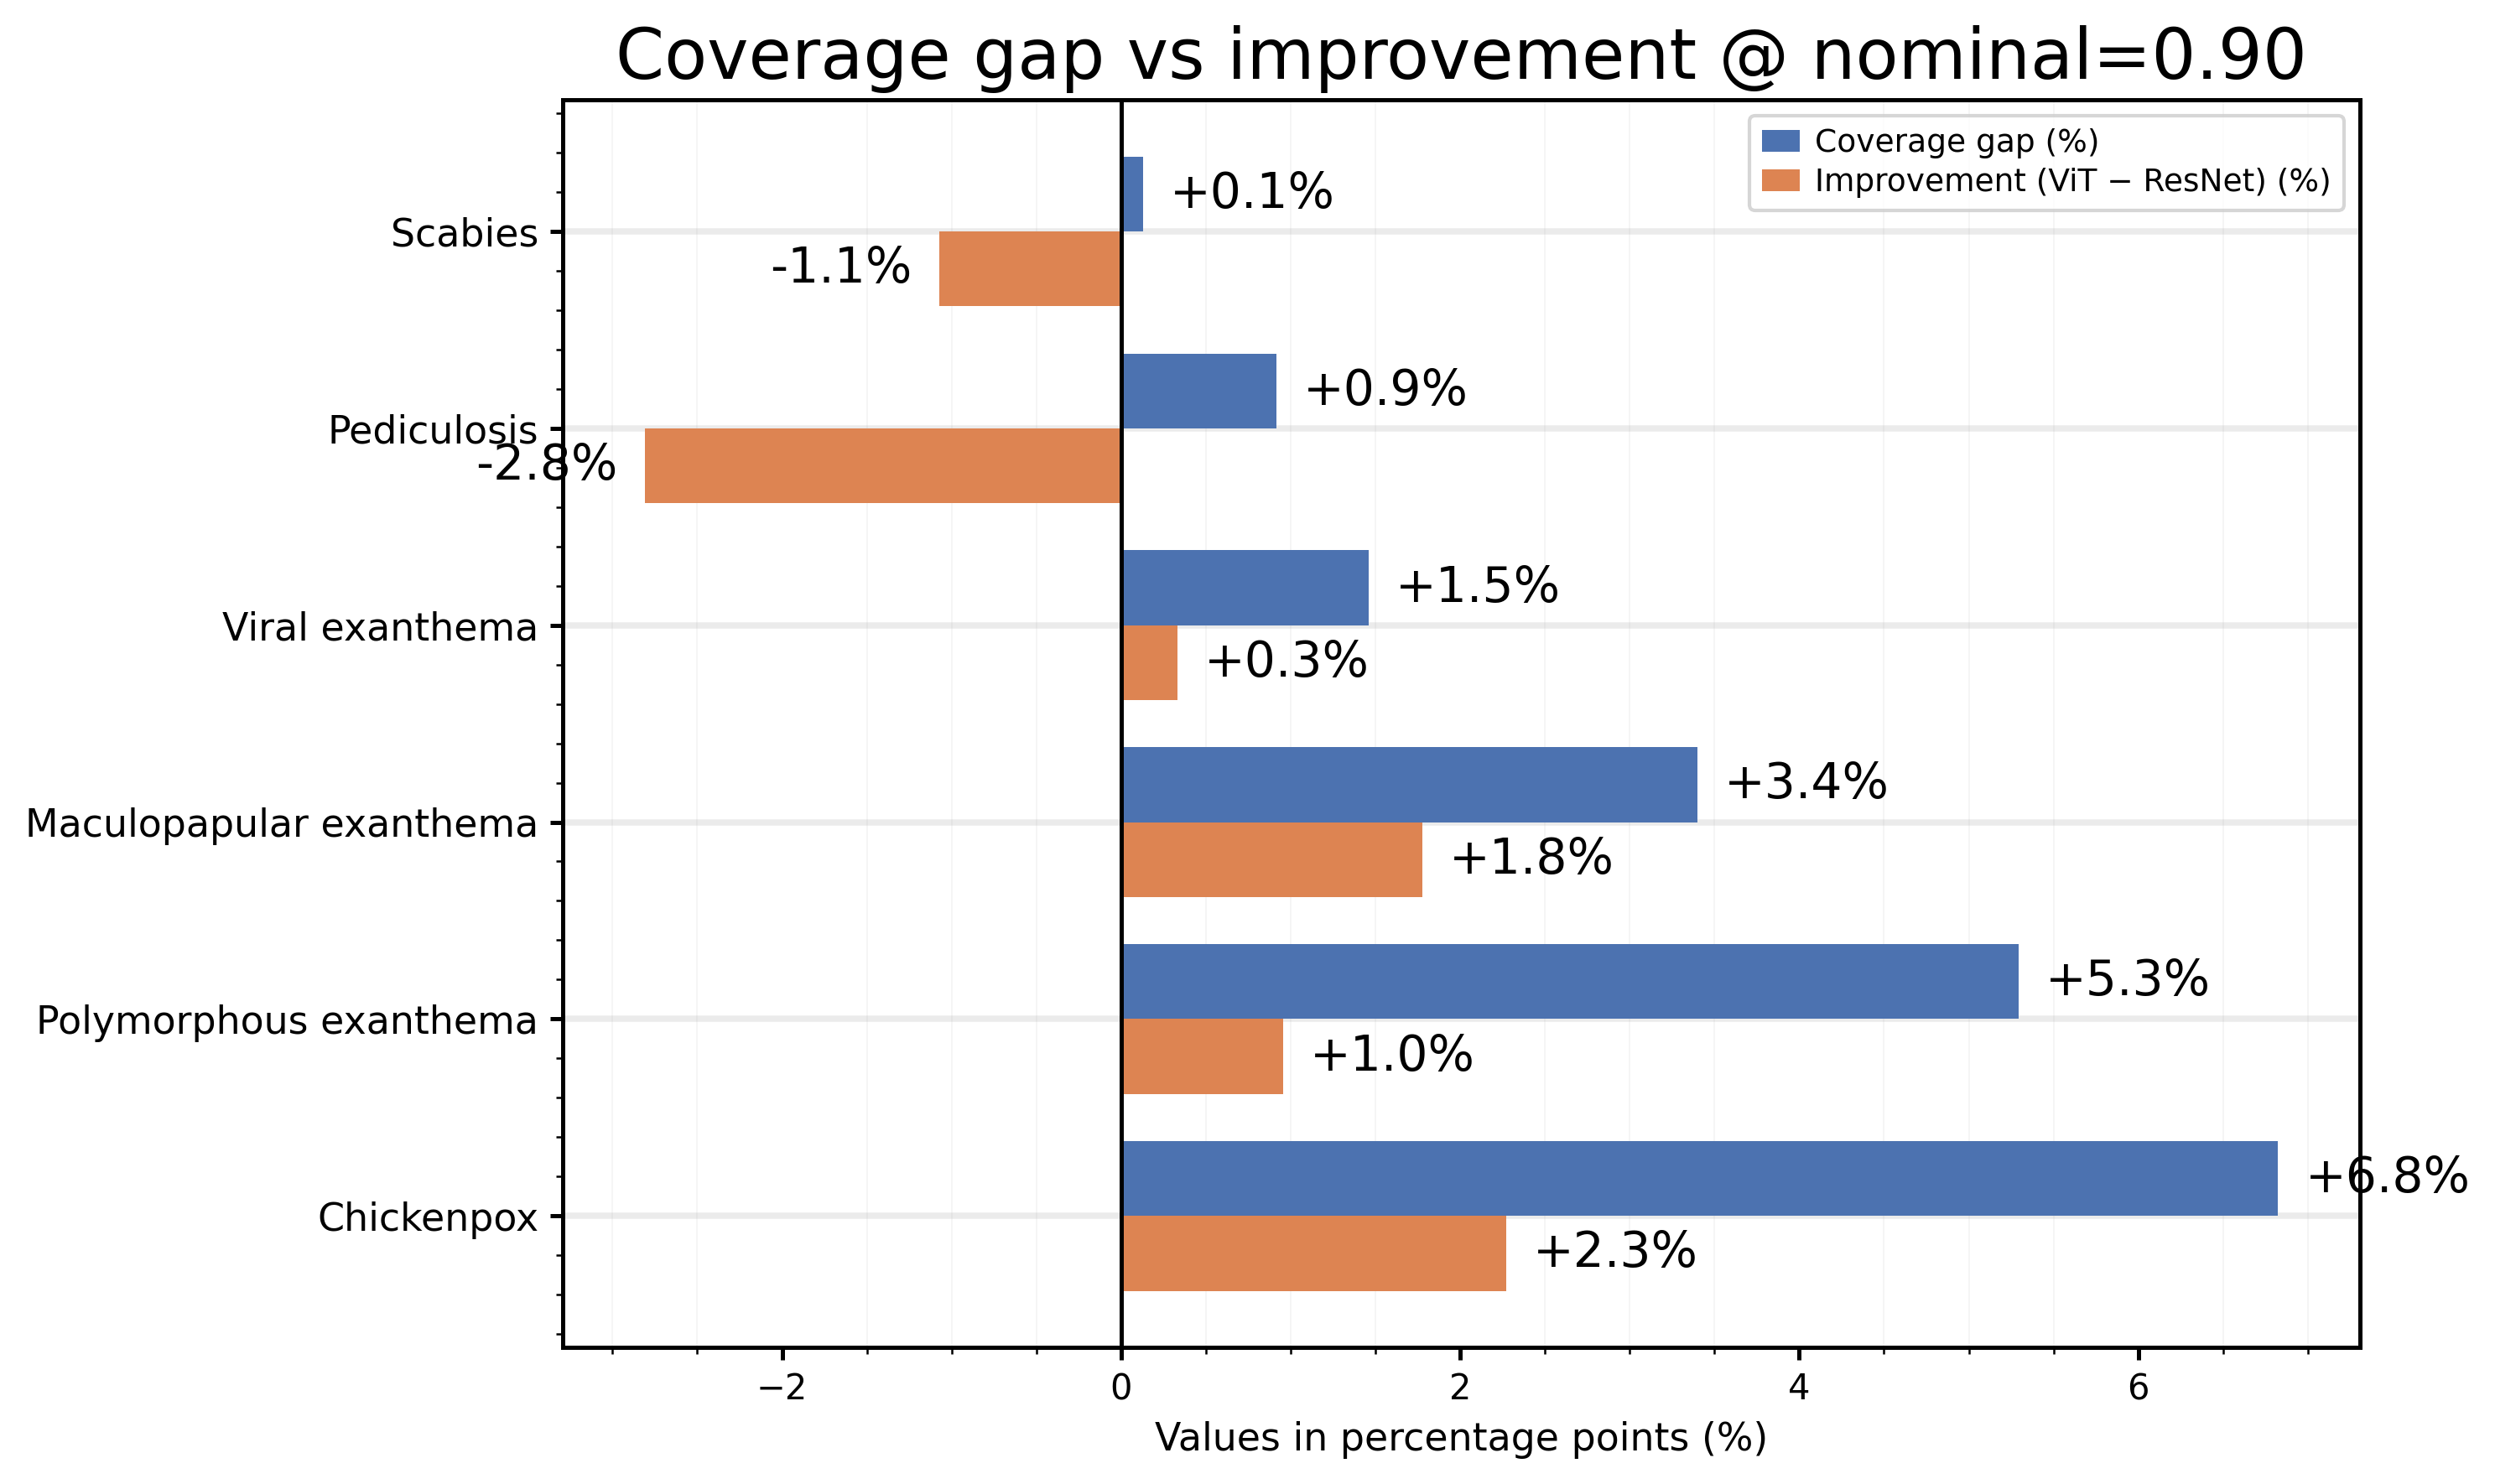

In [ ]:
from typing import Optional
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_gap_vs_improvement_annotated(
    class_df: pd.DataFrame,
    target: float = 0.90,
    resnet_name: str = "ResNet50",
    vit_name: str = "ViT",
    failing_rule: str = "either",   
    top_k: Optional[int] = None,


    annotations_font_size: int = 9,         
    disease_class_font_size: int = 9,        
    title_font_size: int = 12,
    xlabel_font_size: int = 11,
    xtick_font_size: int = 10,
    legend_font_size: int = 9,


    fig_width: float = 10.0,                 
    fig_row_height: float = 0.45,            
    fig_min_height: float = 4.0,             


    spine_linewidth: float = 1.2,
    axis_linewidth: float = 1.2,
    grid_linewidth: float = 0.6,
    grid_alpha: float = 0.35,
    vline_linewidth: float = 1.2,
    bar_height: float = 0.38,
    annotate_fmt: str = "{v:+.1f}%",         
    pad_frac: float = 0.015,                 


    dpi: int = 300,
    out_path: Optional[str] = None,
):

    def normalize_class_name(x):


        if pd.isna(x):
            return x
        return str(x).strip()

    required = {"model", "run", "target_coverage", "class_name", "class_coverage"}
    if not required.issubset(class_df.columns):
        raise ValueError(f"class_df must contain columns: {required}")

    t = round(float(target), 2)

    d = class_df.copy()
    d["target_coverage"] = d["target_coverage"].astype(float).round(2)
    d = d[d["target_coverage"] == t].copy()
    if d.empty:
        raise ValueError(f"No rows for target_coverage={t}")

    d["class_name"] = d["class_name"].map(normalize_class_name)
    d["class_coverage"] = d["class_coverage"].astype(float)


    per_run = (
        d.groupby(["model", "run", "class_name"], as_index=False)
         .agg(class_coverage=("class_coverage", "mean"))
    )


    per_model = (
        per_run.groupby(["model", "class_name"], as_index=False)
               .agg(mean_cov=("class_coverage", "mean"))
    )

    piv = per_model.pivot(index="class_name", columns="model", values="mean_cov")
    if resnet_name not in piv.columns or vit_name not in piv.columns:
        raise ValueError(
            f"Pivot table missing required model columns. "
            f"Found columns: {list(piv.columns)}. "
            f"Expected: {resnet_name}, {vit_name}"
        )

    piv = piv[[resnet_name, vit_name]].dropna(axis=0, how="any")

    out = piv.copy()
    out["gap_resnet"] = t - out[resnet_name]
    out["gap_vit"] = t - out[vit_name]


    out["gap"] = np.maximum(out["gap_resnet"], out["gap_vit"])

    # improvement of ViT over ResNet (in coverage units)
    out["delta"] = out[vit_name] - out[resnet_name]

    if failing_rule == "either":
        out = out[(out["gap_resnet"] > 0) | (out["gap_vit"] > 0)]
    elif failing_rule == "both":
        out = out[(out["gap_resnet"] > 0) & (out["gap_vit"] > 0)]
    else:
        raise ValueError("failing_rule must be 'either' or 'both'")

    if out.empty:
        print("No failing classes.")
        return out

    out = out.sort_values("gap", ascending=False)
    if top_k is not None:
        out = out.head(int(top_k))

    classes = out.index.tolist()
    gaps = (out["gap"].values * 100.0)       
    deltas = (out["delta"].values * 100.0)   

    y = np.arange(len(classes))
    h = float(bar_height)


    fig_h = max(float(fig_min_height), float(fig_row_height) * len(classes))
    fig, ax = plt.subplots(figsize=(float(fig_width), fig_h), dpi=int(dpi))


    for side in ["right", "left", "top", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(float(spine_linewidth))

    ax.tick_params(axis="both", width=float(axis_linewidth))


    COLOR_GAP = "#4C72B0"      
    COLOR_DELTA = "#DD8452"    

    bars_gap = ax.barh(
        y + h / 2,
        gaps,
        height=h,
        label="Coverage gap (%)",
        color=COLOR_GAP
    )

    bars_delta = ax.barh(
        y - h / 2,
        deltas,
        height=h,
        label="Improvement (ViT − ResNet) (%)",
        color=COLOR_DELTA
    )

    ax.axvline(0.0, linewidth=float(vline_linewidth), color="black")


    x_min, x_max = ax.get_xlim()
    pad = float(pad_frac) * (x_max - x_min)

    def annotate(bars, values):
        for bar, v in zip(bars, values):
            x = bar.get_width()
            y0 = bar.get_y() + bar.get_height() / 2
            label = annotate_fmt.format(v=v)

            if v >= 0:
                ax.text(
                    x + pad, y0, label,
                    va="center", ha="left",
                    fontsize=int(annotations_font_size)
                )
            else:
                ax.text(
                    x - pad, y0, label,
                    va="center", ha="right",
                    fontsize=int(annotations_font_size)
                )

    annotate(bars_gap, gaps)
    annotate(bars_delta, deltas)


    ax.set_yticks(y)
    ax.set_yticklabels(classes, fontsize=int(disease_class_font_size))

    ax.set_xlabel("Values in percentage points (%)", fontsize=int(xlabel_font_size))
    ax.set_title(
        f"Coverage gap vs improvement @ nominal={t:.2f}",
        fontsize=int(title_font_size),
        fontweight="normal"
    )
    ax.tick_params(axis="x", labelsize=int(xtick_font_size))


    ax.legend(
        frameon=True,
        fontsize=int(legend_font_size),
        handlelength=1.2,
        handletextpad=0.5,
        borderpad=0.4,
        labelspacing=0.3
    )

    ax.set_axisbelow(True)  

    # Major grid lines
    #ax.grid(True, axis="x", linewidth=float(grid_linewidth), alpha=float(grid_alpha))
    ax.grid(True, axis="y", linewidth=1.8, alpha=0.25)

    # Optional: minor vertical grid lines for readability
    ax.minorticks_on()
    ax.grid(True, which="minor", axis="x", linewidth=0.4, alpha=0.15)


    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
    plt.show()

    return out



tbl = plot_gap_vs_improvement_annotated(
    class_df,
    target=0.90,
    failing_rule="either",
    top_k=20,
    annotations_font_size=14,
    disease_class_font_size=11,
    title_font_size=20,
    xlabel_font_size=11,
    xtick_font_size=10,
    legend_font_size=9,
    fig_width=10.0,
    fig_row_height=0.45,
    fig_min_height=6.0,
    out_path="paper_plots/gap_vs_improvement_annotated_0p90.png"
)
